# Clasificación de mamografías

## Librerías 

In [62]:
# Carga y escritura de datos
import csv

# Manejo de matrices e imágenes
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.feature import graycomatrix, graycoprops

# Visualización
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Semilla para reproducibilidad
import random
random.seed(456)

# Clasificación
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

## Definición de constantes y funciones auxiliares

In [63]:
PATH="./dataset"

FATTY=0
FATTY_GLANDULAR=1
DENSE_GLANDULAR=2

# Lee el fichero csv y devuelve un diccionario con pares
# {nombre_fichero_sin_extension, etiqueta} donde la etiqueta
# toma valores 0, 1 o 2
def read_file(filename):
    csv_file = open(filename, 'r')
    reader = csv.reader(csv_file, delimiter=' ')
    data = dict()
    label_to_key = dict(F=FATTY, G=FATTY_GLANDULAR, D=DENSE_GLANDULAR)
    for row in reader:
        data[row[0]] = label_to_key[row[1]]
    csv_file.close()
    return data

# Convierte una etiqueta a formato texto
def key_to_str(key):
    keystr = ("FATTY", "FATTY_GLANDULAR", "DENSE_GLANDULAR")
    return keystr[key]


## Carga de datos

In [64]:
data = read_file(f"{PATH}/info.csv")
filenames = [f for f in listdir(PATH) if isfile(join(PATH, f)) and f[:2] != '._' and f[-3:] =='pgm']
filenames.sort() # Nombres de fichero ordenados alfabeticamente

images = []
masks = []
labels = []
for f in filenames:
    im = cv2.imread(f"{PATH}/{f}", cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(f"{PATH}/mask_{f[:-3]}png", cv2.IMREAD_GRAYSCALE)
    label = data[f[:-4]]
    images.append(im)
    masks.append(mask)
    labels.append(label)

# Almacenar en un diccionario cada fotografía con sus datos
images_dict = {}

for i in range(len(images)):
    images_dict[filenames[i]] = {
        'original': images[i],
        'mask': masks[i],
        'label': labels[i]
    }

## Visualización de datos

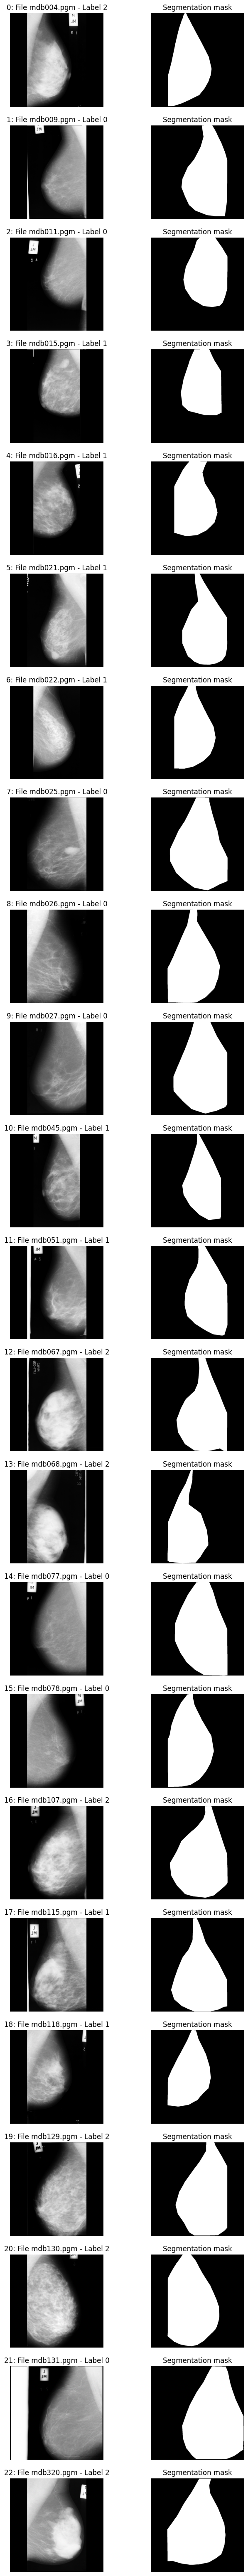

In [65]:
fig, axs = plt.subplots(len(images),2)
fig.set_figheight(80)
fig.set_figwidth(8)

for i in range(0,len(images)):
    axs[i,0].set_title(f"{i}: File {filenames[i]} - Label {labels[i]}")
    axs[i,0].imshow(images[i], cmap="gray")
    axs[i,1].set_title("Segmentation mask")
    axs[i,1].imshow(masks[i], cmap="gray")
    axs[i,0].set_axis_off()
    axs[i,1].set_axis_off()
plt.show()
    

## Segmentación

**1) Preprocesado:** Con el objetivo de eliminar ruido y artefactos.

In [66]:
def preprocesado_imagen(image, image_name="", plot=True):
    """
    Función para segmentar mamografías con el objetivo de extraer el tejido mamario.

    Parámetros:
    - image: imagen en escala de grises a procesar.
    - image_name: nombre de la imagen (para título si se muestra).
    - plot: si es True, se visualizan las etapas del proceso.

    Devuelve:
    - mask_final: imagen binaria usada como máscara para segmentar el tejido mamario.
    - masked_final: imagen segmentada.
    """
    ##############################################################################
    ######################### ENMASCARAR IMAGEN ORIGINAL #########################
    ##############################################################################

    # Filtro de mediana para suavizar
    blurred = cv2.medianBlur(image, 11)

    # Umbralización
    thr, dst = cv2.threshold(blurred, 15, 255, cv2.THRESH_BINARY)
    
    # Elminar bordes para evitar errores
    dst[:5,:] = 0 # fila superior
    dst[-5:,:] = 0 # fila inferior
    dst[:,:5] = 0 # columna izquierda
    dst[:,-5:] = 0 # columna derecha

    # Segmentación
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    # Inicializar máscara vacía
    filtered_mask = np.zeros_like(dst, dtype=np.uint8)

    # Excluir el fondo (label 0), buscar el índice con mayor área
    areas = stats[1:, cv2.CC_STAT_AREA]  # Todas las áreas menos la del fondo
    if len(areas) > 0:
        largest_idx = 1 + np.argmax(areas)  # Sumamos 1 porque excluimos stats[0]
        filtered_mask[labels == largest_idx] = 1  # Asignar solo el mayor componente

    # Aplicamos máscara
    masked = blurred * filtered_mask

    ##############################################################################
    ######################## SEGMENTACION TEJIDO MAMARIO #########################
    ##############################################################################

    # Umbralización
    thr, dst2 = cv2.threshold(masked, 170, 255, cv2.THRESH_BINARY)
    
    # Apertura para limpiar ruido final
    kernel = np.ones((7,7), np.uint8)
    dst2_opening = cv2.morphologyEx(dst2, cv2.MORPH_OPEN, kernel, iterations=2)

    # Connected components sobre la máscara umbralizada
    num_labels, labels_cc, stats_cc, centroids_cc = cv2.connectedComponentsWithStats(dst2_opening)

    # Máscara de salida
    mask_cleaned = np.zeros_like(dst2, dtype=np.uint8)

    min_size = 2000 # tamaño mínimo de los objetos para mantenerlo
    for i in range(1, num_labels):  # saltamos el fondo
        x, y, w, h, area = stats_cc[i]

        # Componente con límite superior menor que 30 = se mantiene
        is_at_top = y < 30

        is_big_enough = area > min_size

        if not (is_big_enough and is_at_top):
            continue

        # Conservar: añadir a la máscara
        mask_cleaned[labels_cc == i] = 1

    # Apertura para eliminar ruido y cierre para eliminar huecos
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21,21))
    mask_cleaned_opening = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel, iterations=5)
    mask_cleaned_op_closed = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=5)

    # Restamos a la máscara del seno la máscara del músculo pectoral
    mask_substract = cv2.subtract(filtered_mask, mask_cleaned_op_closed)

    # Apertura para eliminar ruido
    mask_final = cv2.morphologyEx(mask_substract, cv2.MORPH_OPEN, kernel, iterations=1)

    # Aplicamos máscara a imagen original
    masked_final = image * mask_final

    if plot==True:

        fig, ax = plt.subplots(2,6, figsize=(25,10))

        ax[0,0].imshow(image, cmap='gray')
        ax[0,0].set_title("1) Imagen original | {}".format(image_name))

        ax[0,1].imshow(blurred, cmap='gray')
        ax[0,1].set_title("2) Filtrado de mediana")

        ax[0,2].imshow(dst, cmap='gray')
        ax[0,2].set_title("3) Umbralización (T=15)")

        ax[0,3].imshow(labels, cmap='nipy_spectral')
        ax[0,3].set_title("4) Segmentación componentes")

        ax[0,4].imshow(filtered_mask, cmap='gray')
        ax[0,4].set_title("5) Filtrado por tamaño")

        ax[0,5].imshow(masked, cmap='gray')
        ax[0,5].set_title("6) Aplicar máscara a imagen original")

        ax[1,0].imshow(labels_cc, cmap='nipy_spectral')
        ax[1,0].set_title("7) Umbralización (T=170)\n+ Apertura + Segmentación")

        ax[1,1].imshow(dst2_opening, cmap='gray')
        ax[1,1].set_title("8) Zona de aceptación")
        H, W = blurred.shape
        # Dibujar rectángulos rojos semitransparentes en las dos esquinas
        corner_rects = [(0, 0, W, 30)]
        for (x, y, w, h) in corner_rects:
            rect = patches.Rectangle((x, y), w, h,
                                    linewidth=1, edgecolor='red', facecolor='red', alpha=0.3)
            ax[1,1].add_patch(rect)

        ax[1,2].imshow(mask_cleaned, cmap='gray')
        ax[1,2].set_title("9) Filtrado por tamaño y posición")

        ax[1,3].imshow(mask_cleaned_op_closed, cmap='gray')
        ax[1,3].set_title("10) Apertura + Cierre")

        ax[1,4].imshow(mask_final, cmap='gray')
        ax[1,4].set_title("11) Substracción Músculo y limpieza")

        ax[1,5].imshow(masked_final, cmap='gray')
        ax[1,5].set_title("12) Imagen final segmentada")
        
        plt.tight_layout()
        plt.show()

    return mask_final, masked_final

In [67]:
def evaluar_segmentacion(gt, seg, plot=True):
    """
    Función: Evalúa una segmentación binaria (seg) frente a una ground truth etiquetada (gt).
    Asume que gt contiene una única región con valor > 0 y que seg es binaria (0/1 o 0/255).
    
    Parámetros:
    - gt: ground truth con fondo 0 y región relevante con otro valor.
    - seg: segmentación binaria con fondo 0 y región con valor 1 o 255.
    - plot: si es True, muestra visualizaciones.

    Devuelve:
    - resultados: lista con un único diccionario de métricas (TP, FP, FN, IoU).
    """
    # Normalizar segmentación a 0 y 1
    seg_bin = (seg > 0).astype(np.uint8)

    # Asumimos que la región relevante en gt es todo lo que sea > 0
    region_manual = (gt > 0).astype(np.uint8)
    region_auto = seg_bin

    # Métricas
    overlap = region_auto & region_manual
    ruido = region_auto & ~region_manual
    perdida = region_manual & ~region_auto
    union = region_auto | region_manual

    tp = int(np.sum(overlap))
    fp = int(np.sum(ruido))
    fn = int(np.sum(perdida))
    iou = tp / np.sum(union) if np.sum(union) > 0 else 0

    resultado = {
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'IoU': round(iou, 4)
    }

    print(f"TP={tp} | FP={fp} | FN={fn} | IoU={iou:.4f}")

    if plot:
        f, ax = plt.subplots(1, 5, figsize=(18, 5))
        for a in ax: a.axis('off')
        ax[0].imshow(region_auto, cmap='gray')
        ax[0].set_title("Segmentada")
        ax[1].imshow(region_manual, cmap='gray')
        ax[1].set_title("Ground Truth")
        ax[2].imshow(overlap, cmap='gray')
        ax[2].set_title("Intersección (TP)")
        ax[3].imshow(ruido, cmap='gray')
        ax[3].set_title("Ruido (FP)")
        ax[4].imshow(perdida, cmap='gray')
        ax[4].set_title("Pérdida (FN)")
        
        plt.tight_layout()
        plt.show()

    return [resultado]

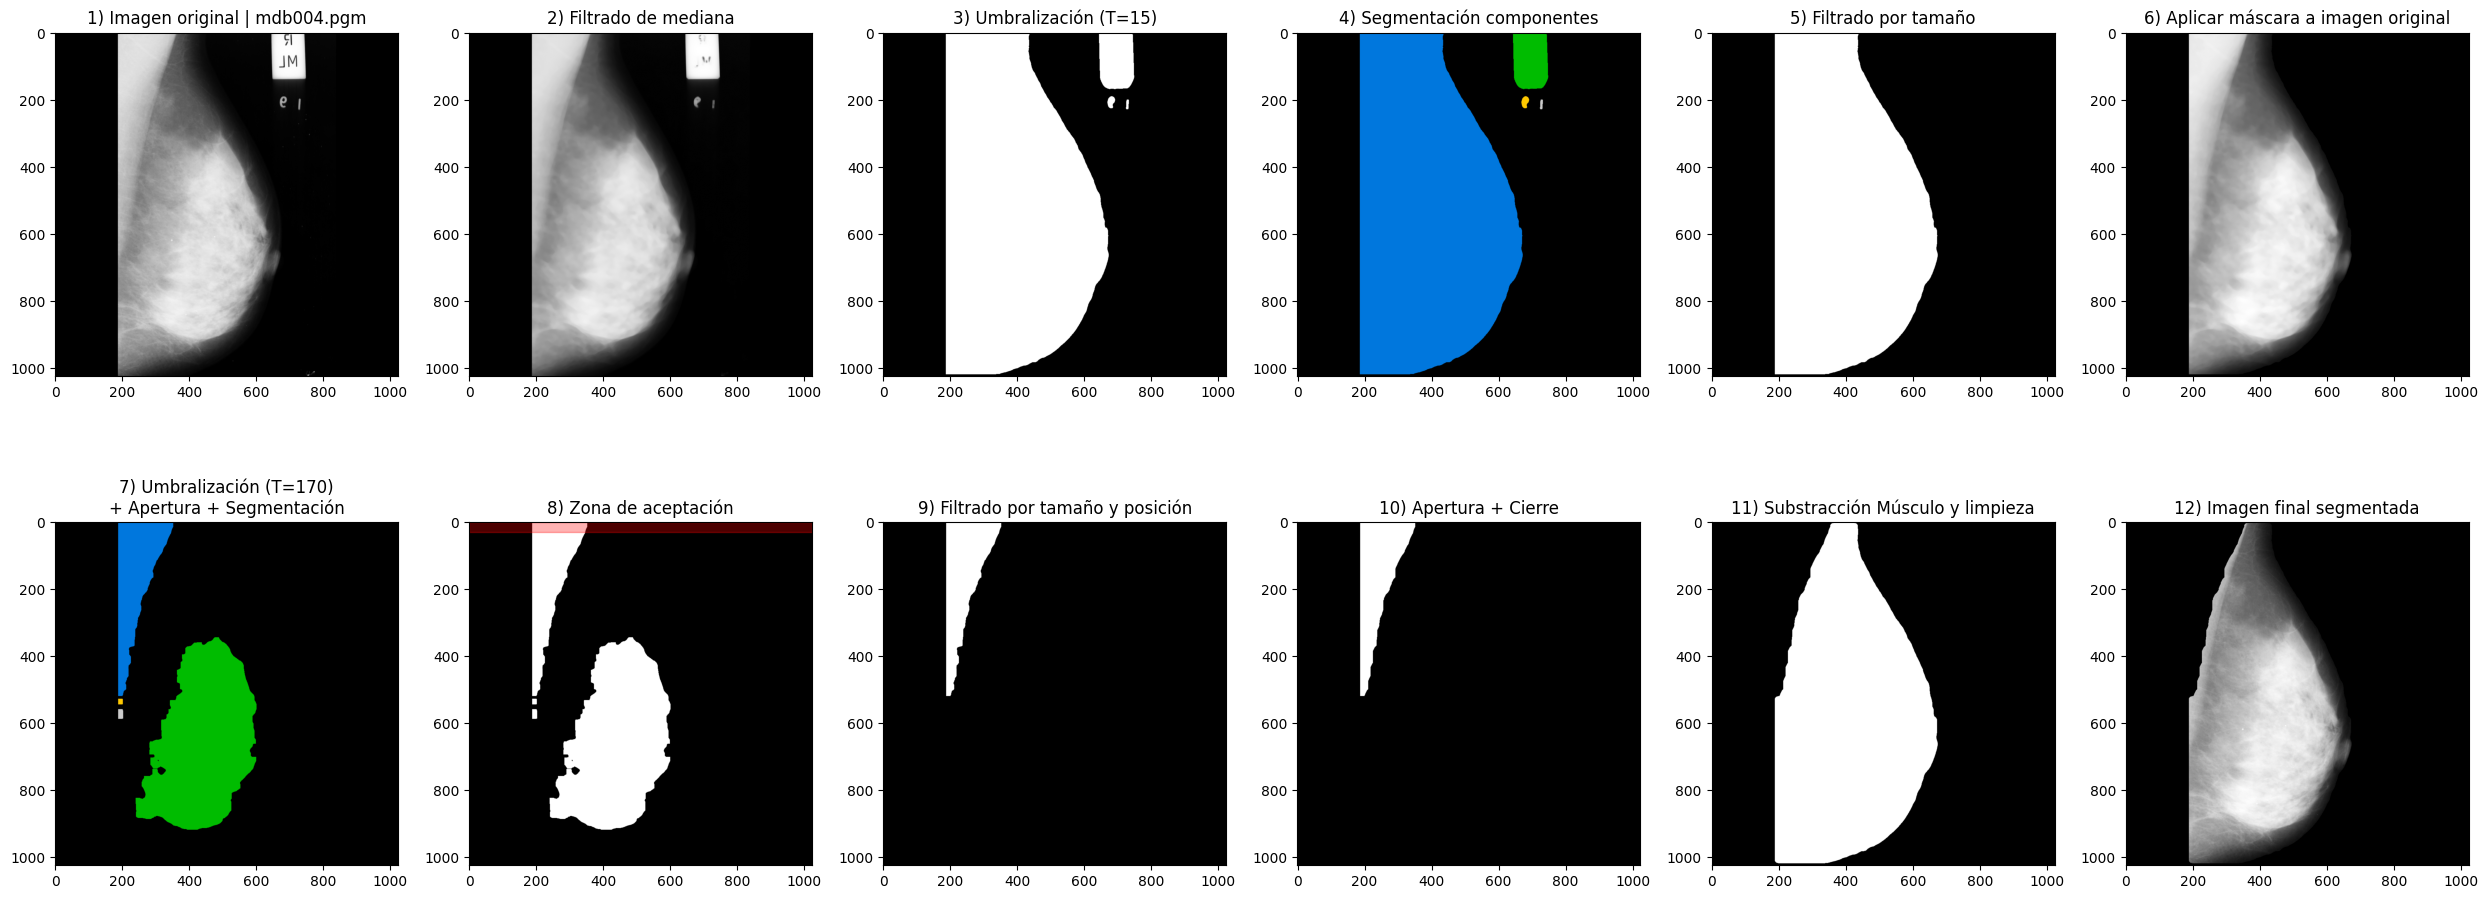

TP=307673 | FP=37051 | FN=113 | IoU=0.8922


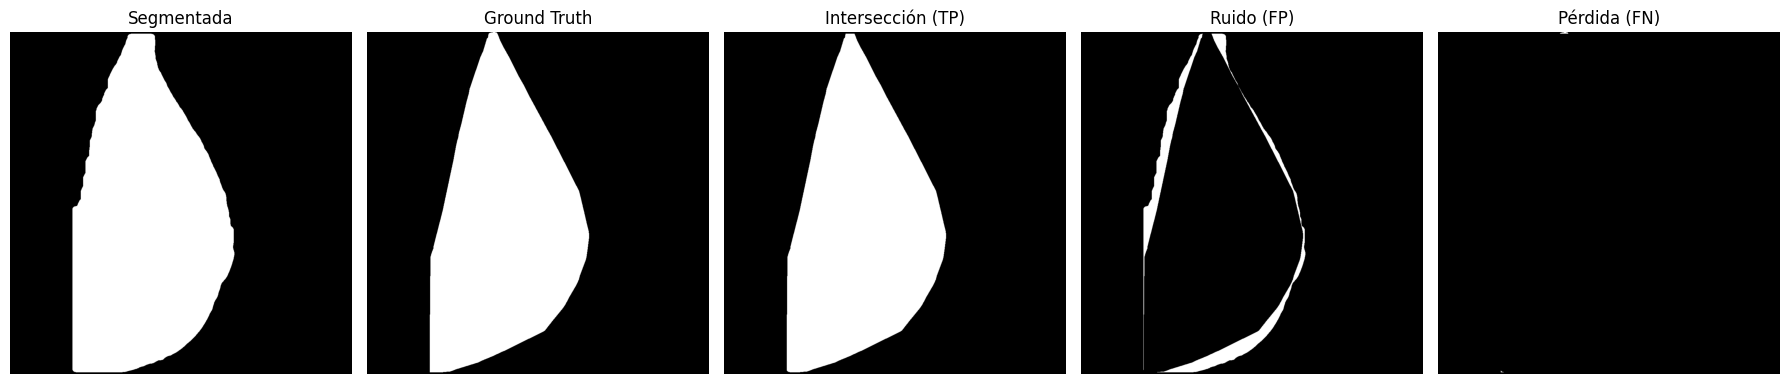

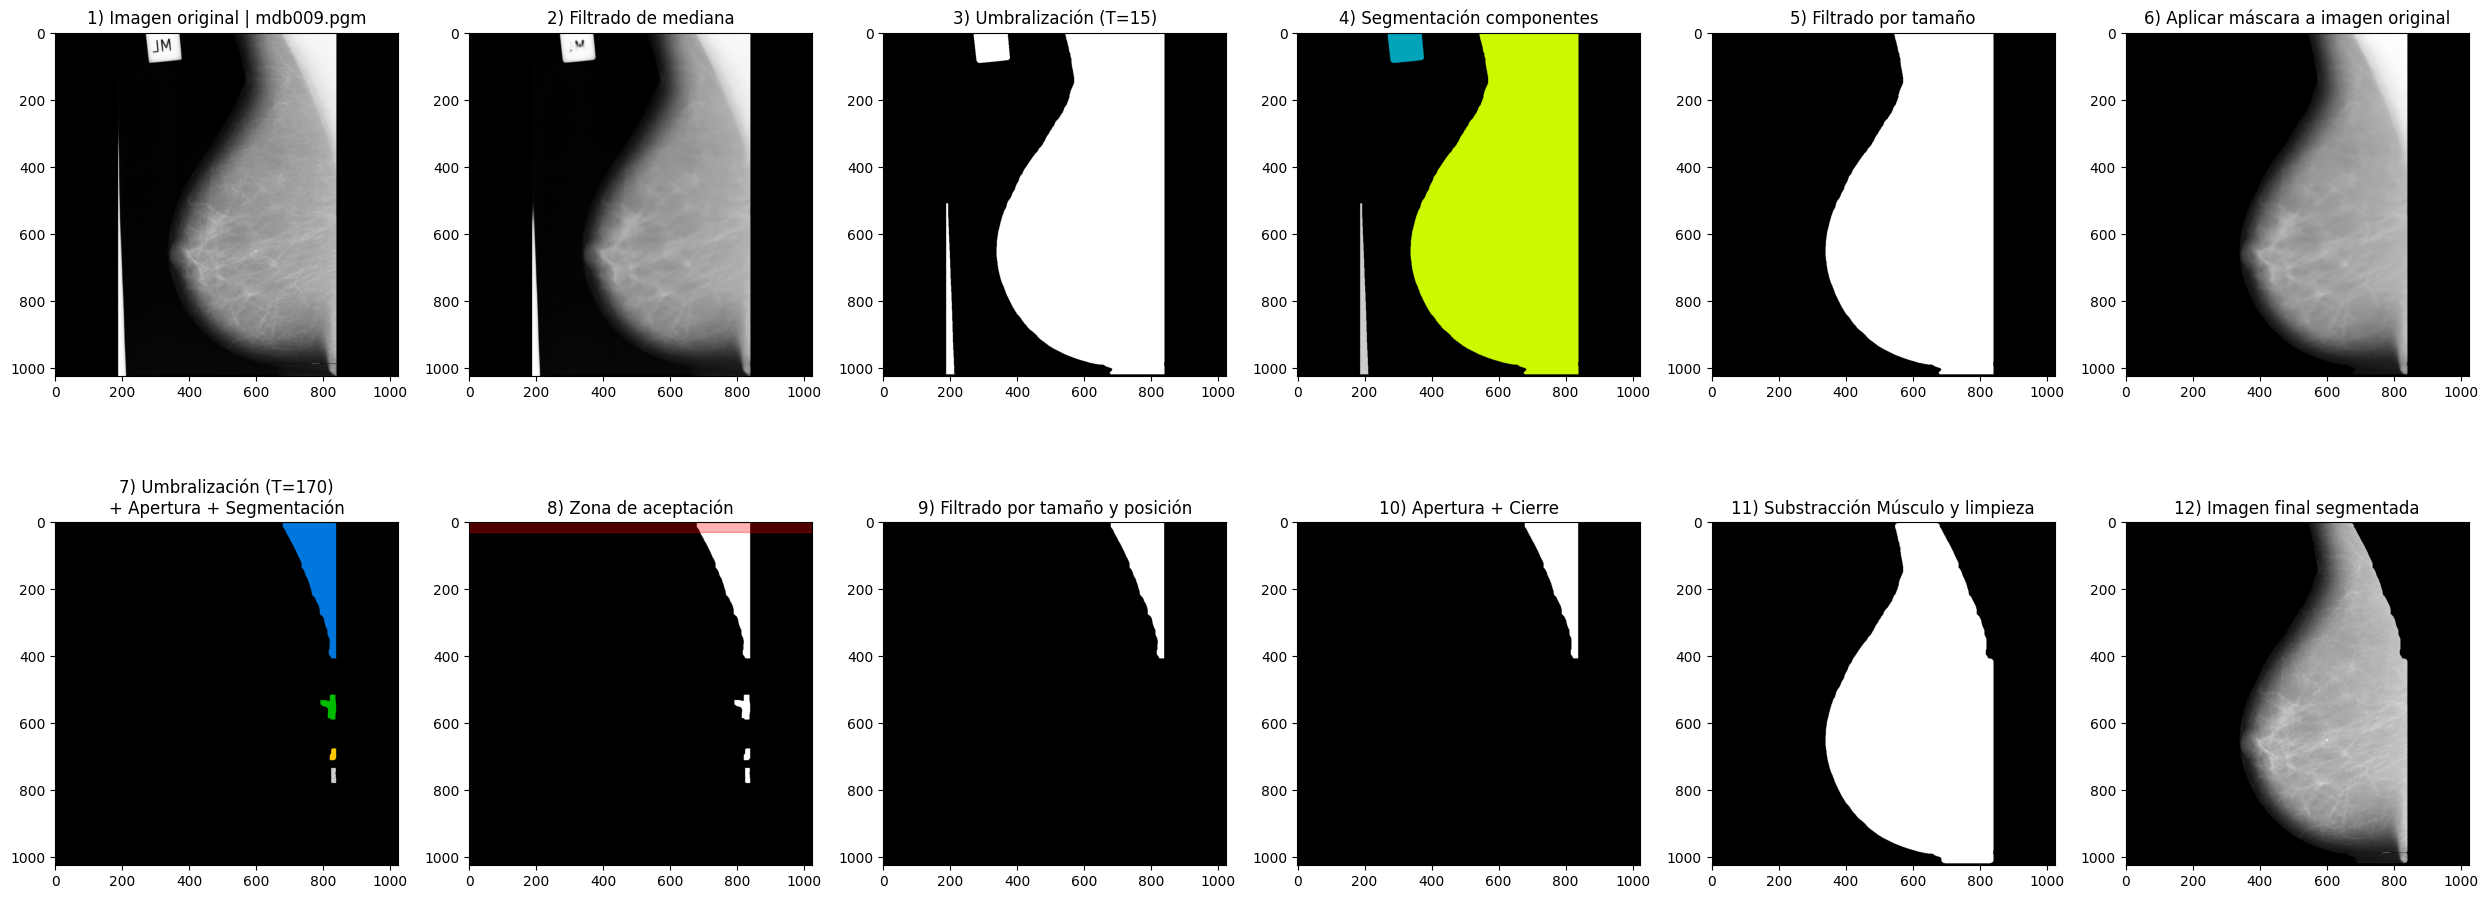

TP=342034 | FP=15489 | FN=5886 | IoU=0.9412


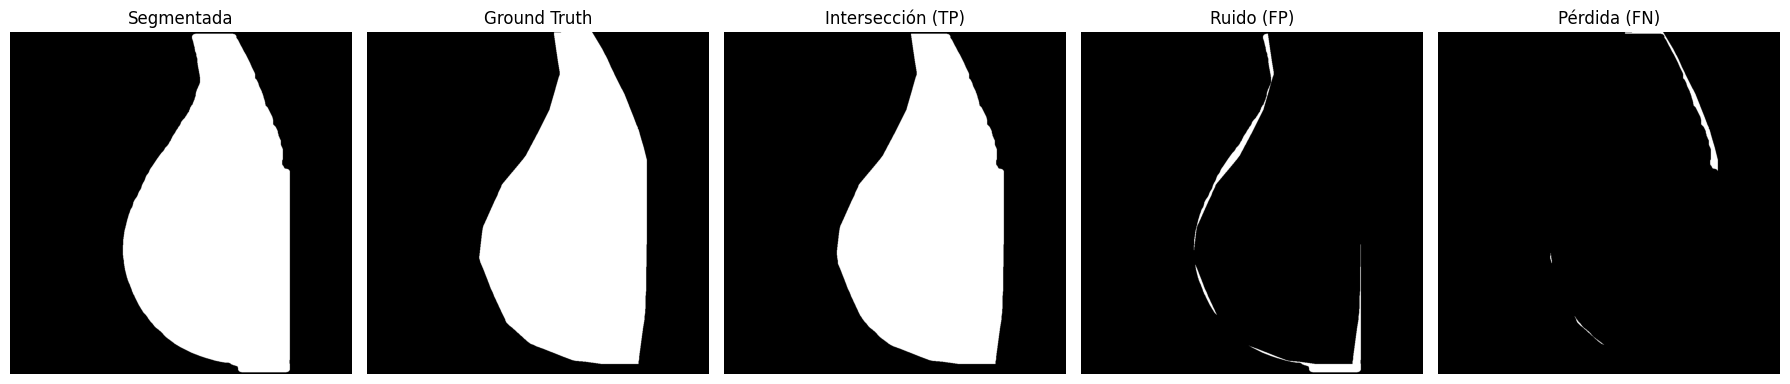

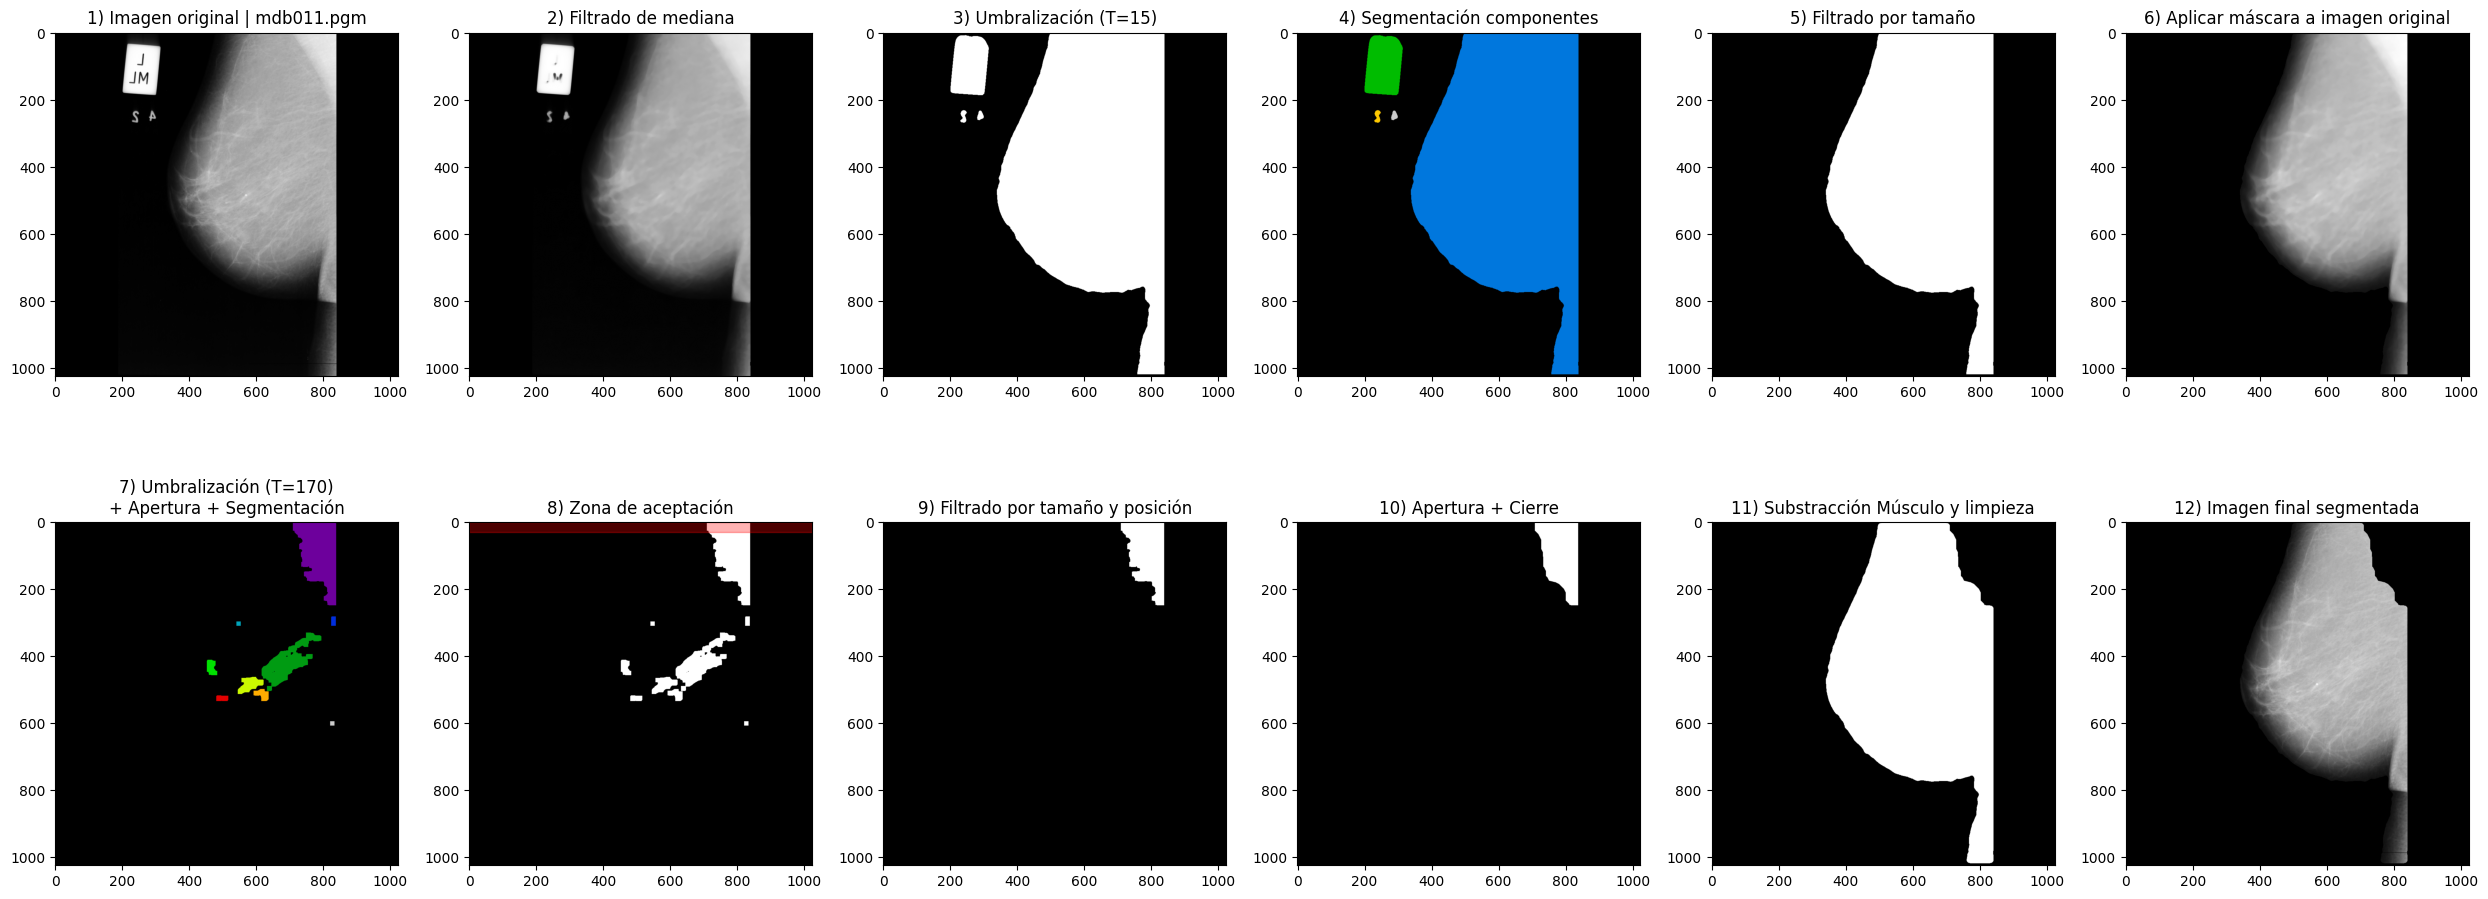

TP=280339 | FP=34475 | FN=10453 | IoU=0.8619


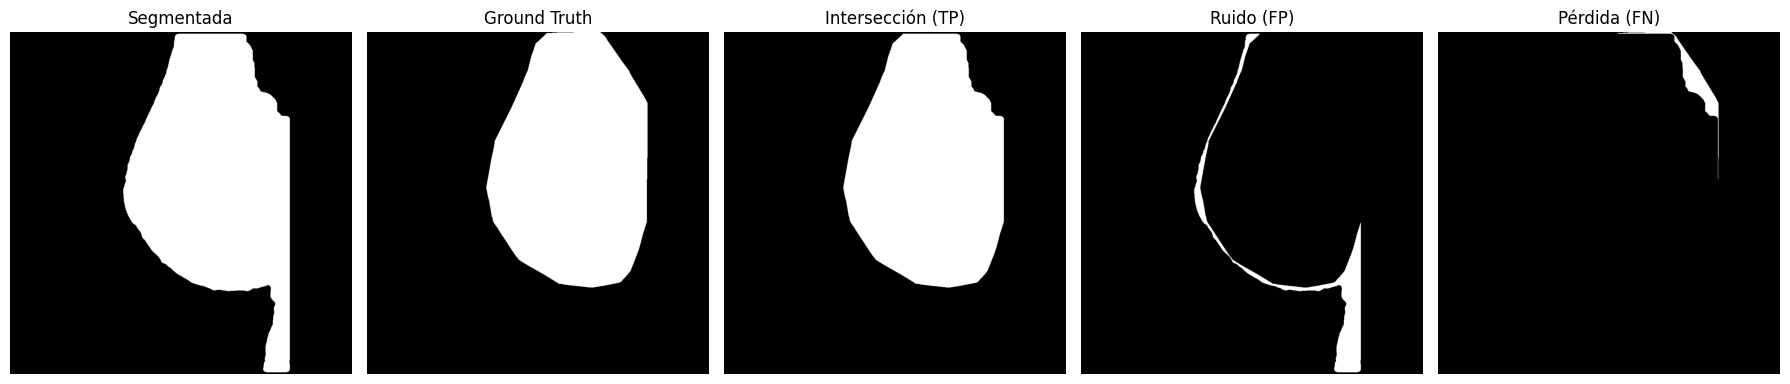

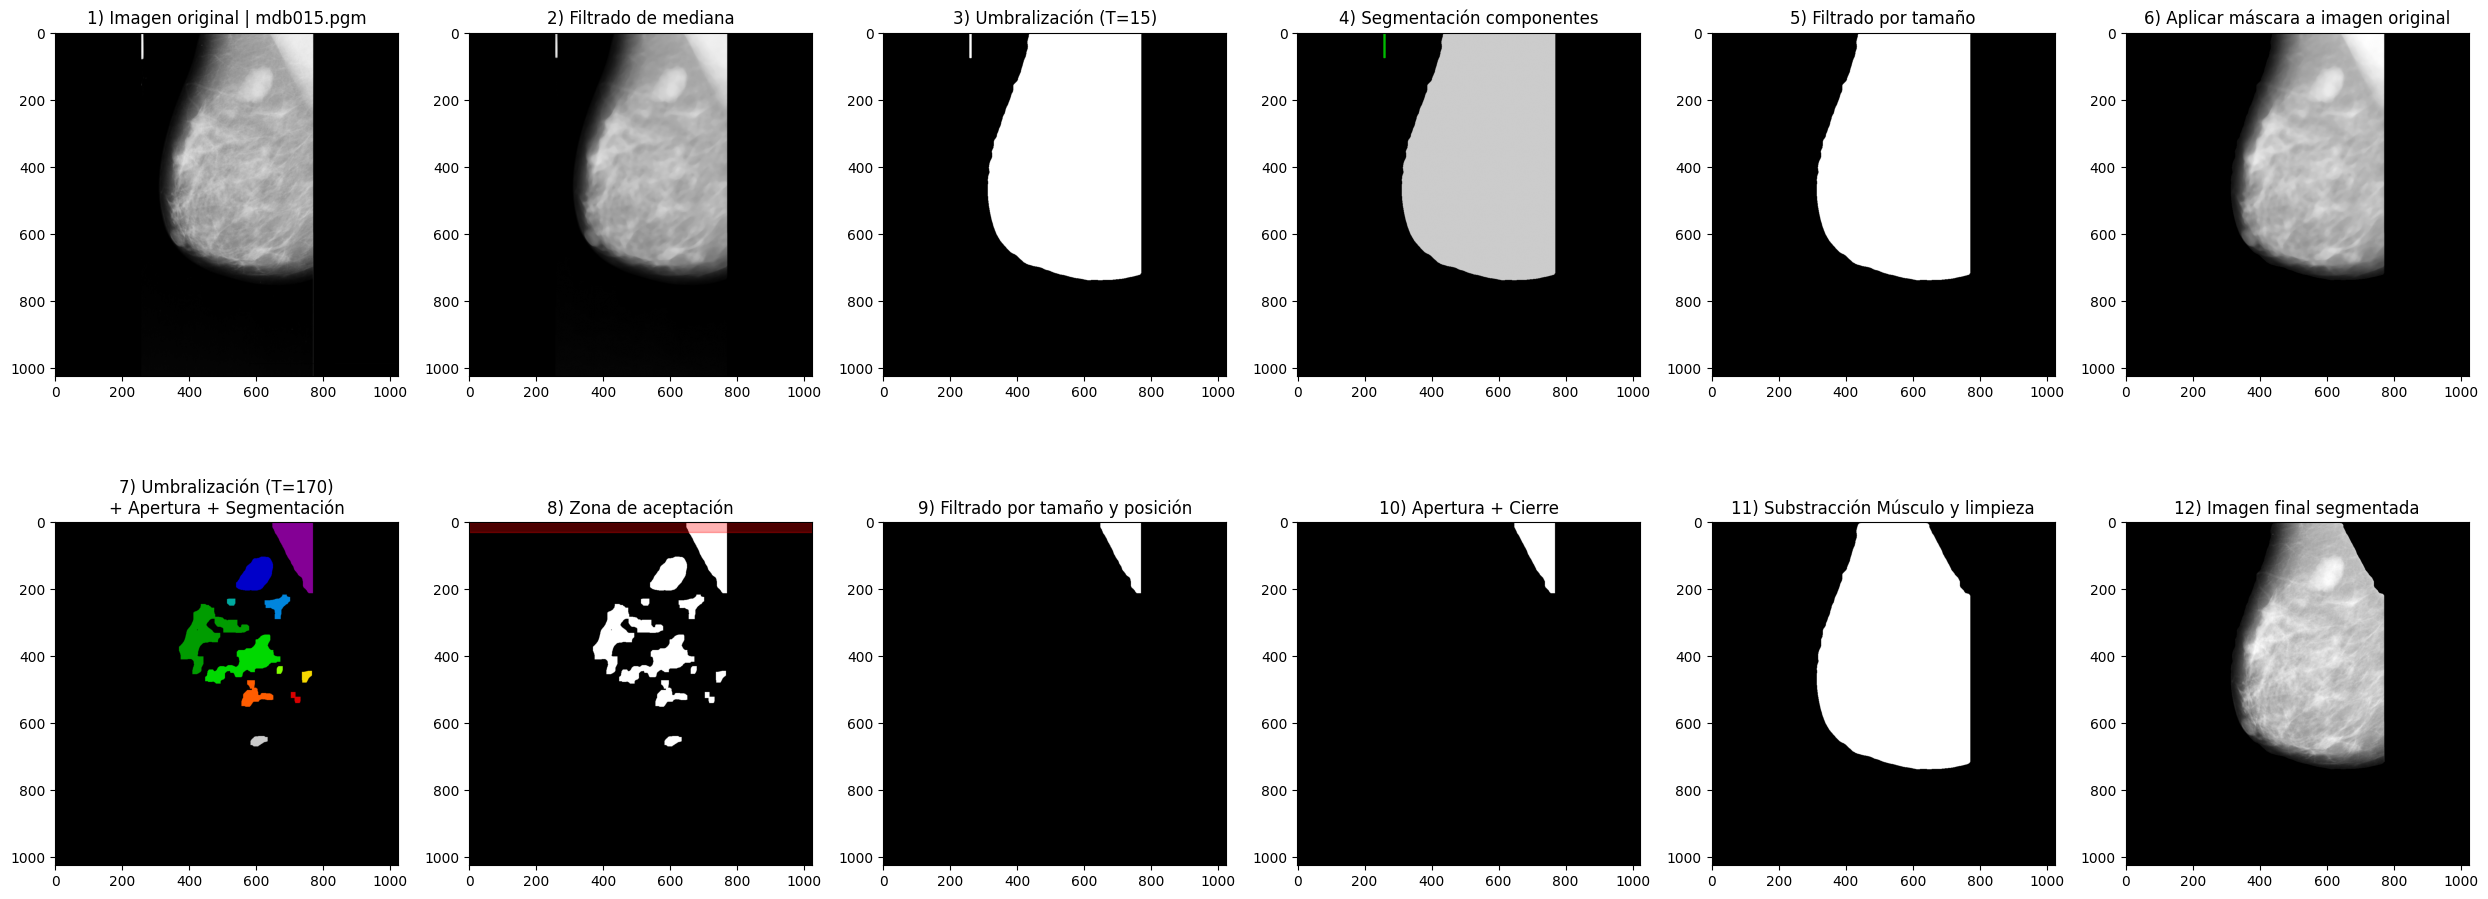

TP=256941 | FP=20159 | FN=2767 | IoU=0.9181


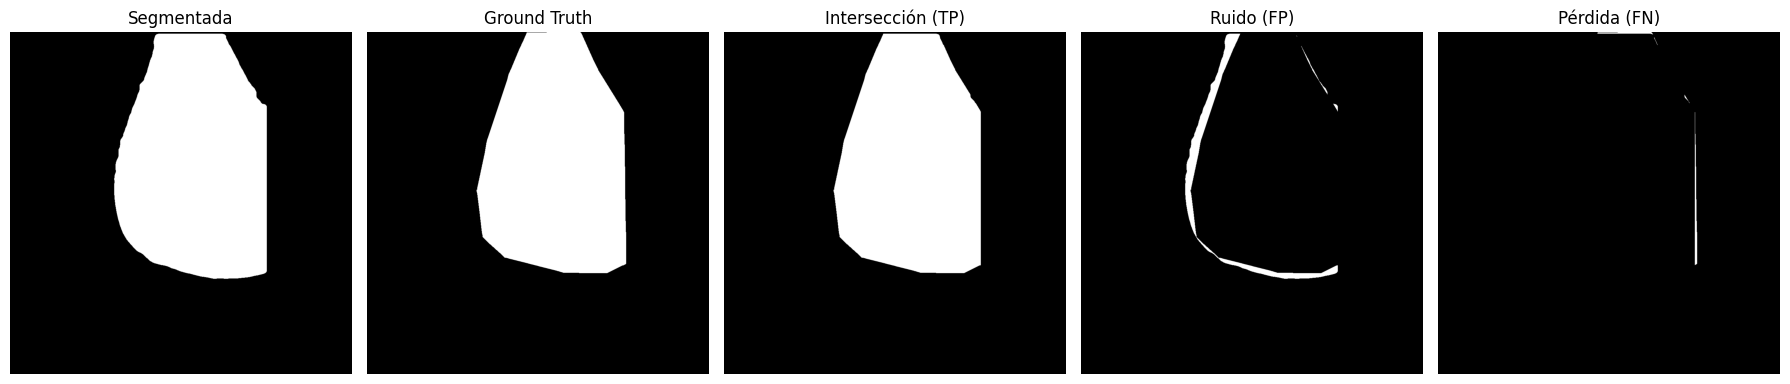

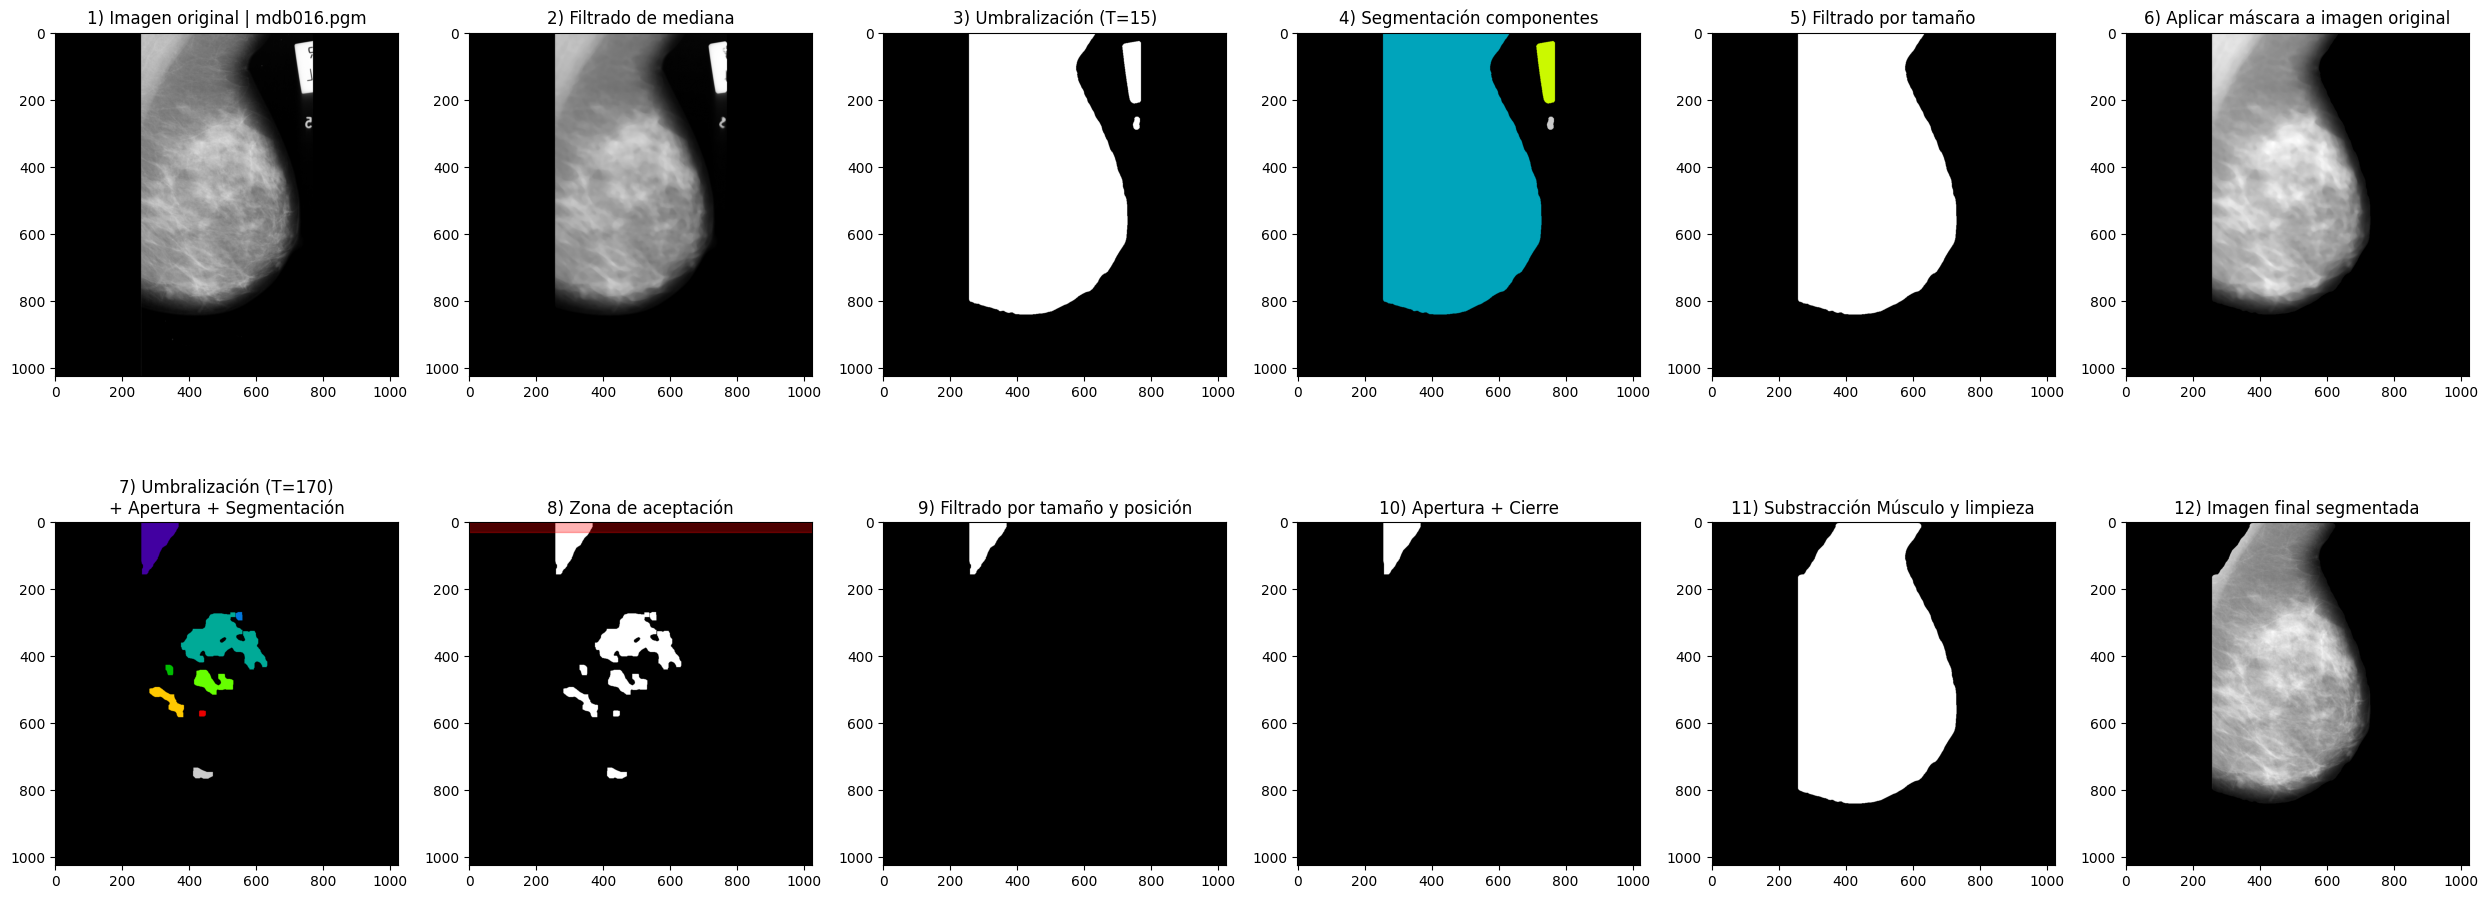

TP=292297 | FP=25940 | FN=1010 | IoU=0.9156


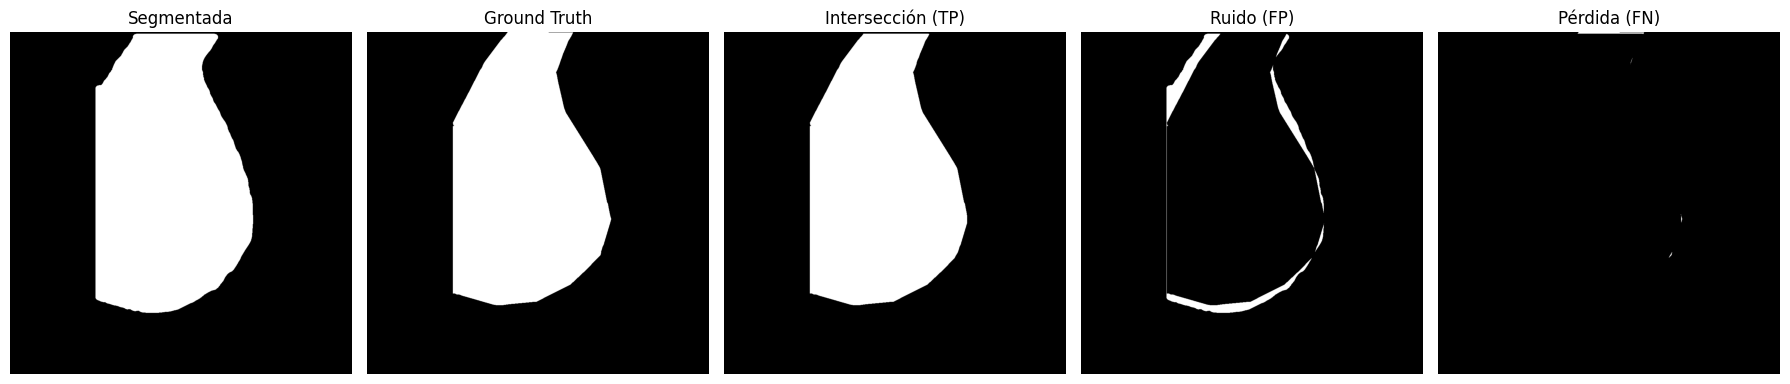

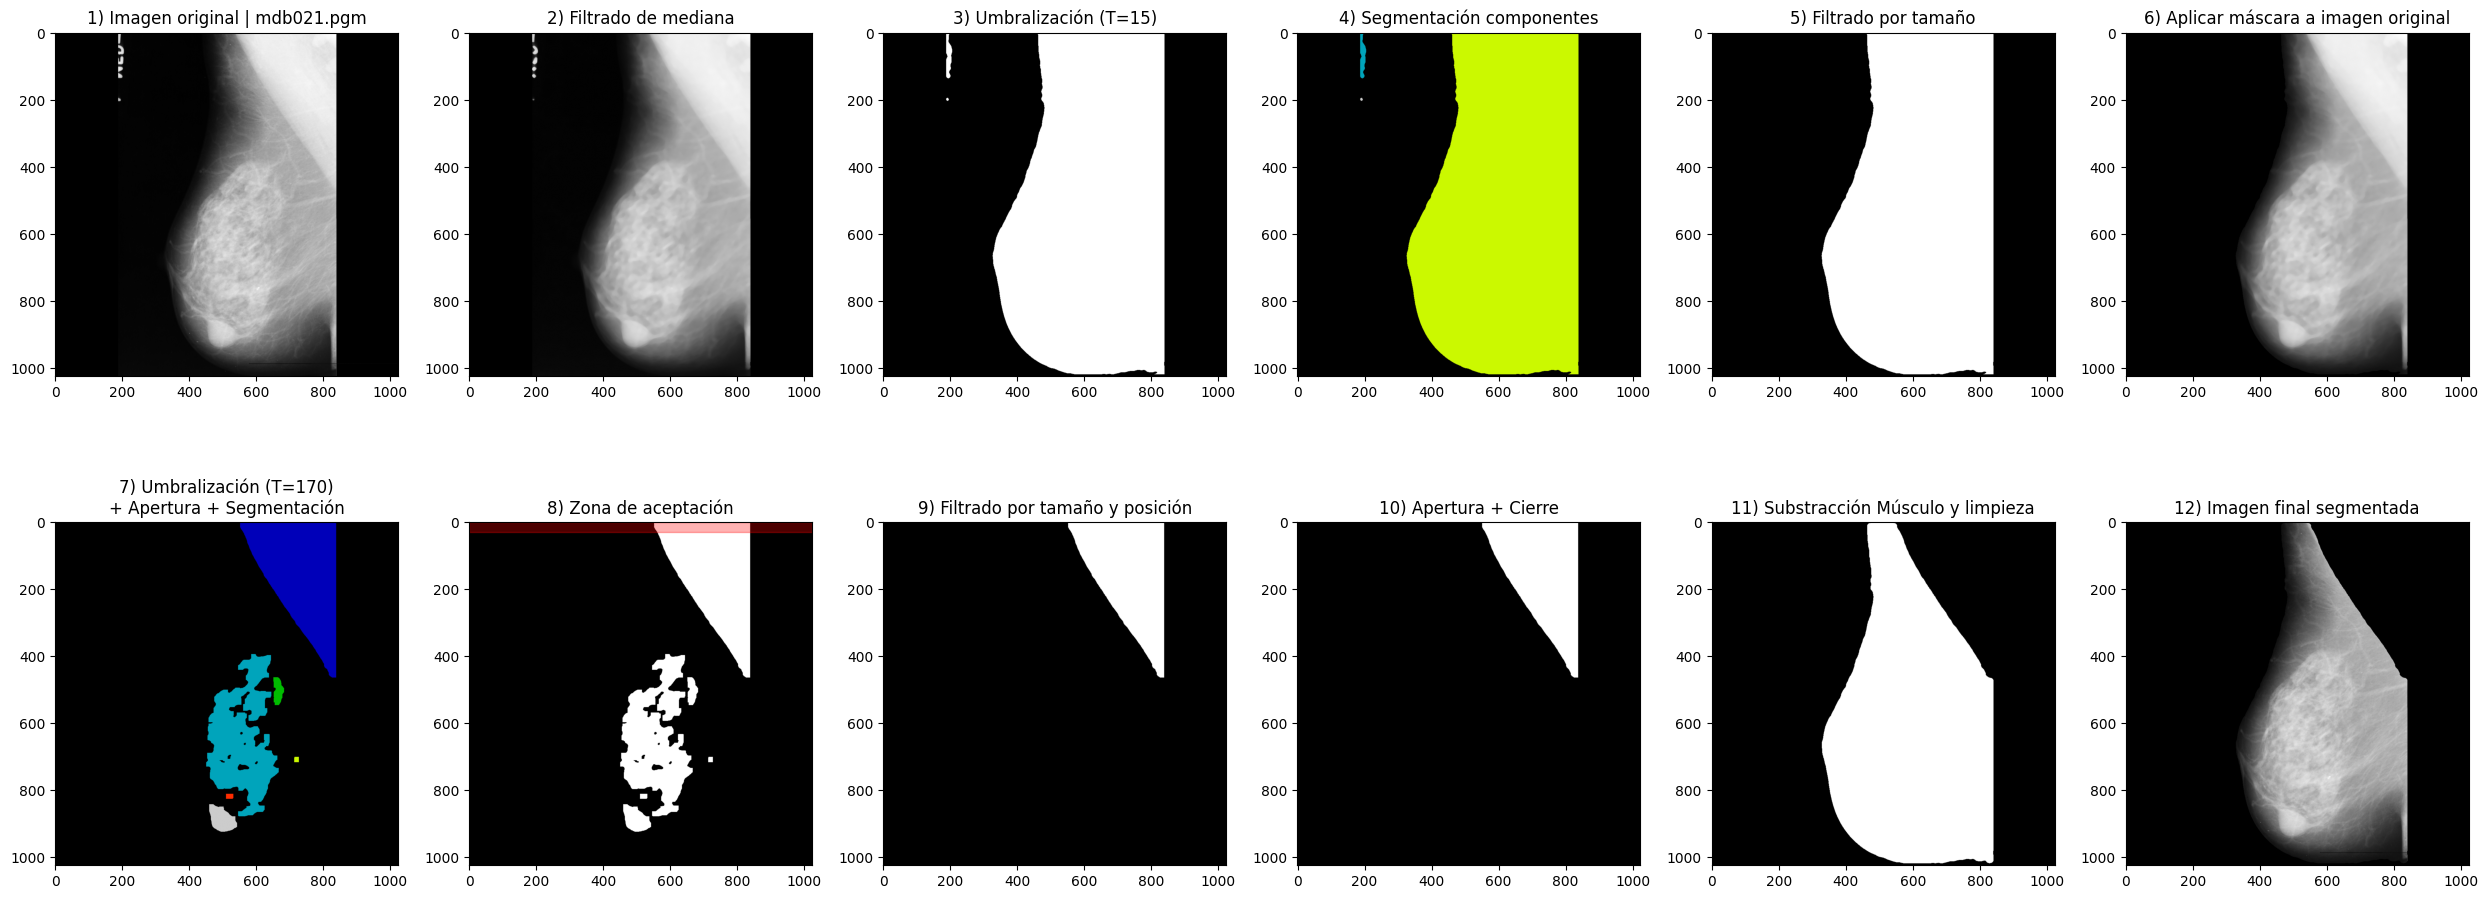

TP=320212 | FP=35090 | FN=638 | IoU=0.8996


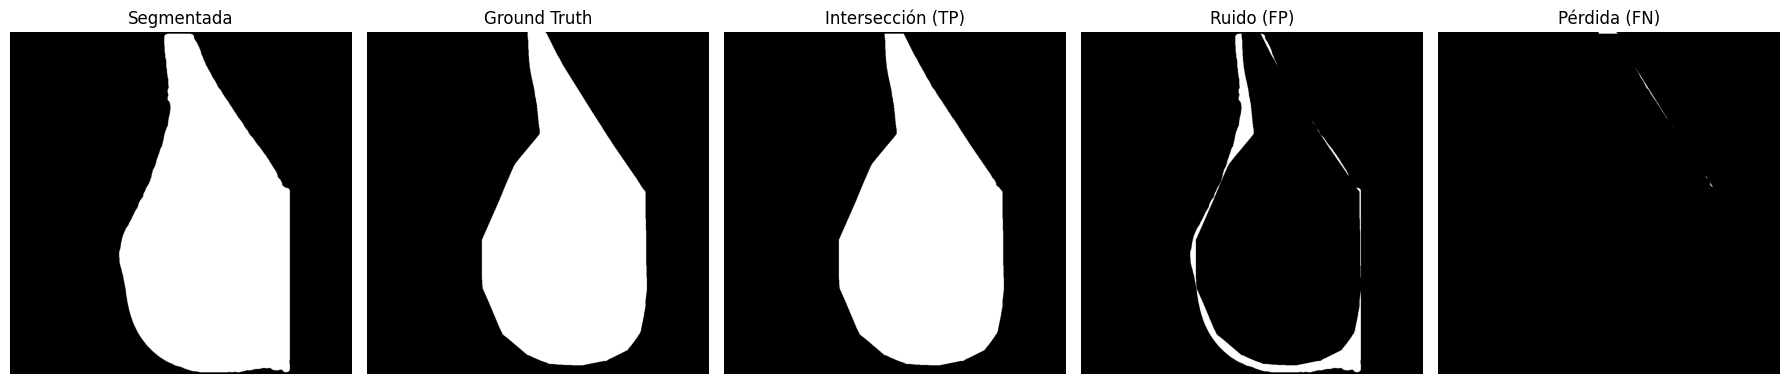

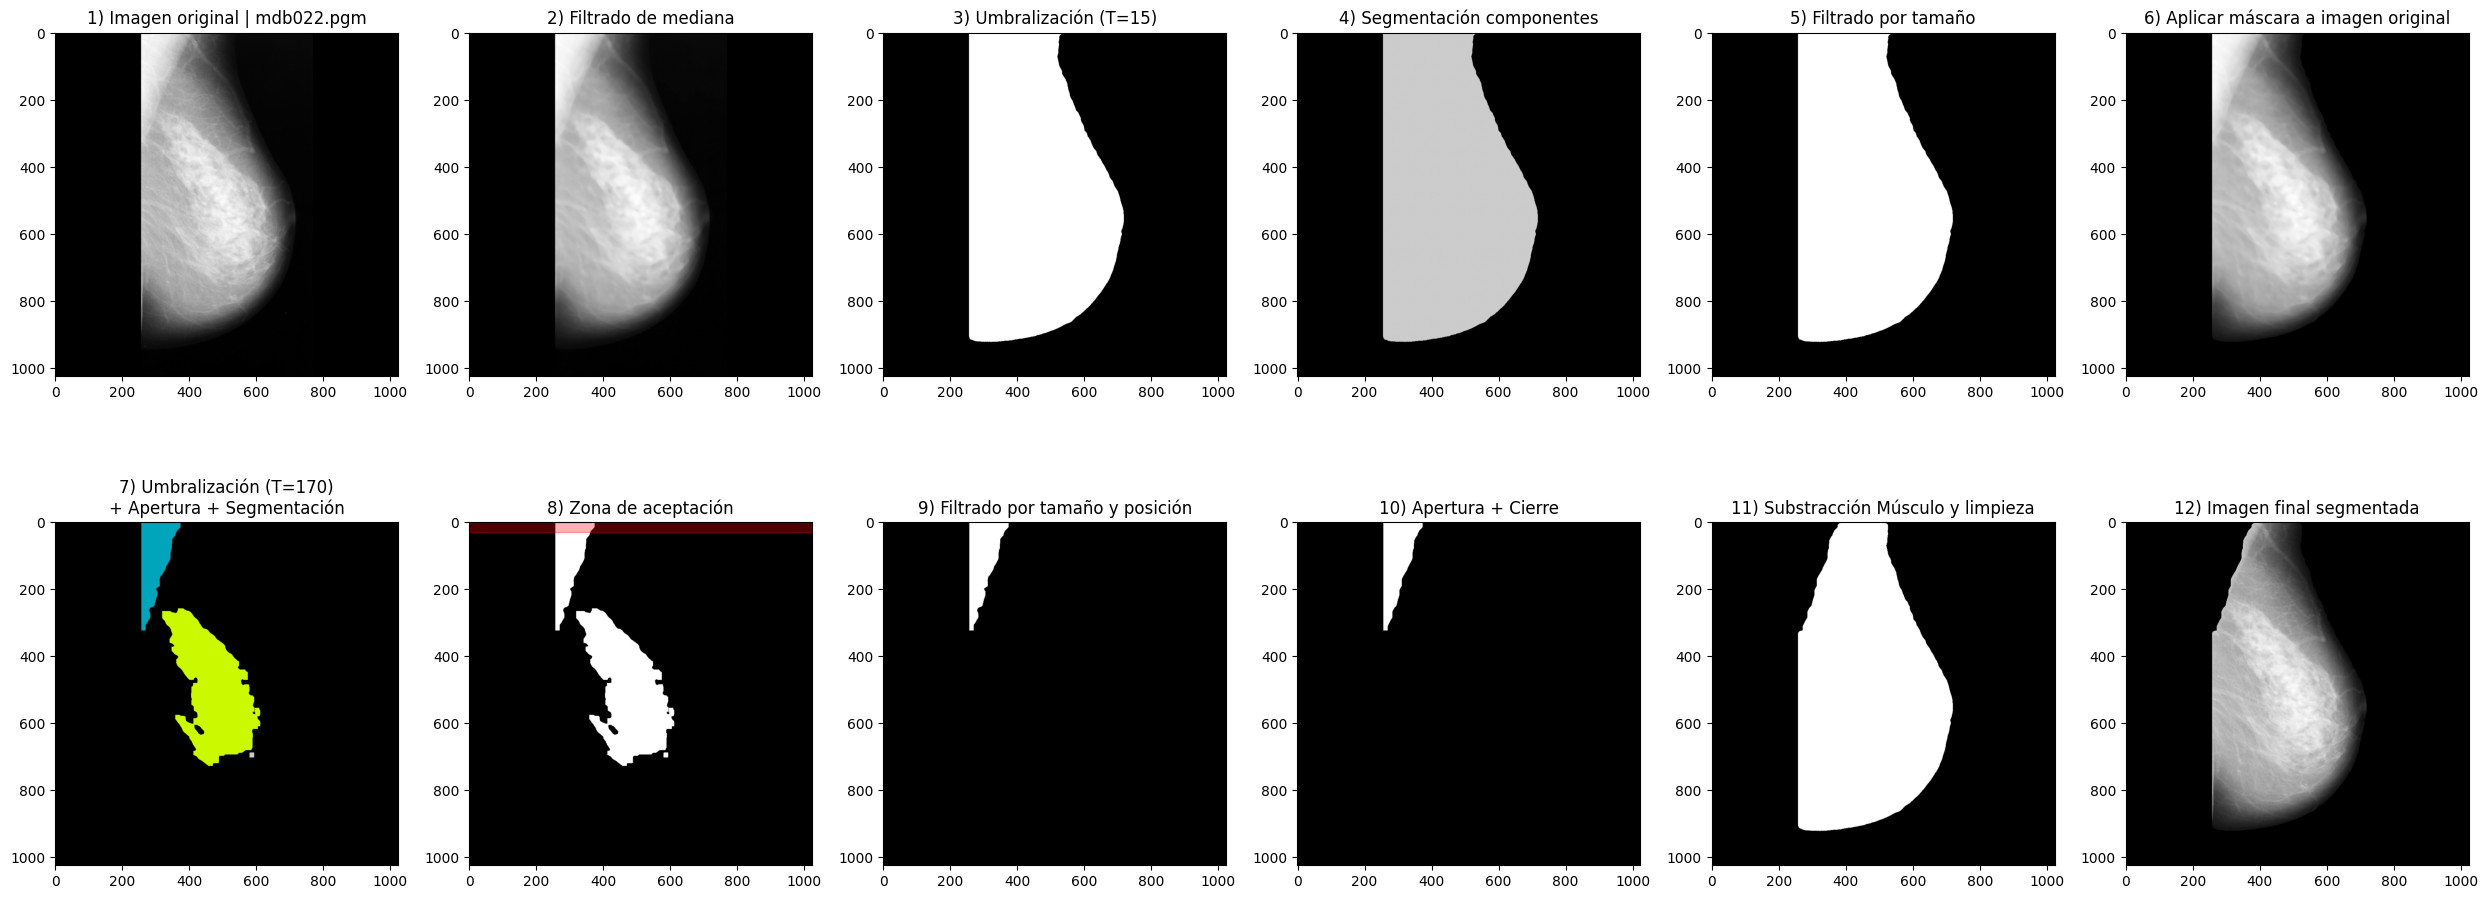

TP=294681 | FP=17366 | FN=1574 | IoU=0.9396


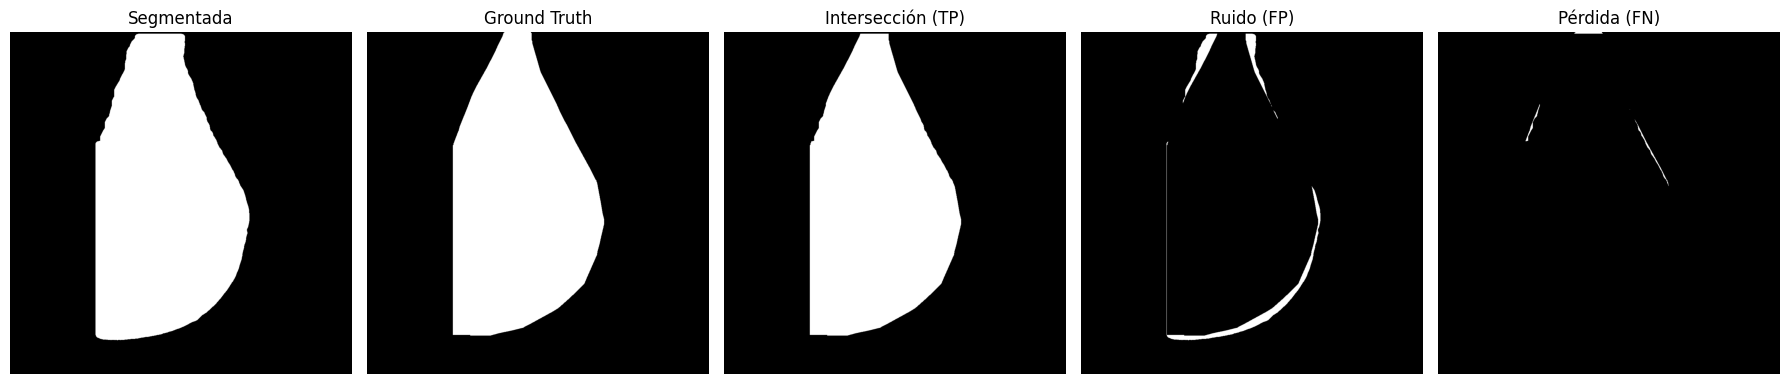

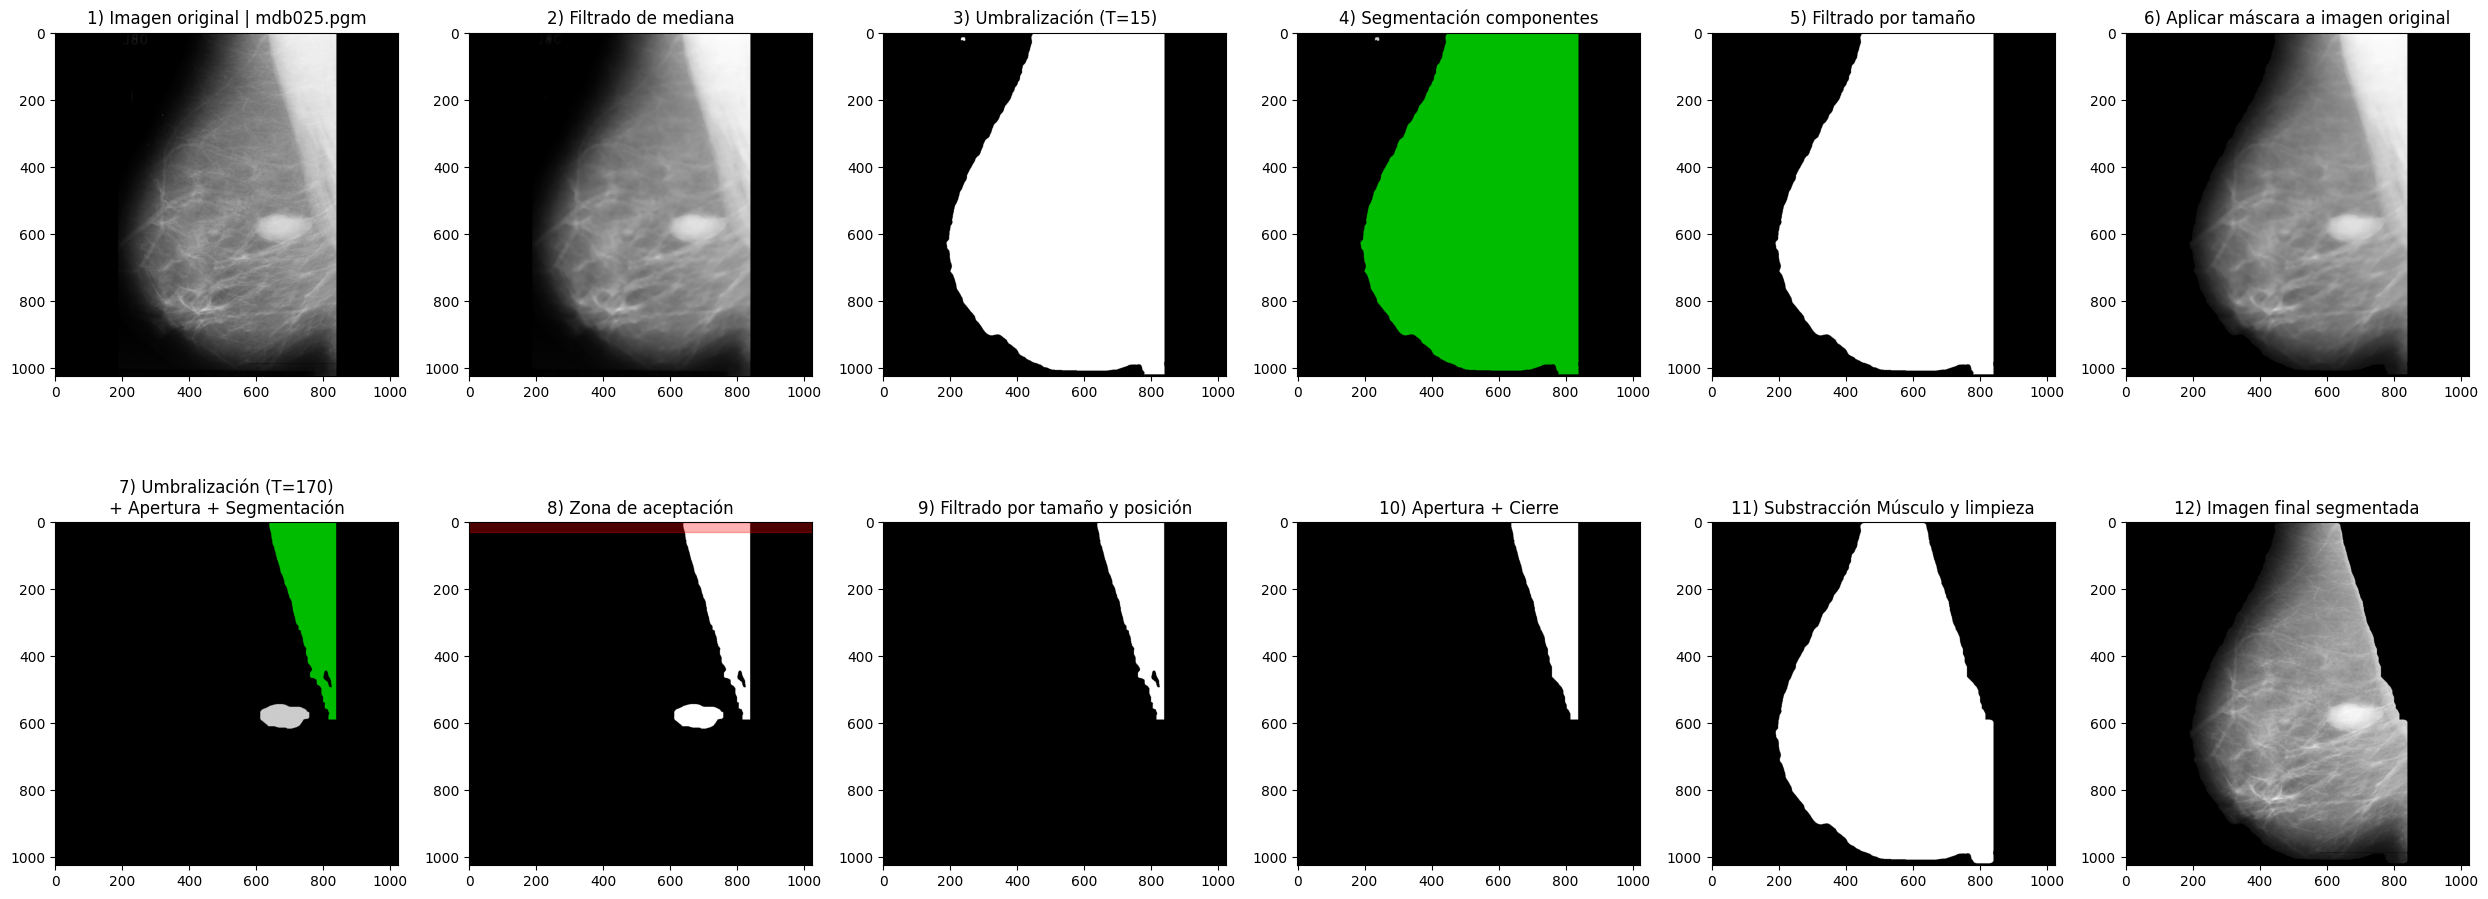

TP=428945 | FP=37797 | FN=1559 | IoU=0.9160


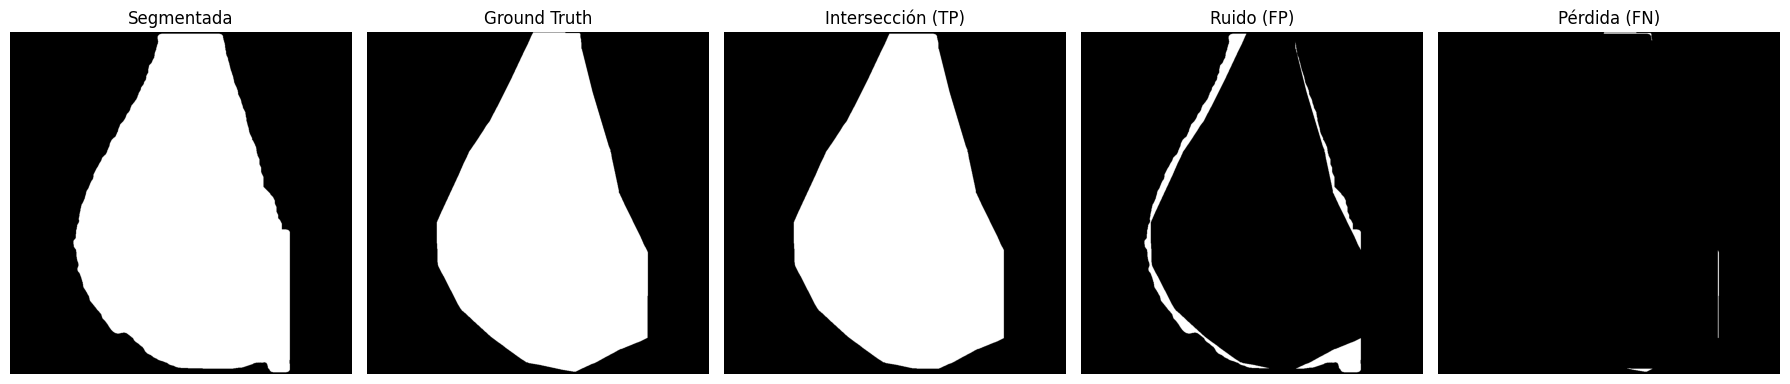

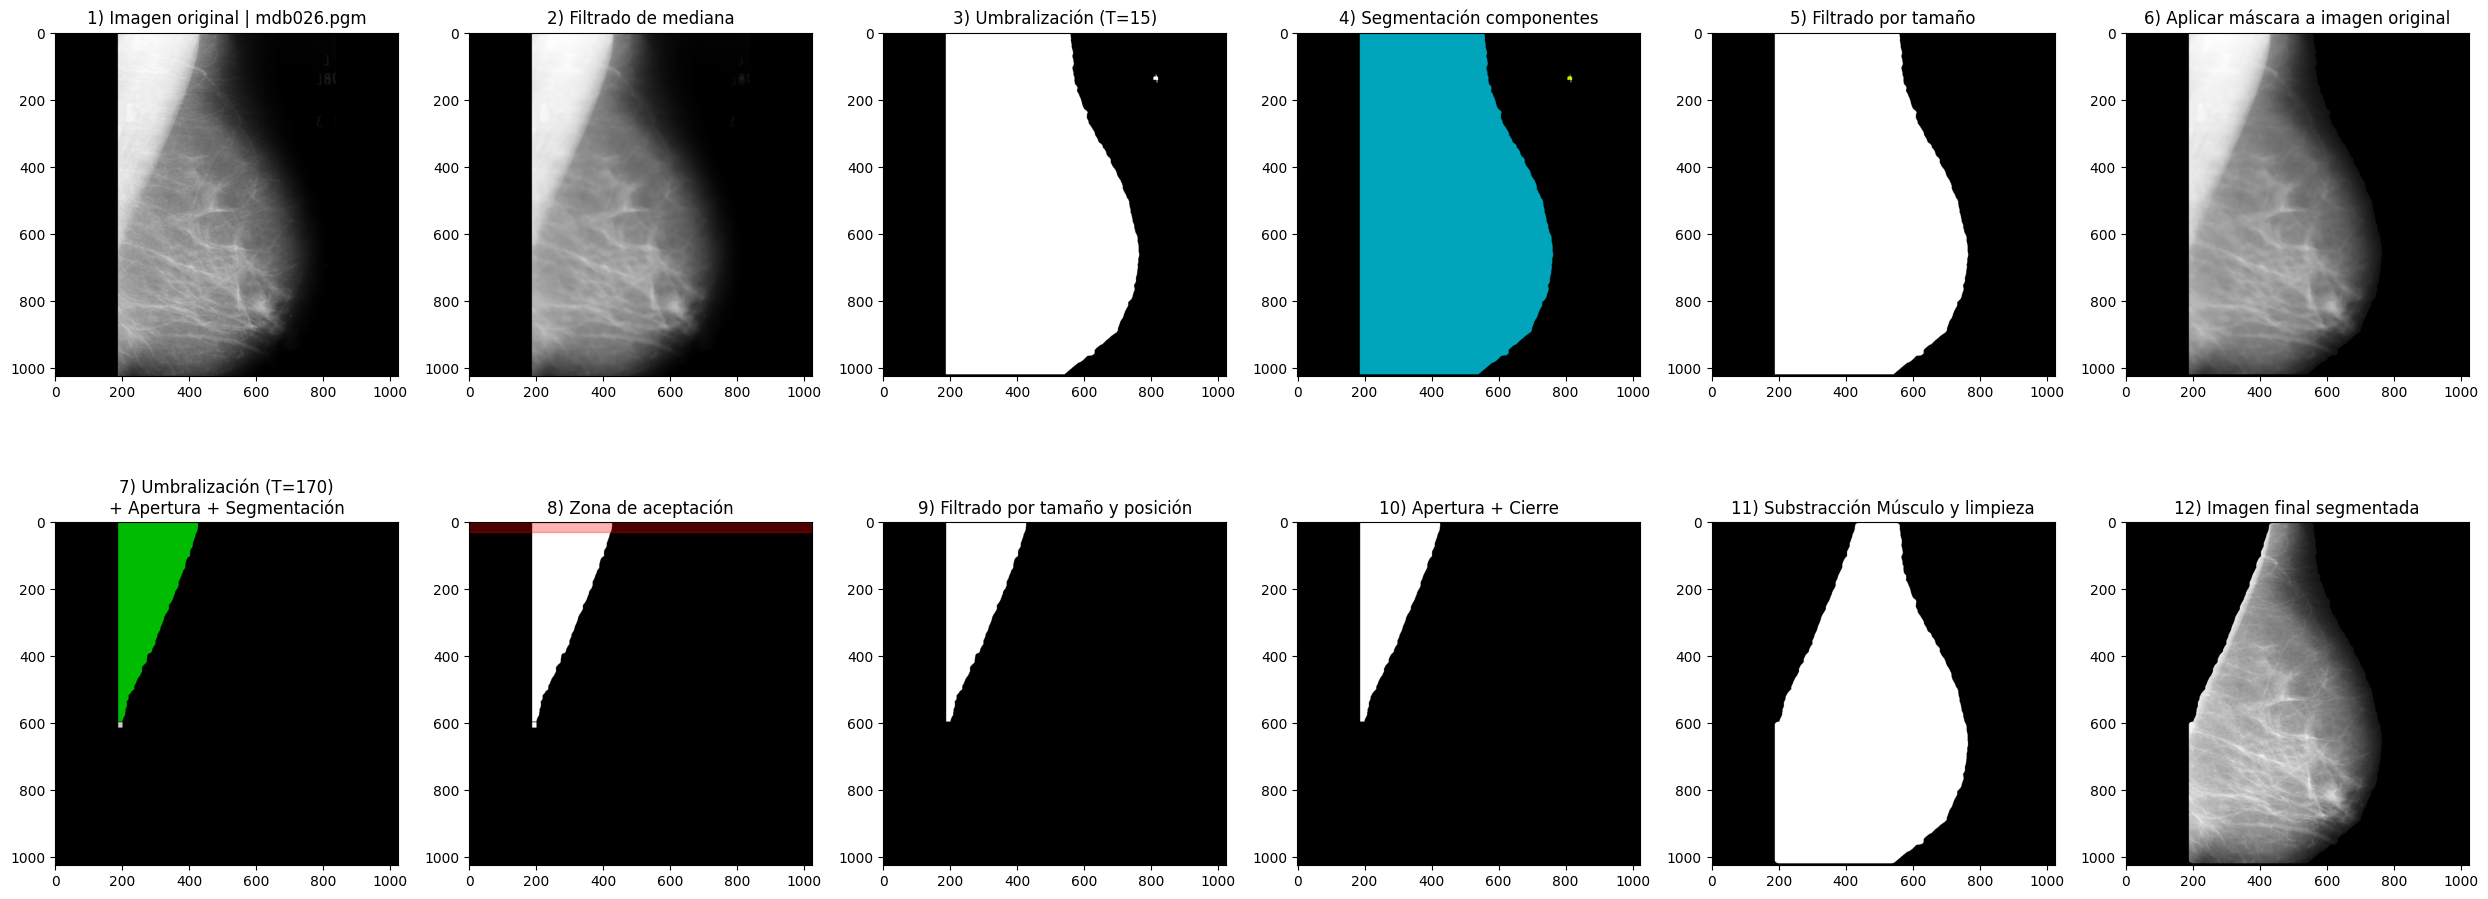

TP=376125 | FP=34175 | FN=1286 | IoU=0.9138


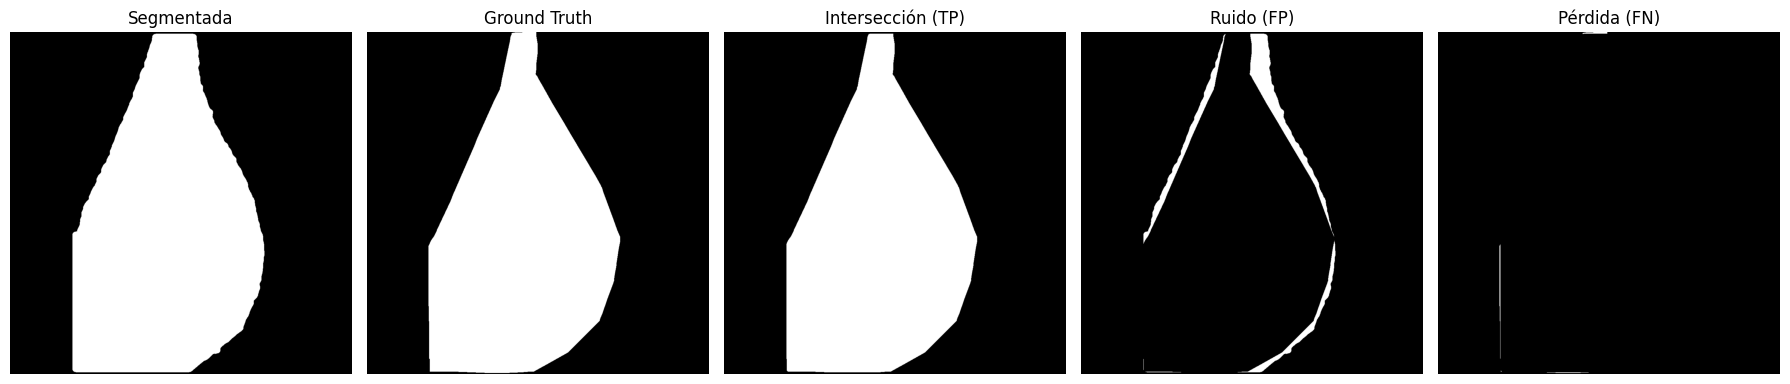

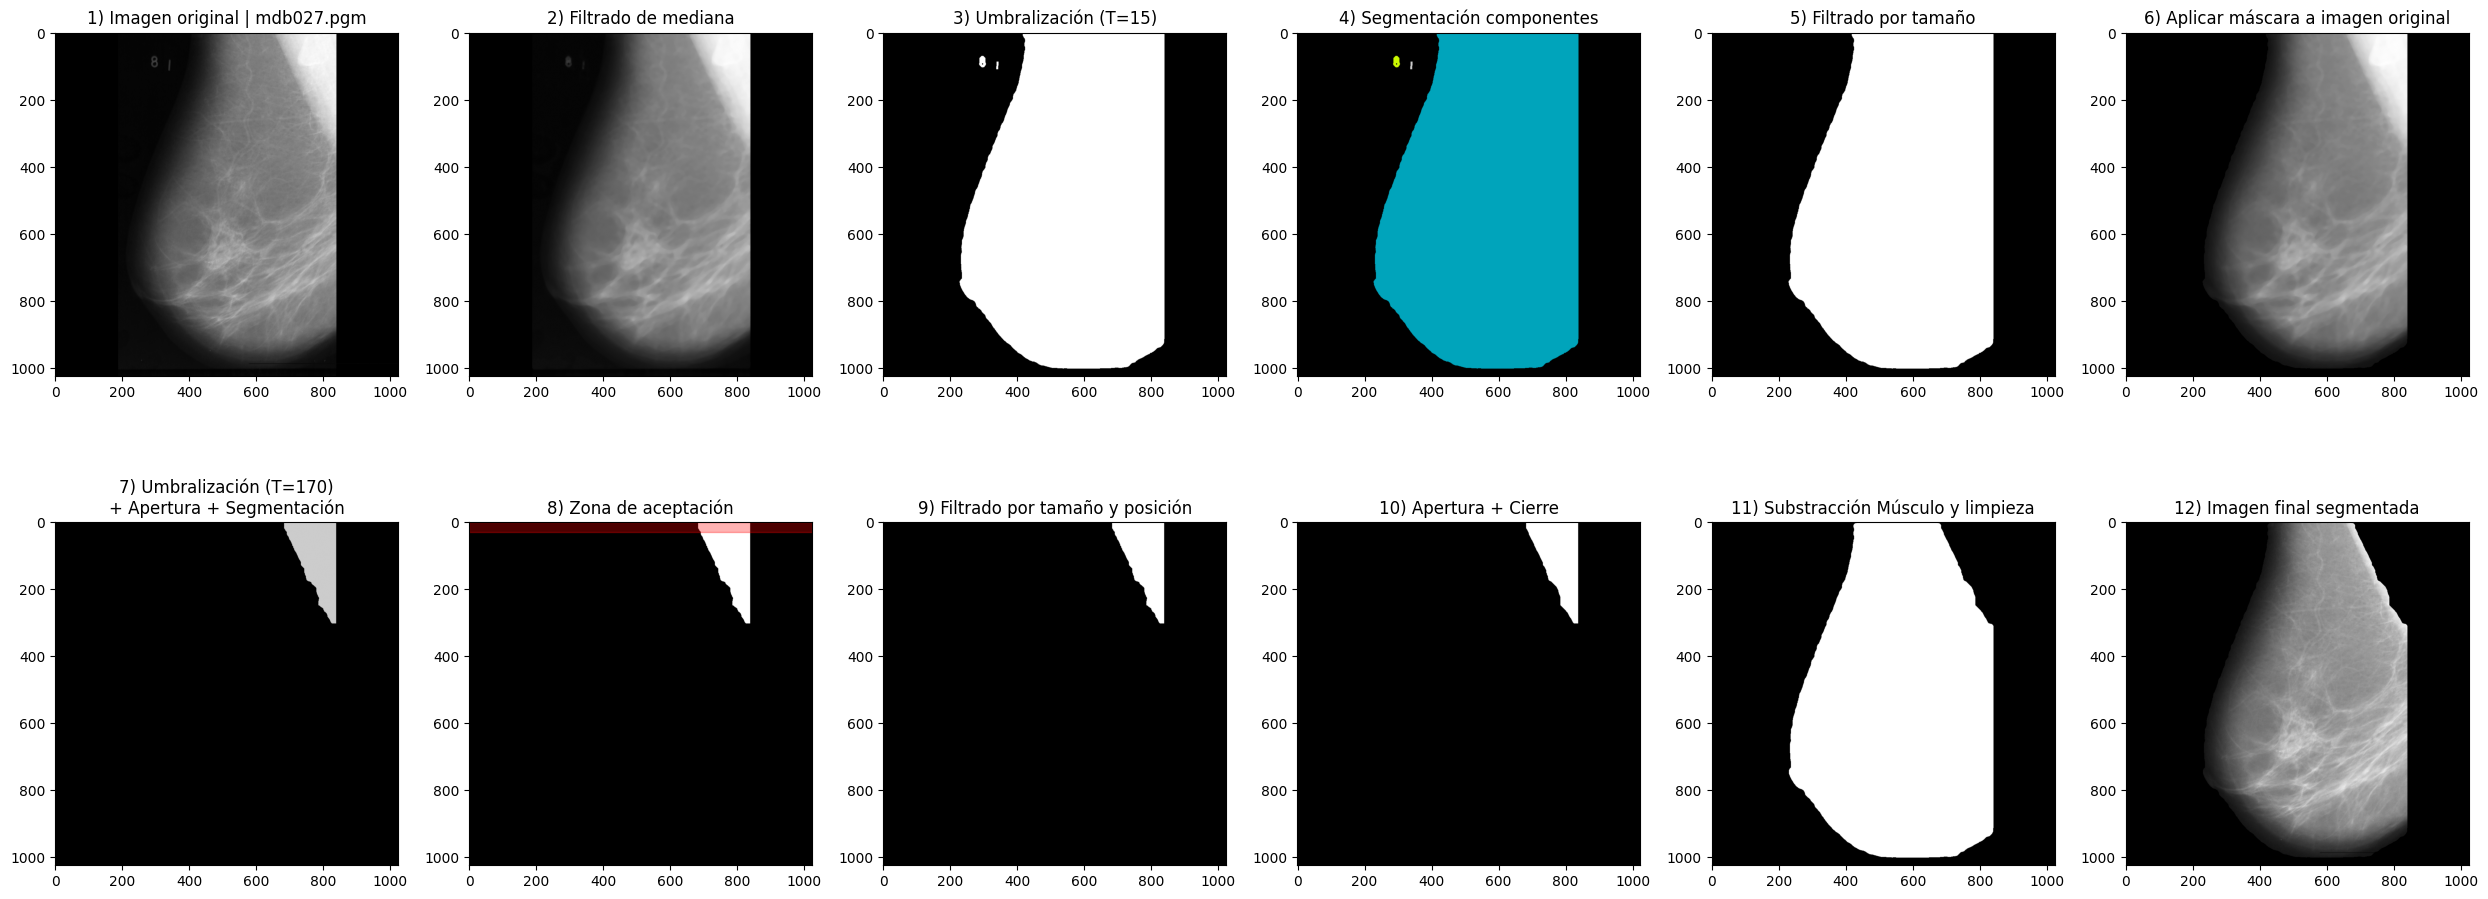

TP=444834 | FP=36694 | FN=955 | IoU=0.9220


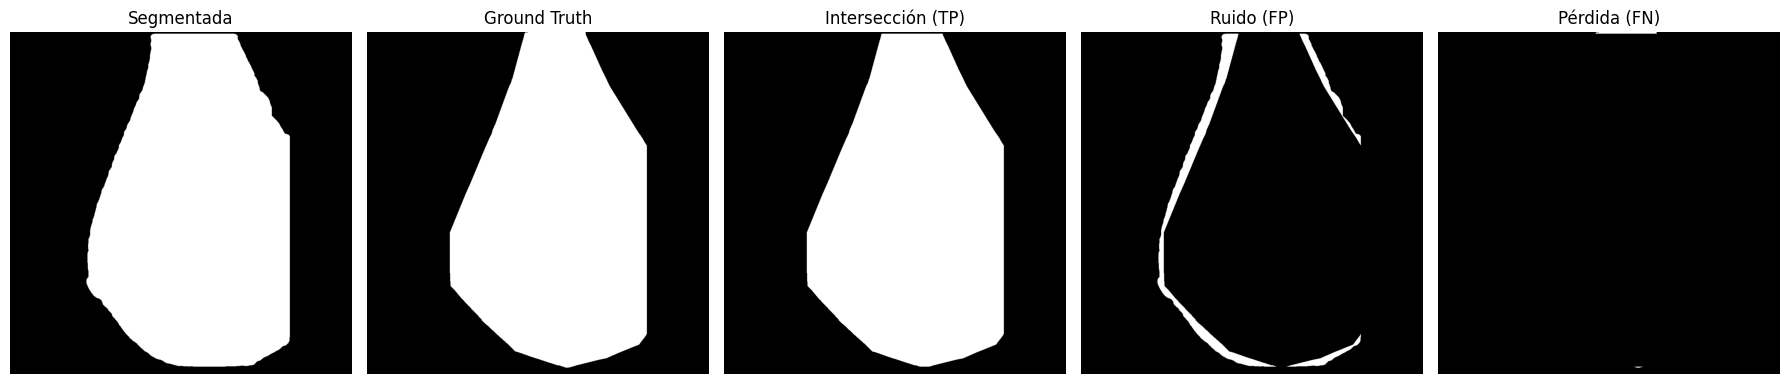

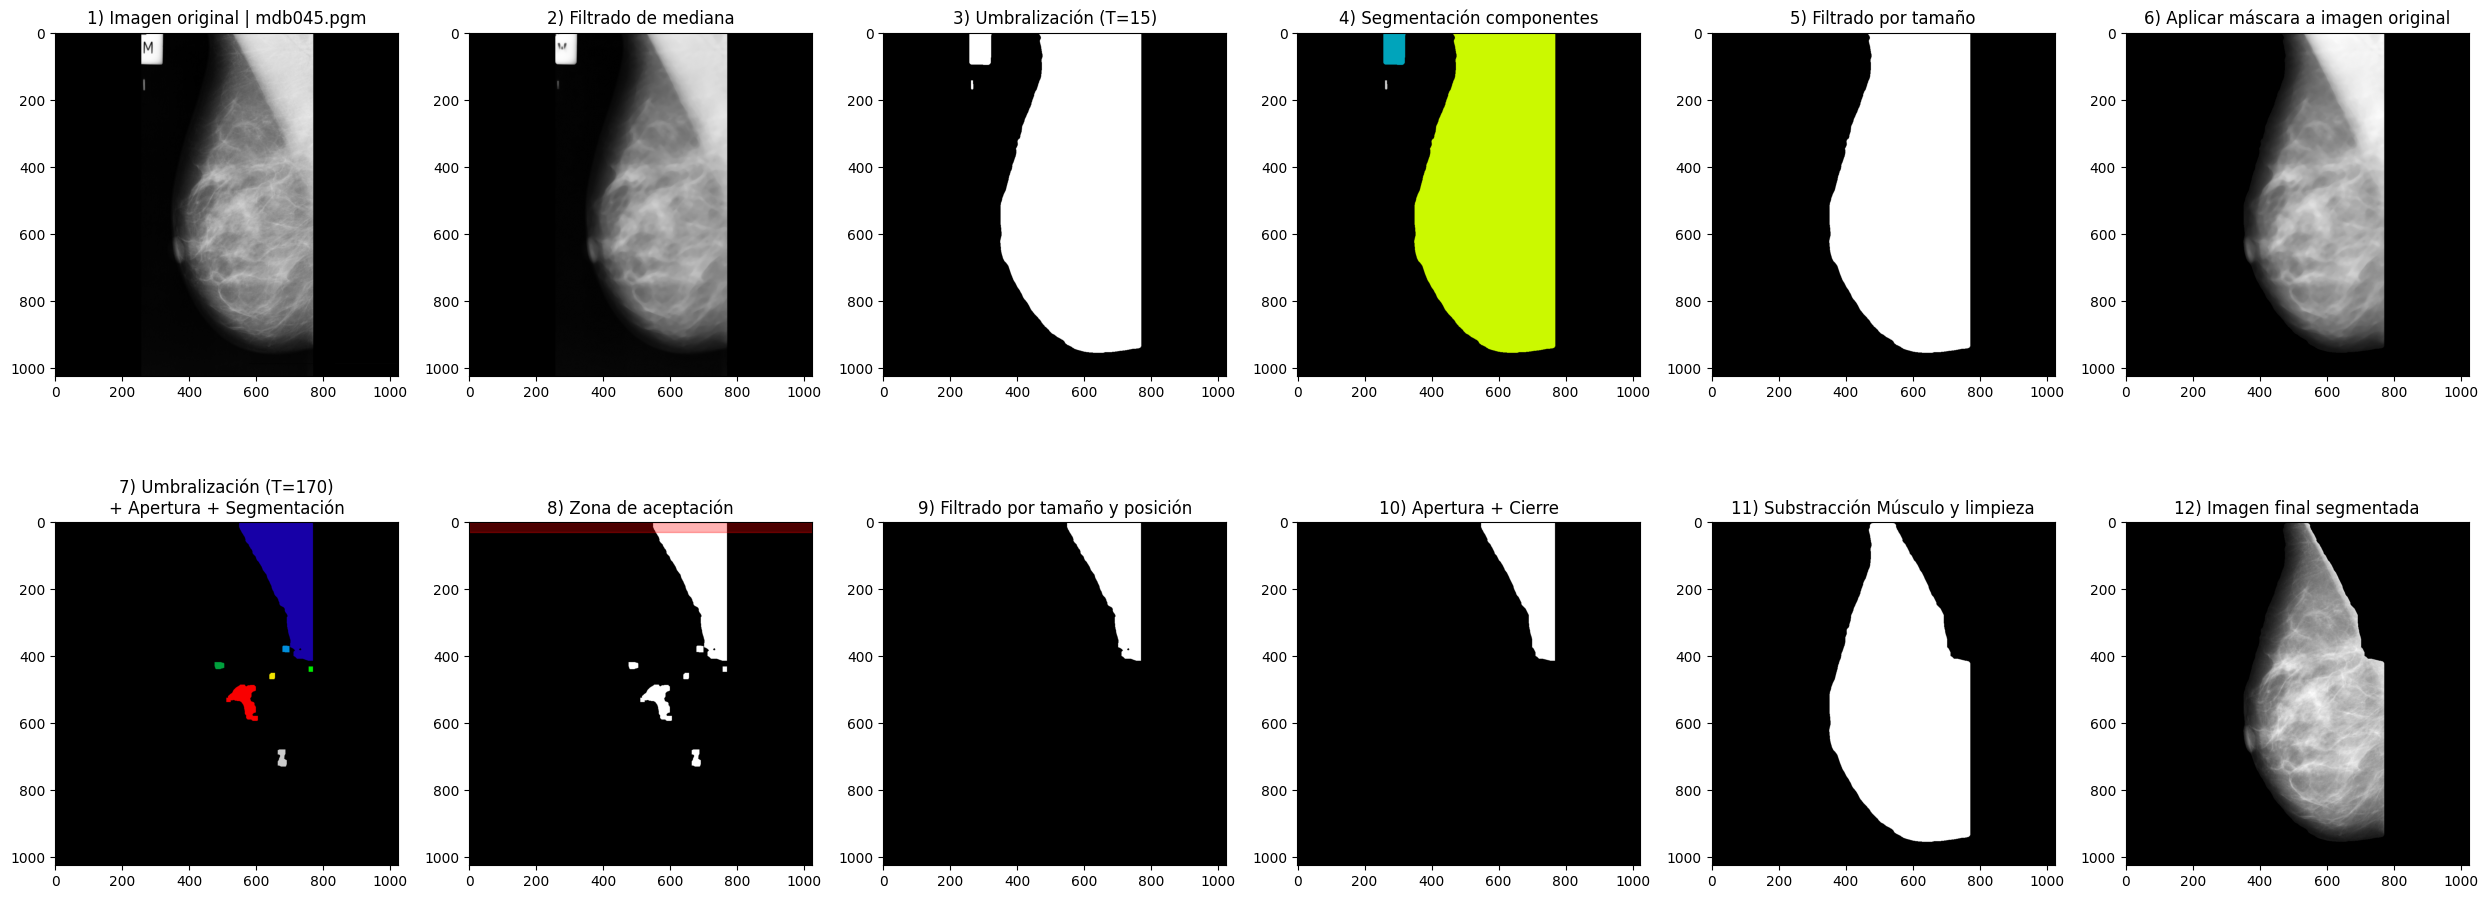

TP=251719 | FP=29032 | FN=1867 | IoU=0.8907


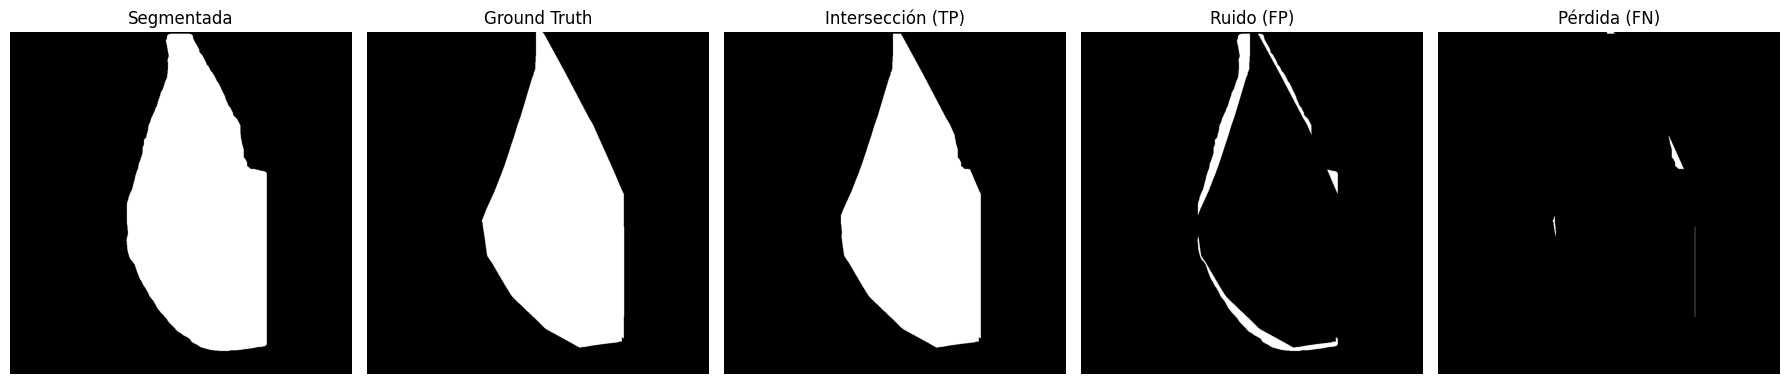

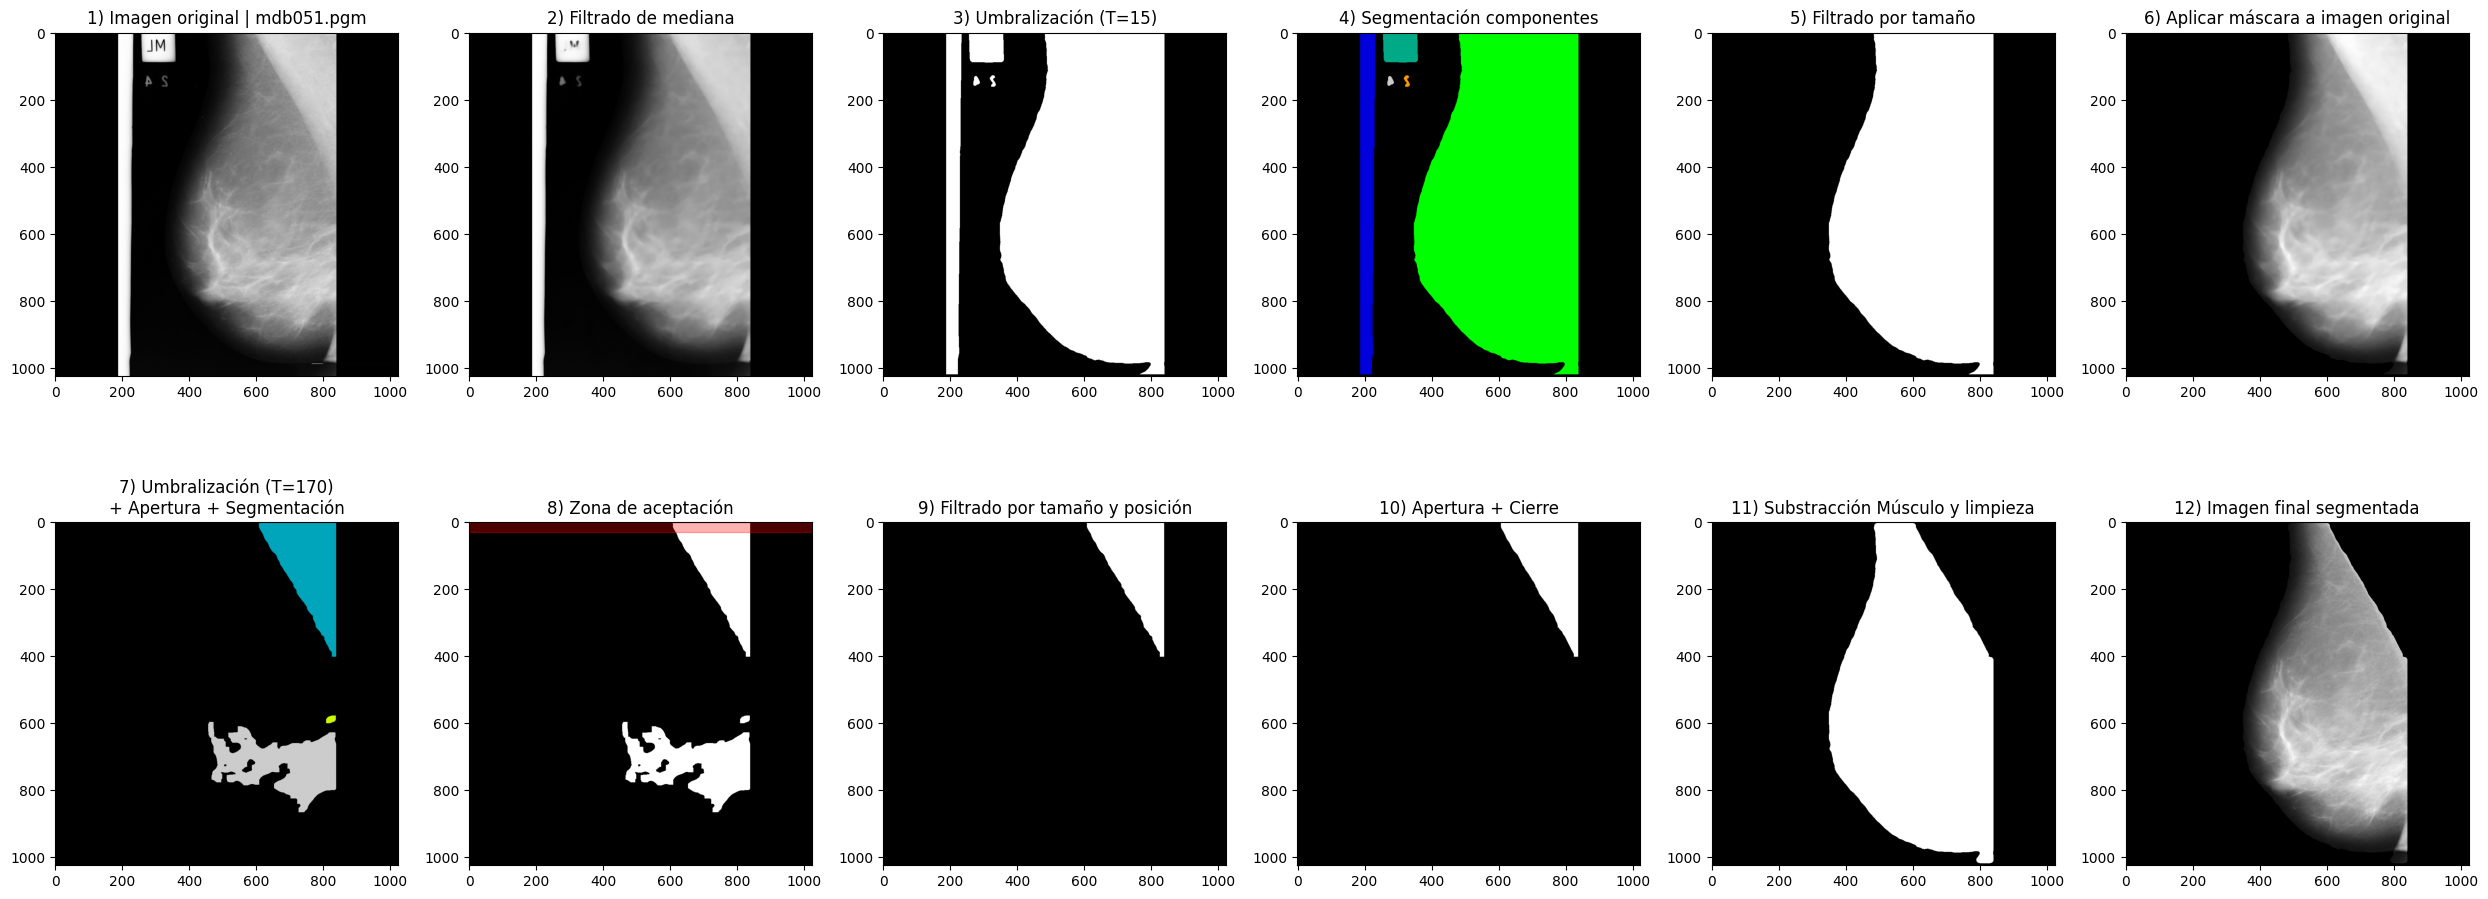

TP=316705 | FP=35347 | FN=901 | IoU=0.8973


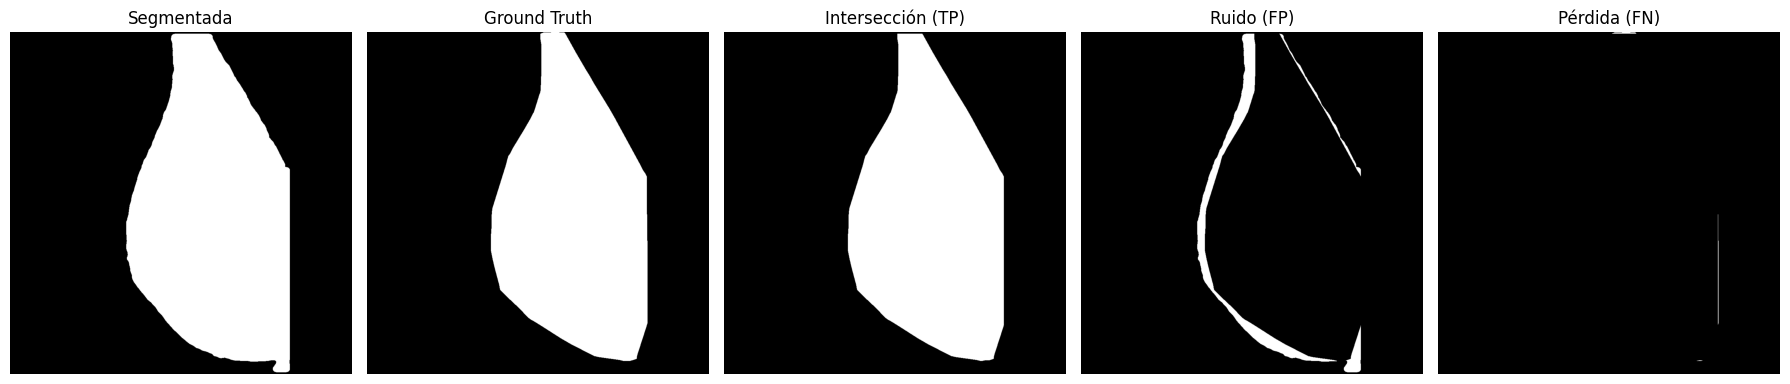

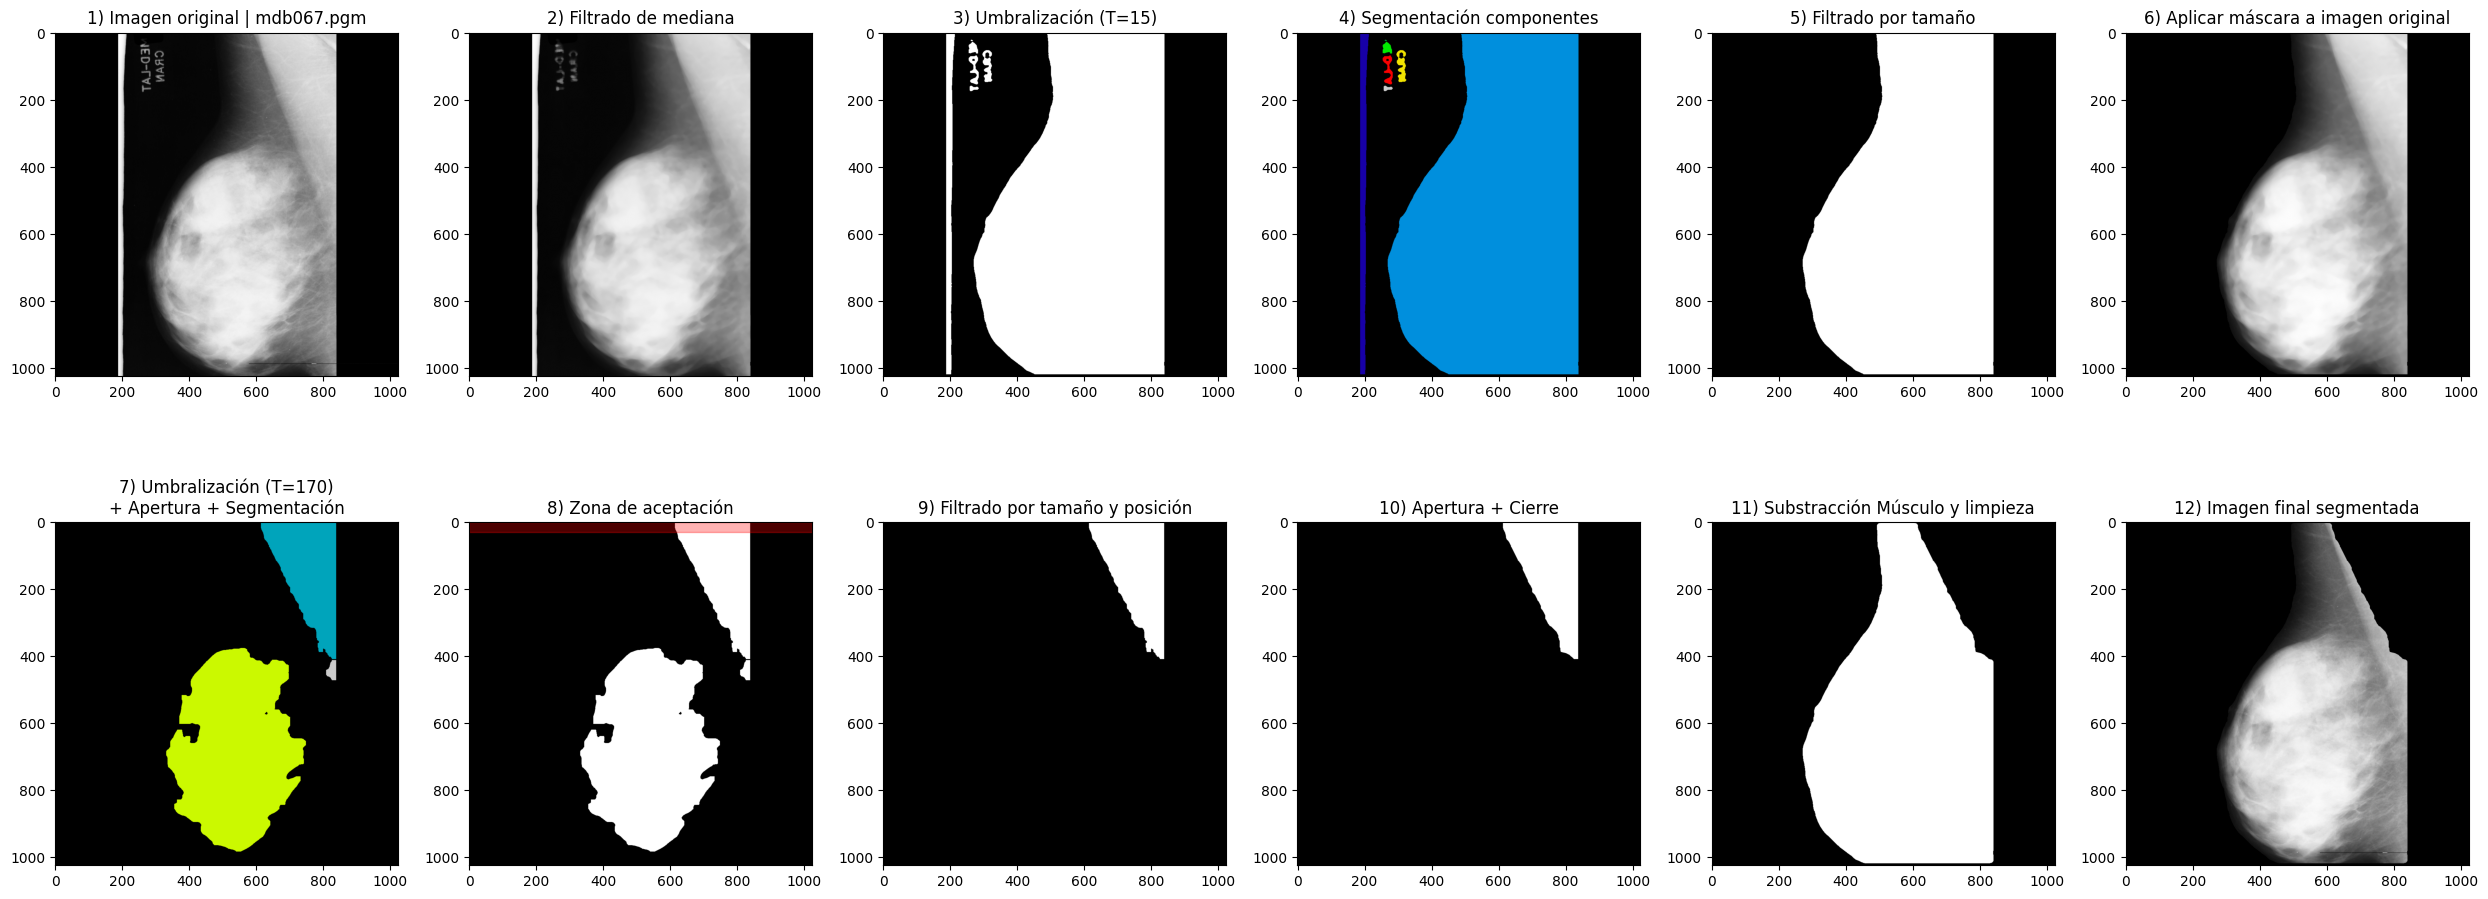

TP=358795 | FP=46734 | FN=550 | IoU=0.8836


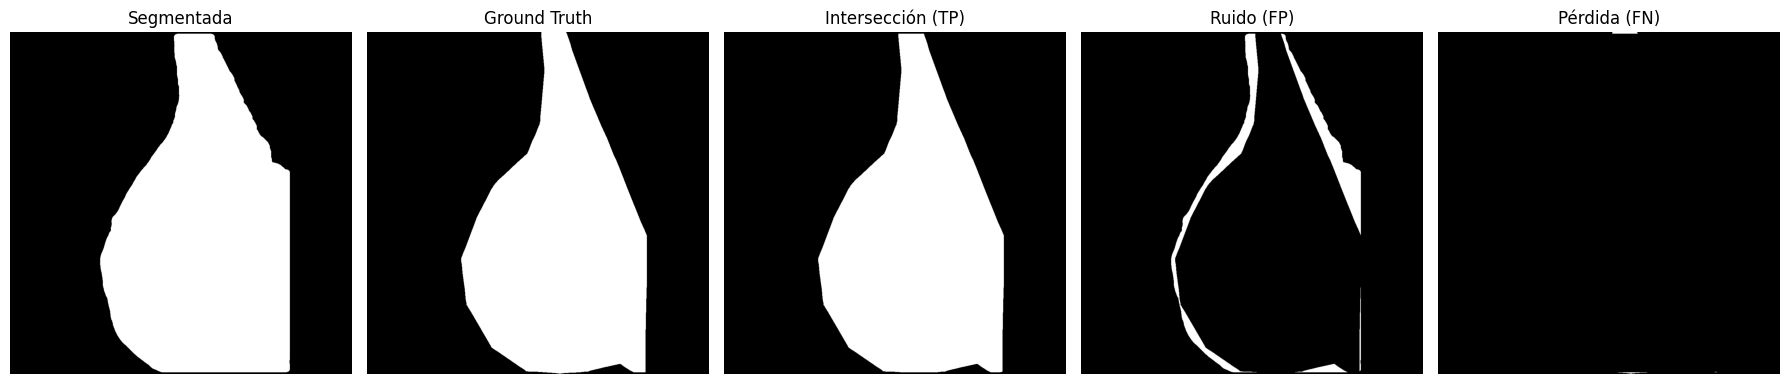

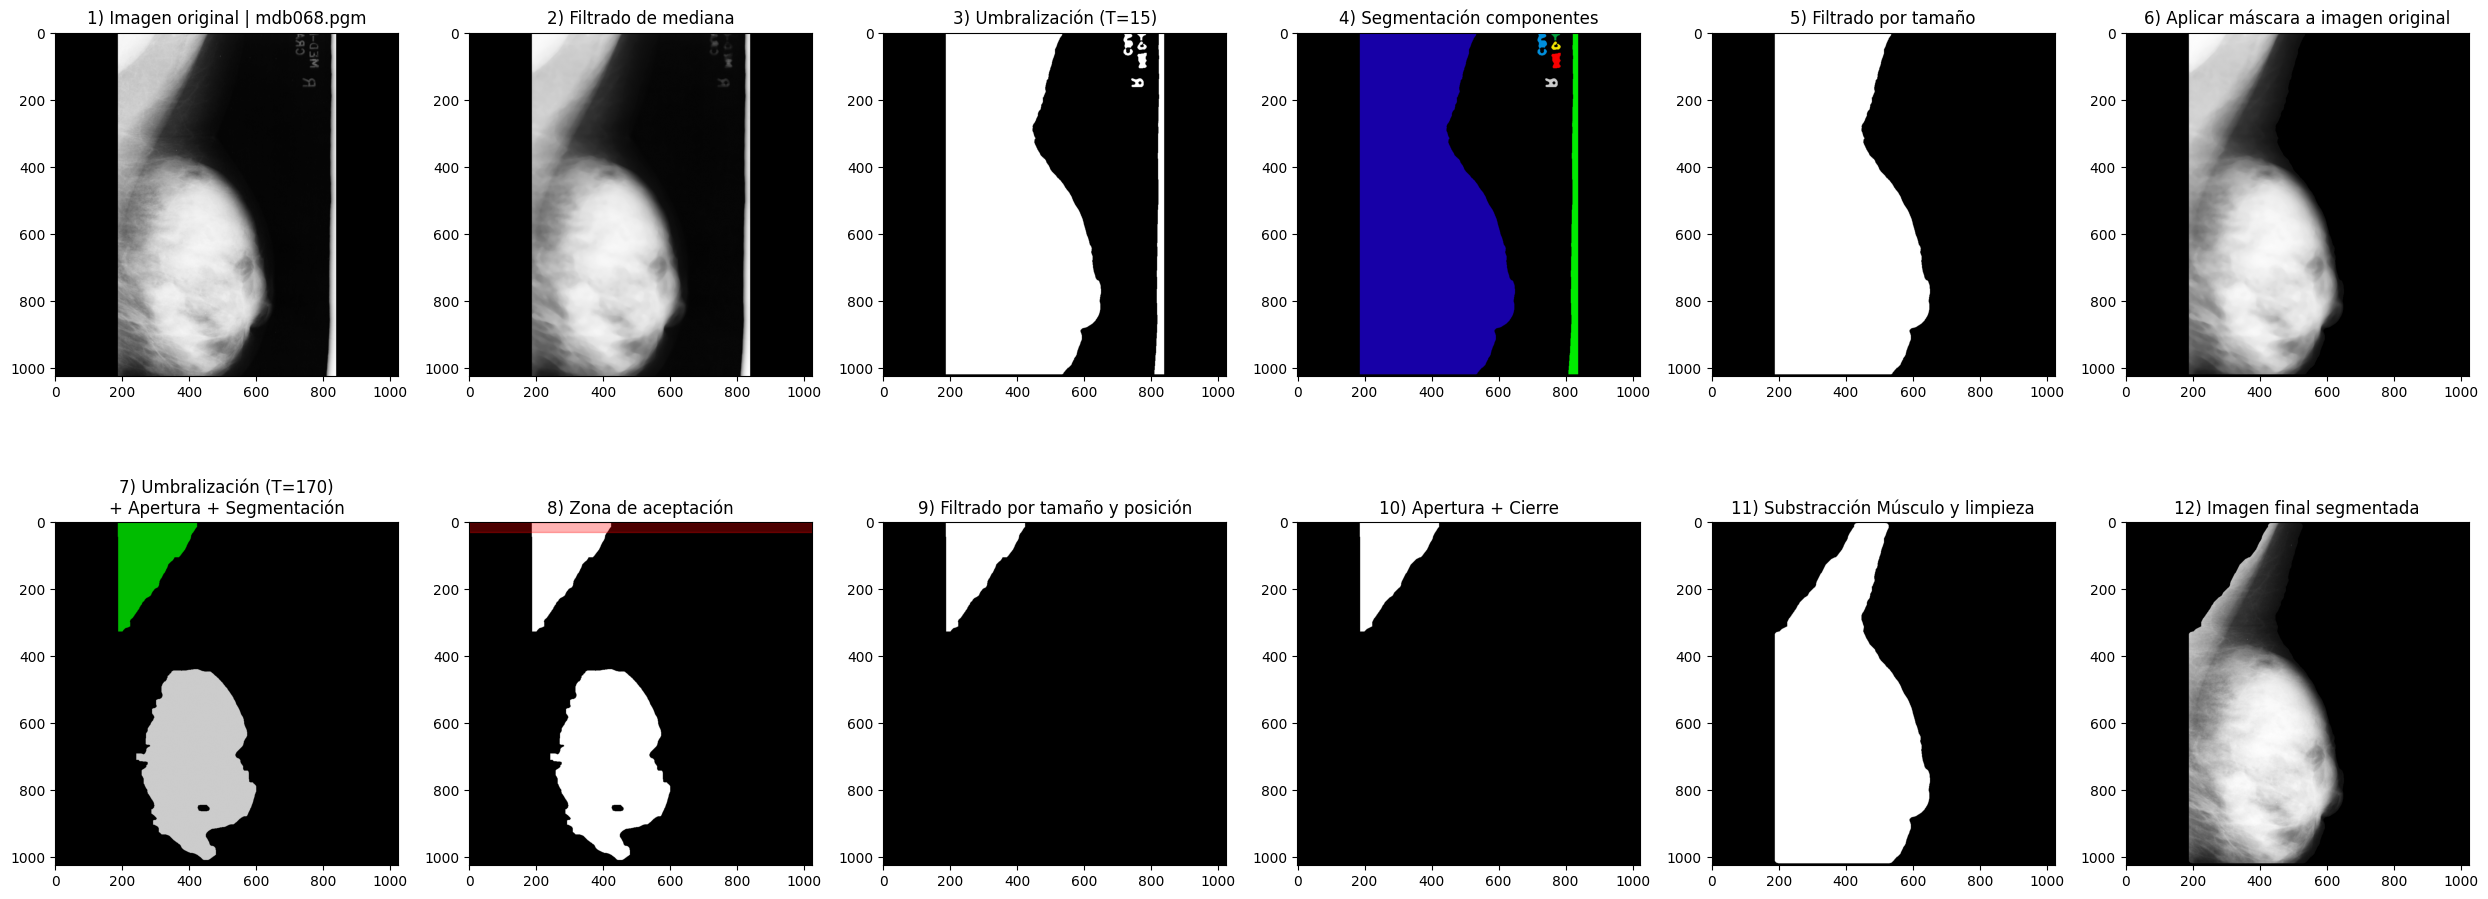

TP=266911 | FP=59207 | FN=618 | IoU=0.8169


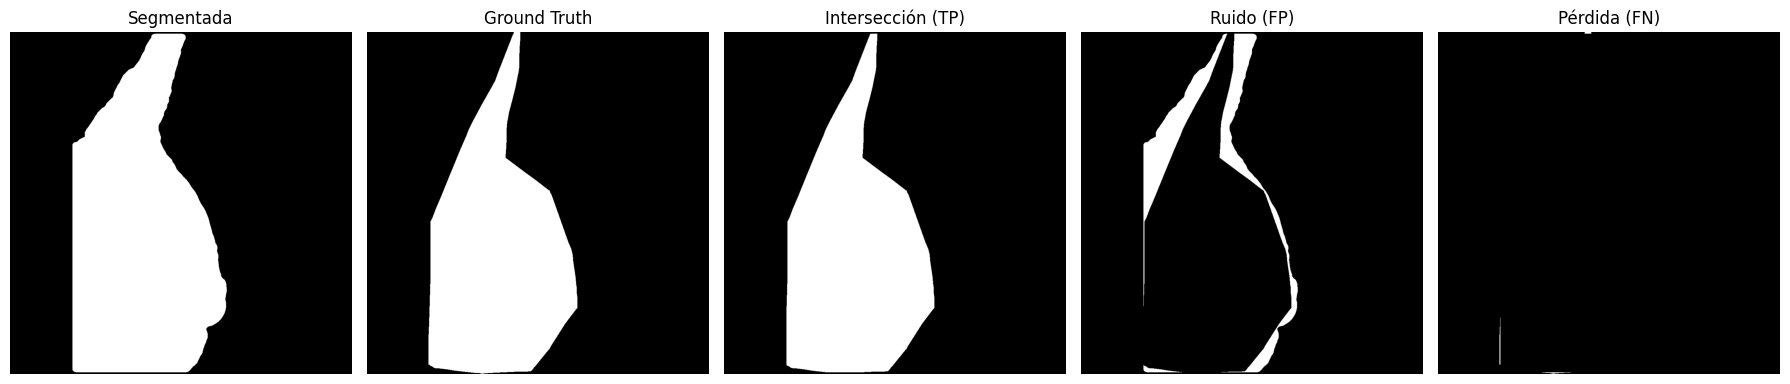

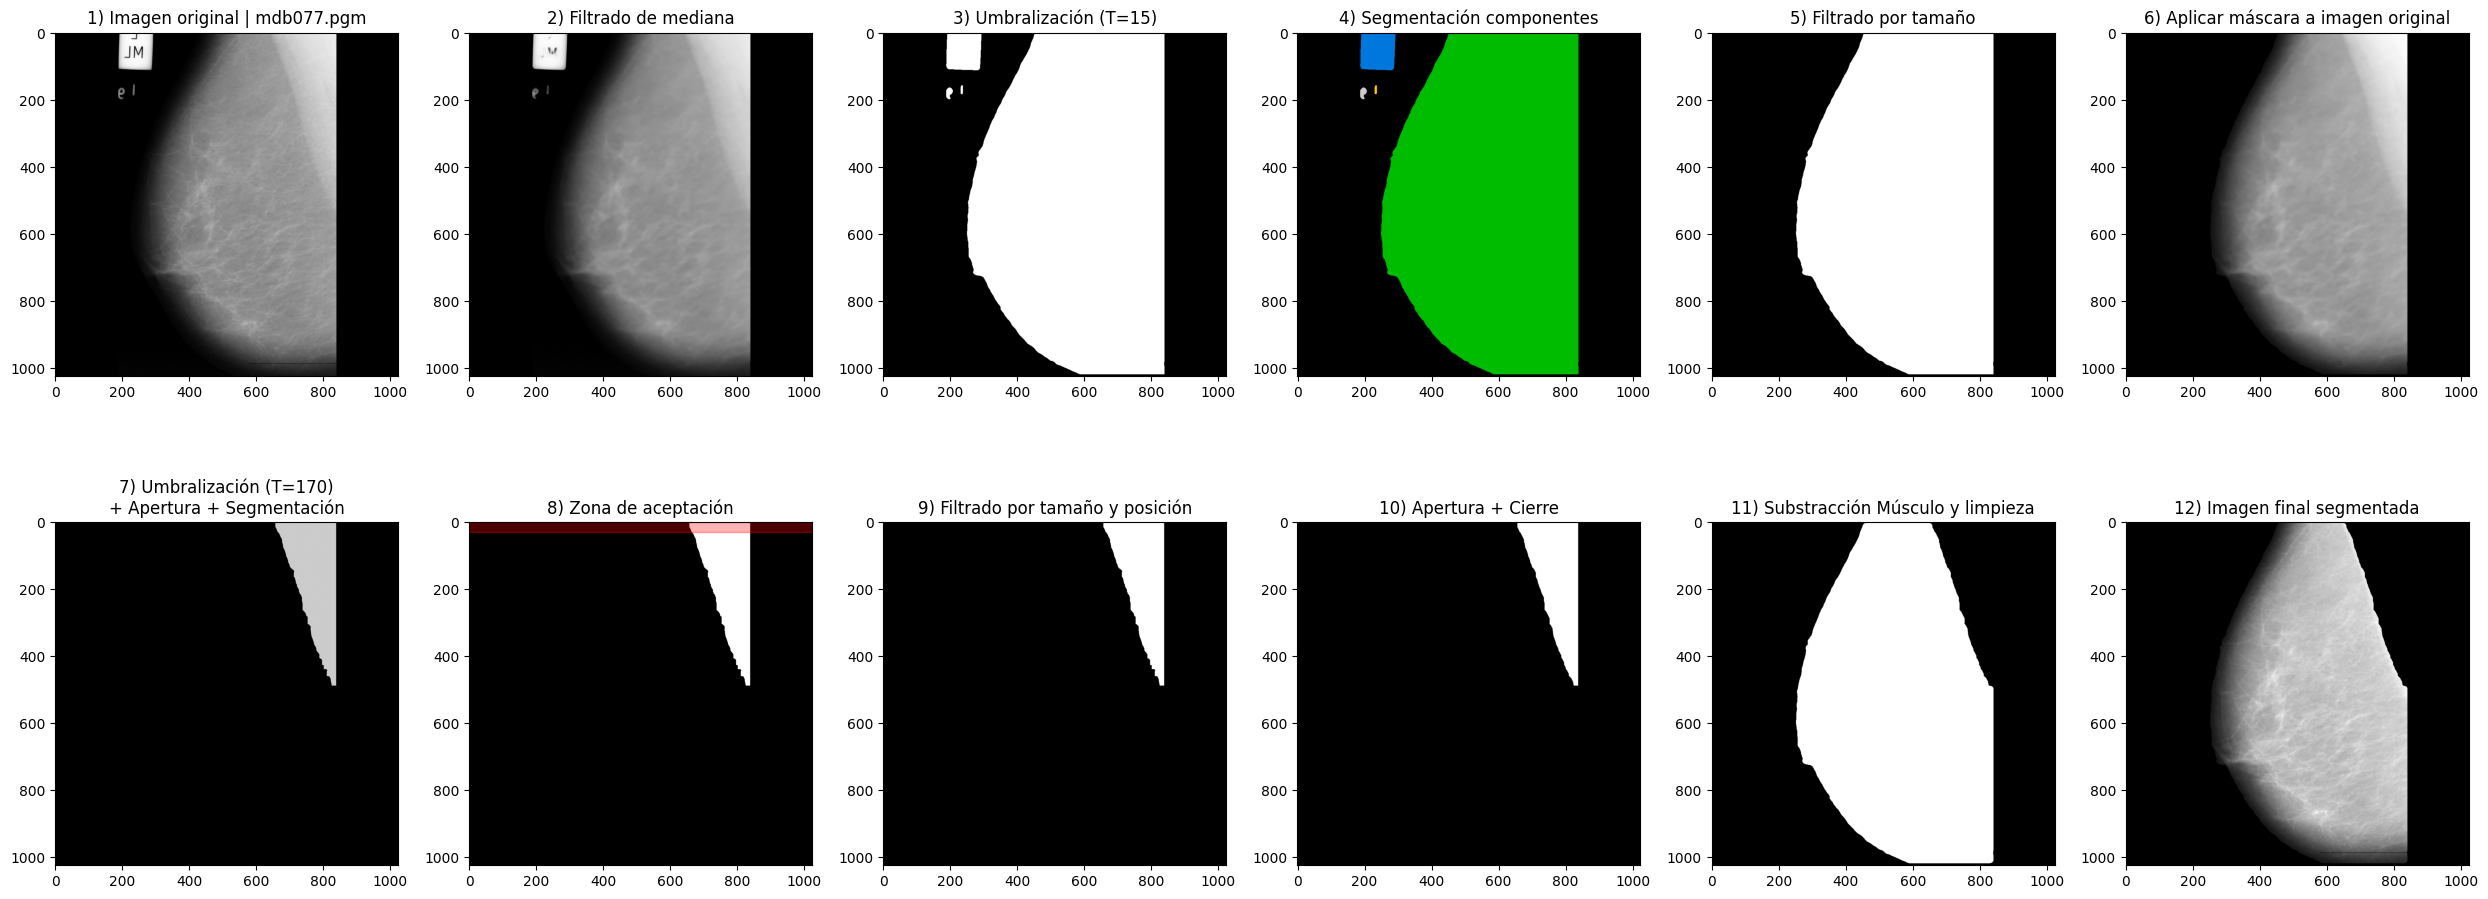

TP=440045 | FP=16837 | FN=2205 | IoU=0.9585


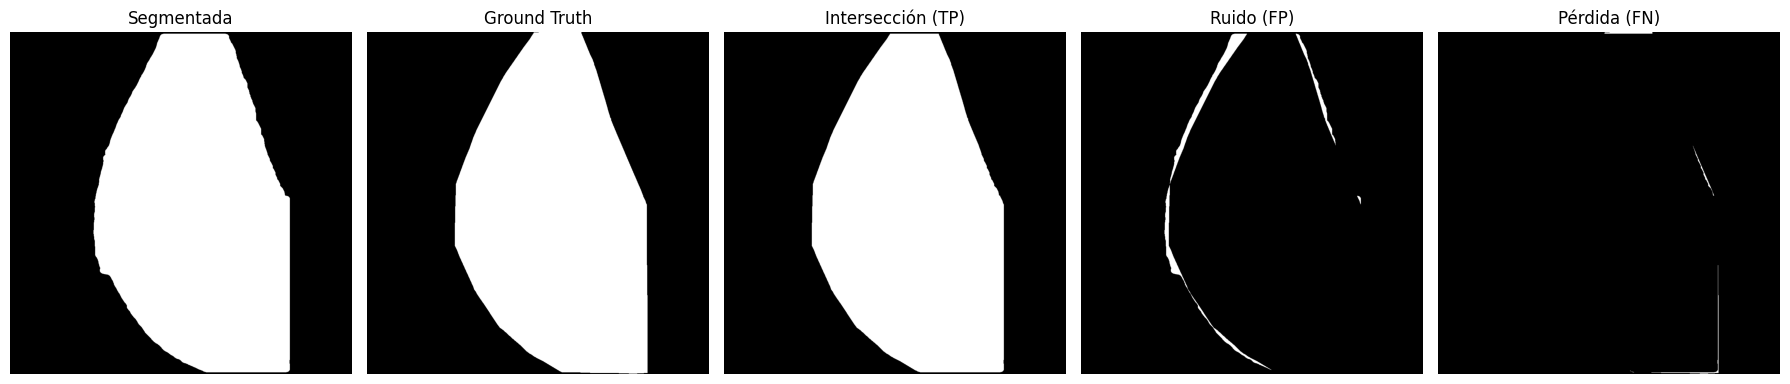

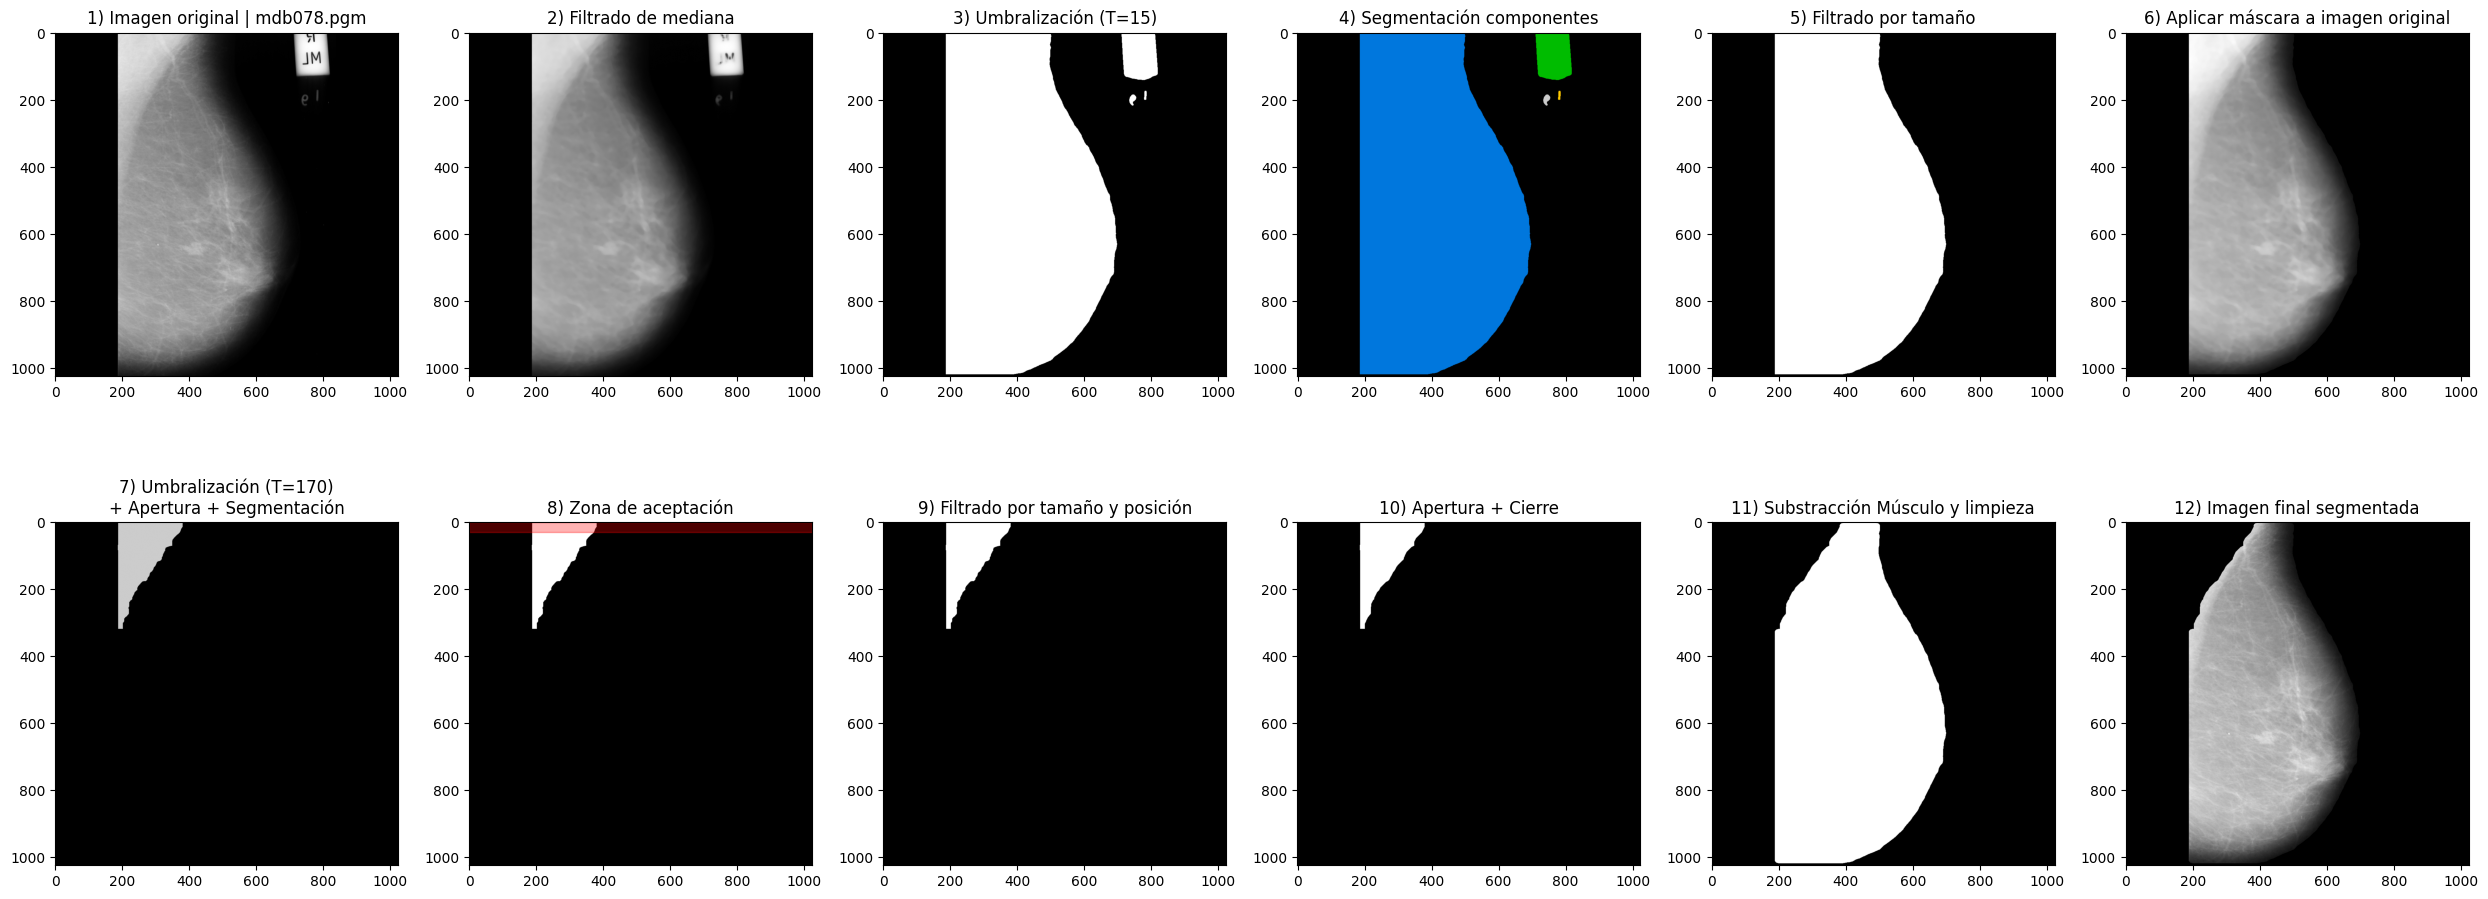

TP=361442 | FP=27454 | FN=705 | IoU=0.9277


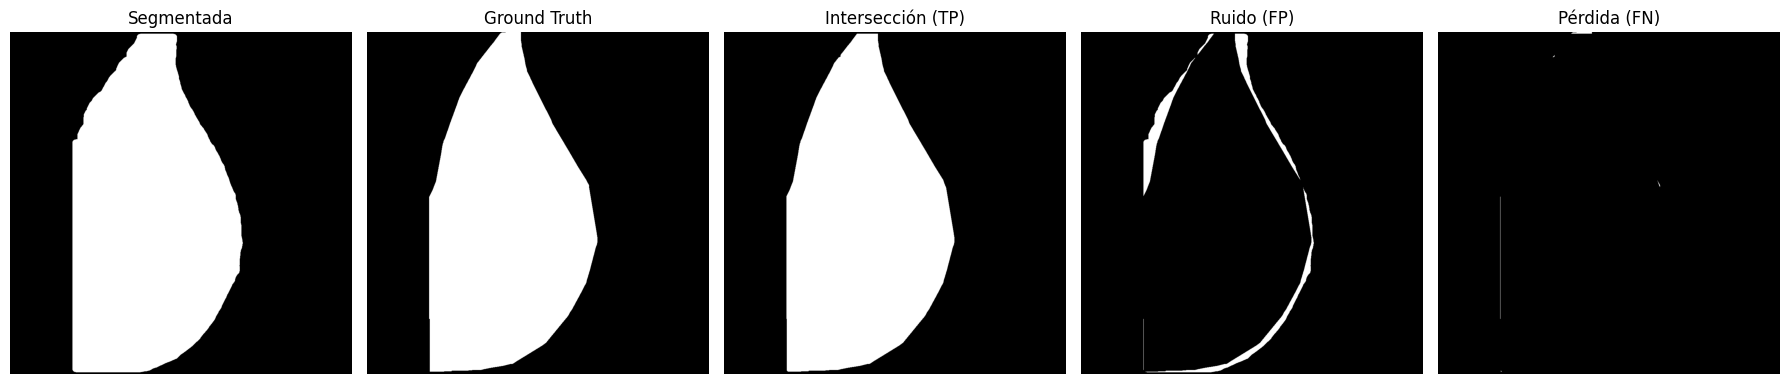

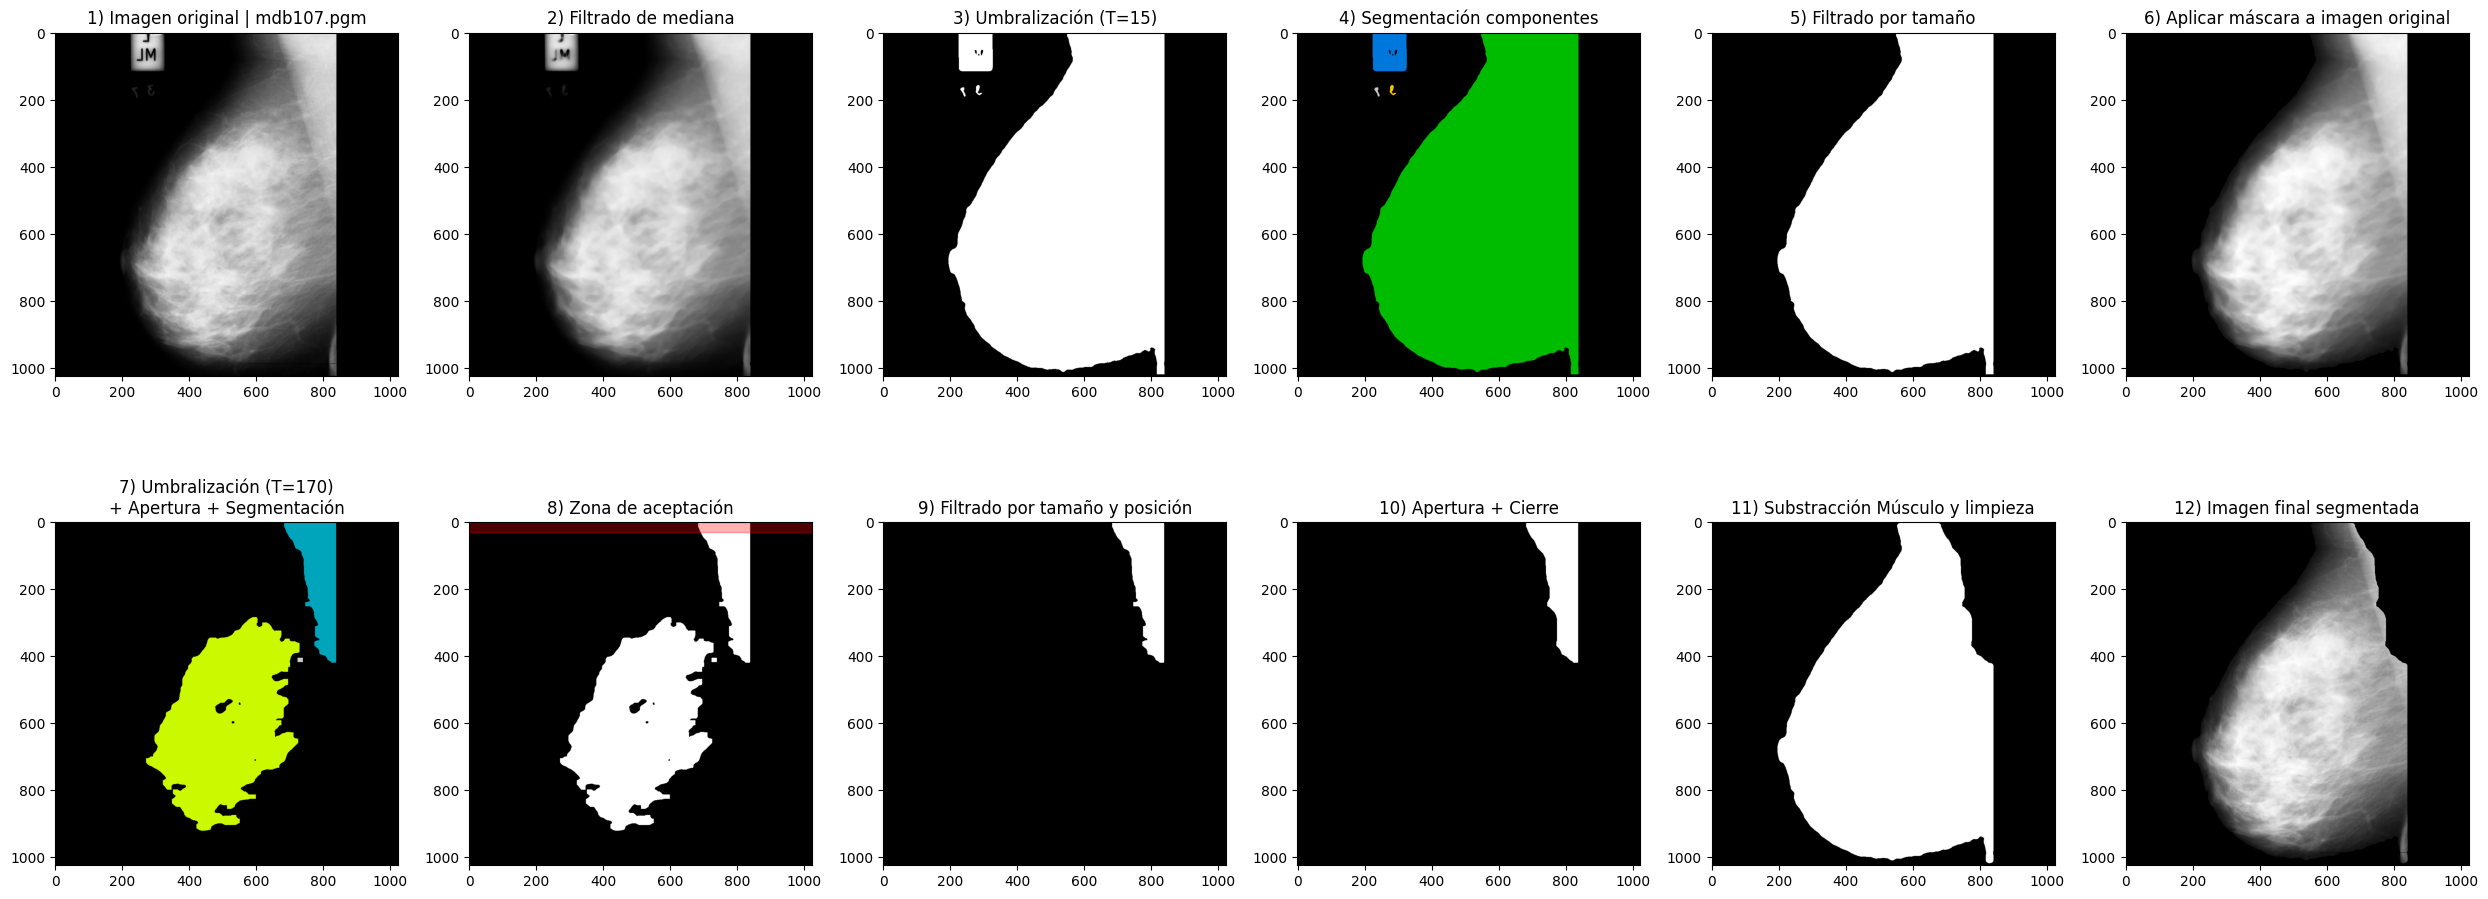

TP=410776 | FP=36454 | FN=1980 | IoU=0.9144


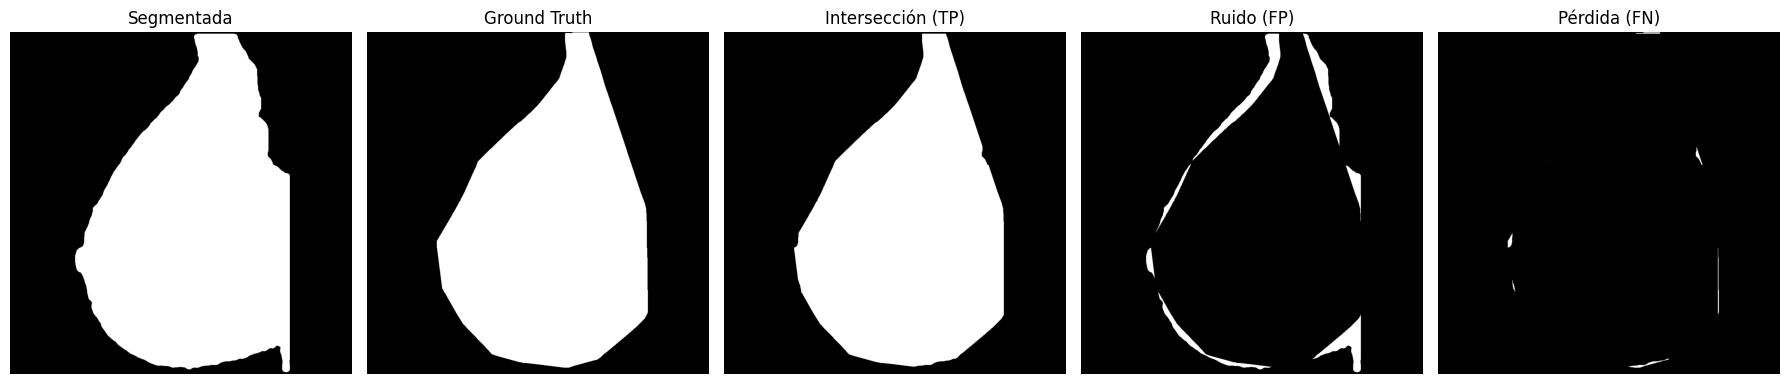

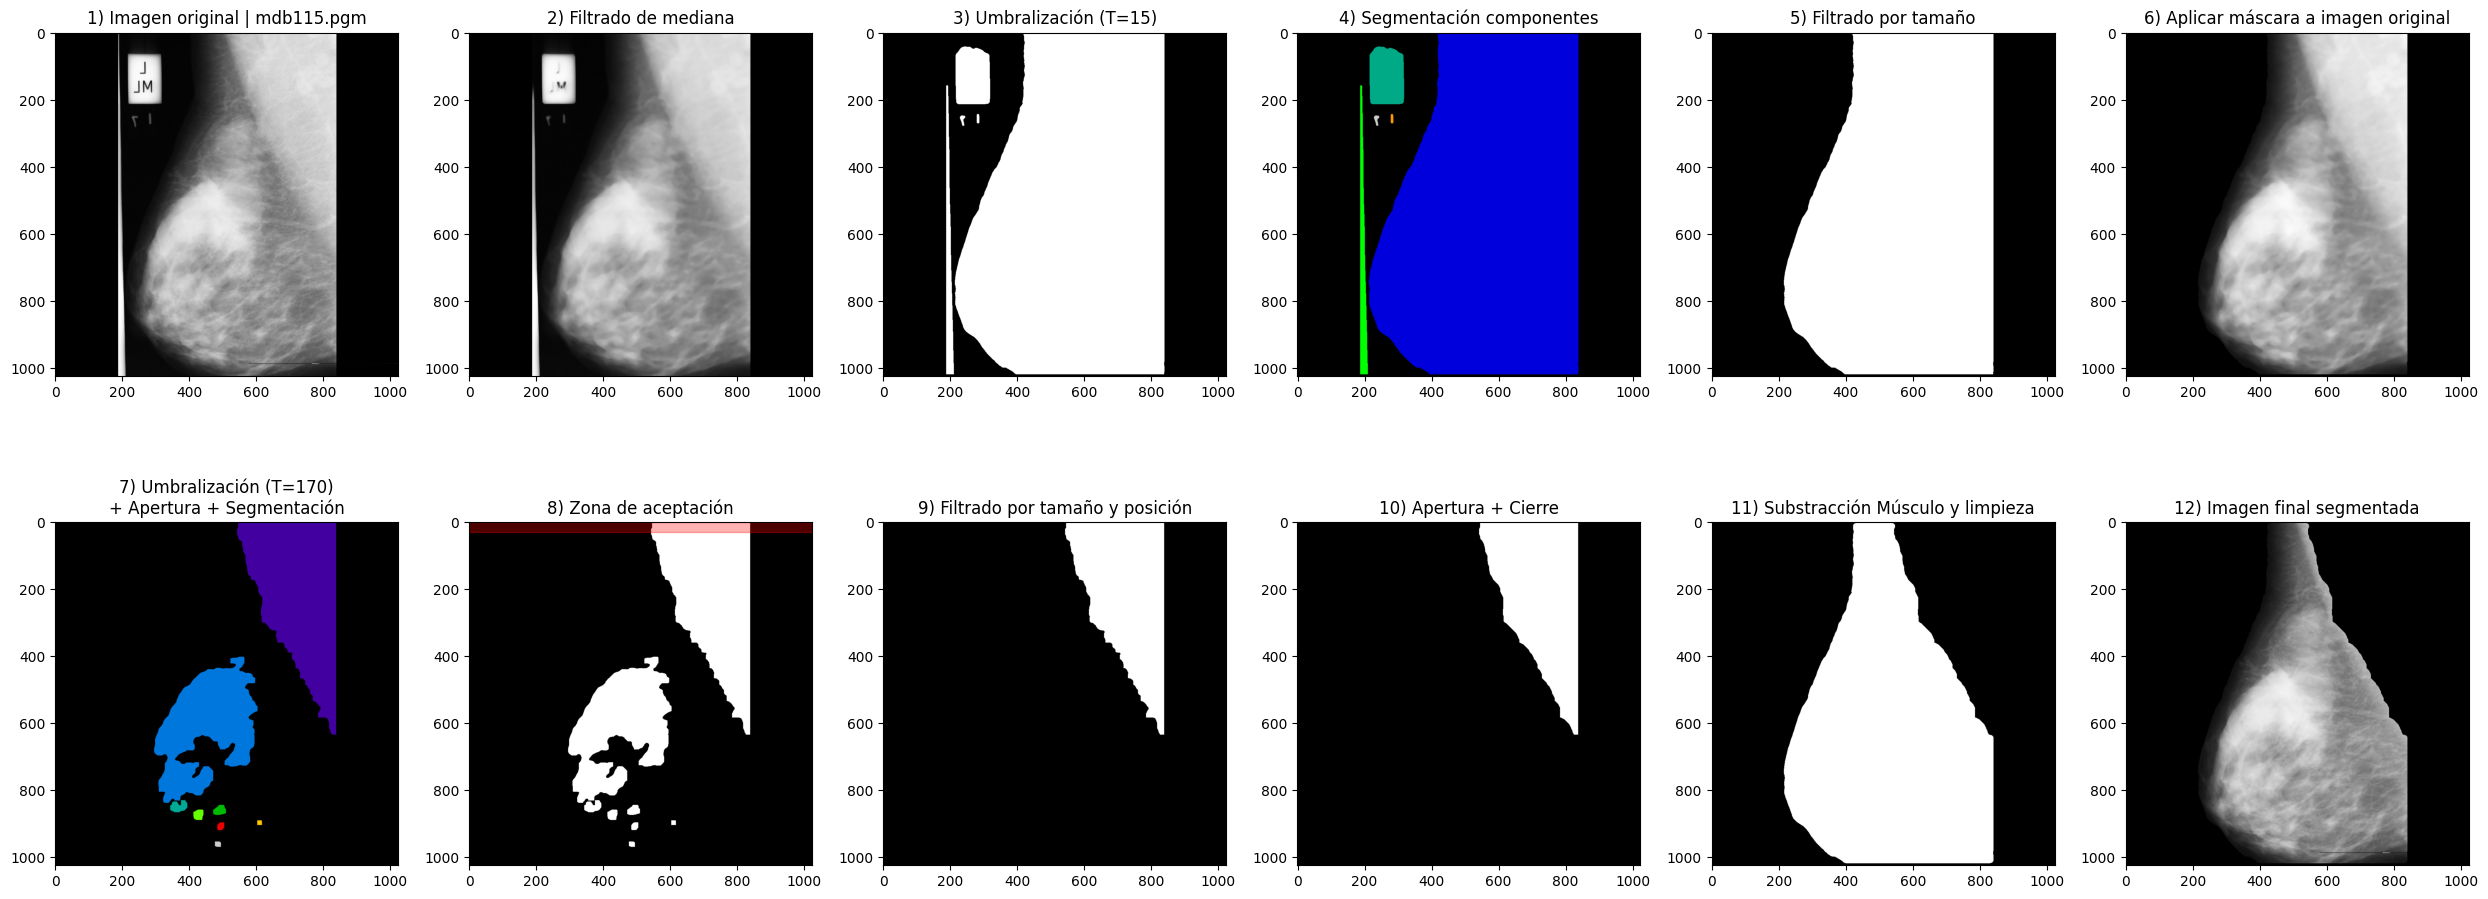

TP=370199 | FP=45066 | FN=1010 | IoU=0.8893


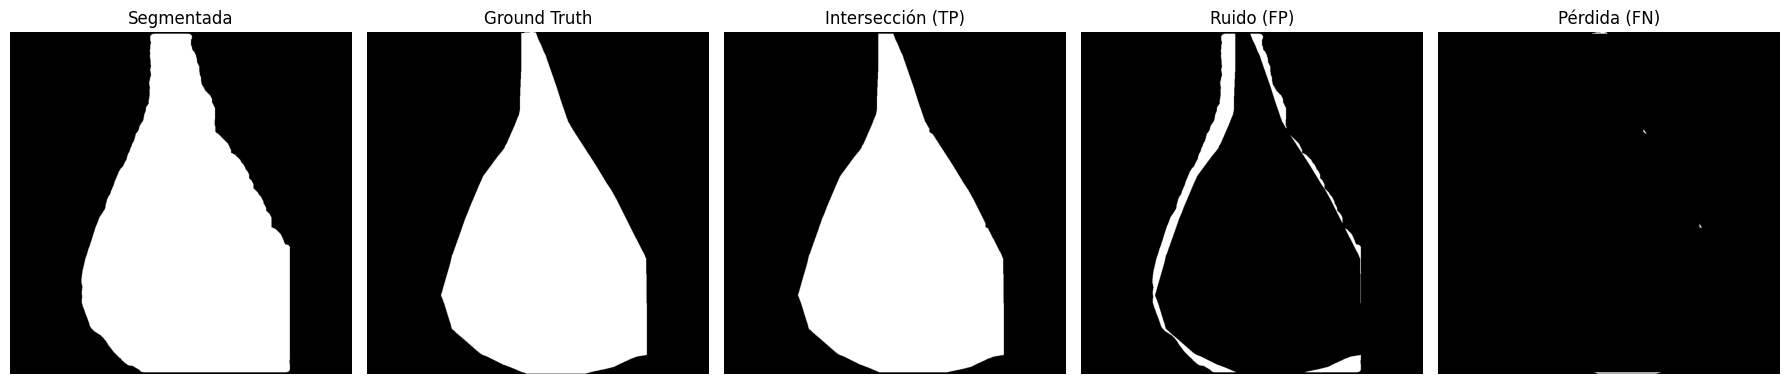

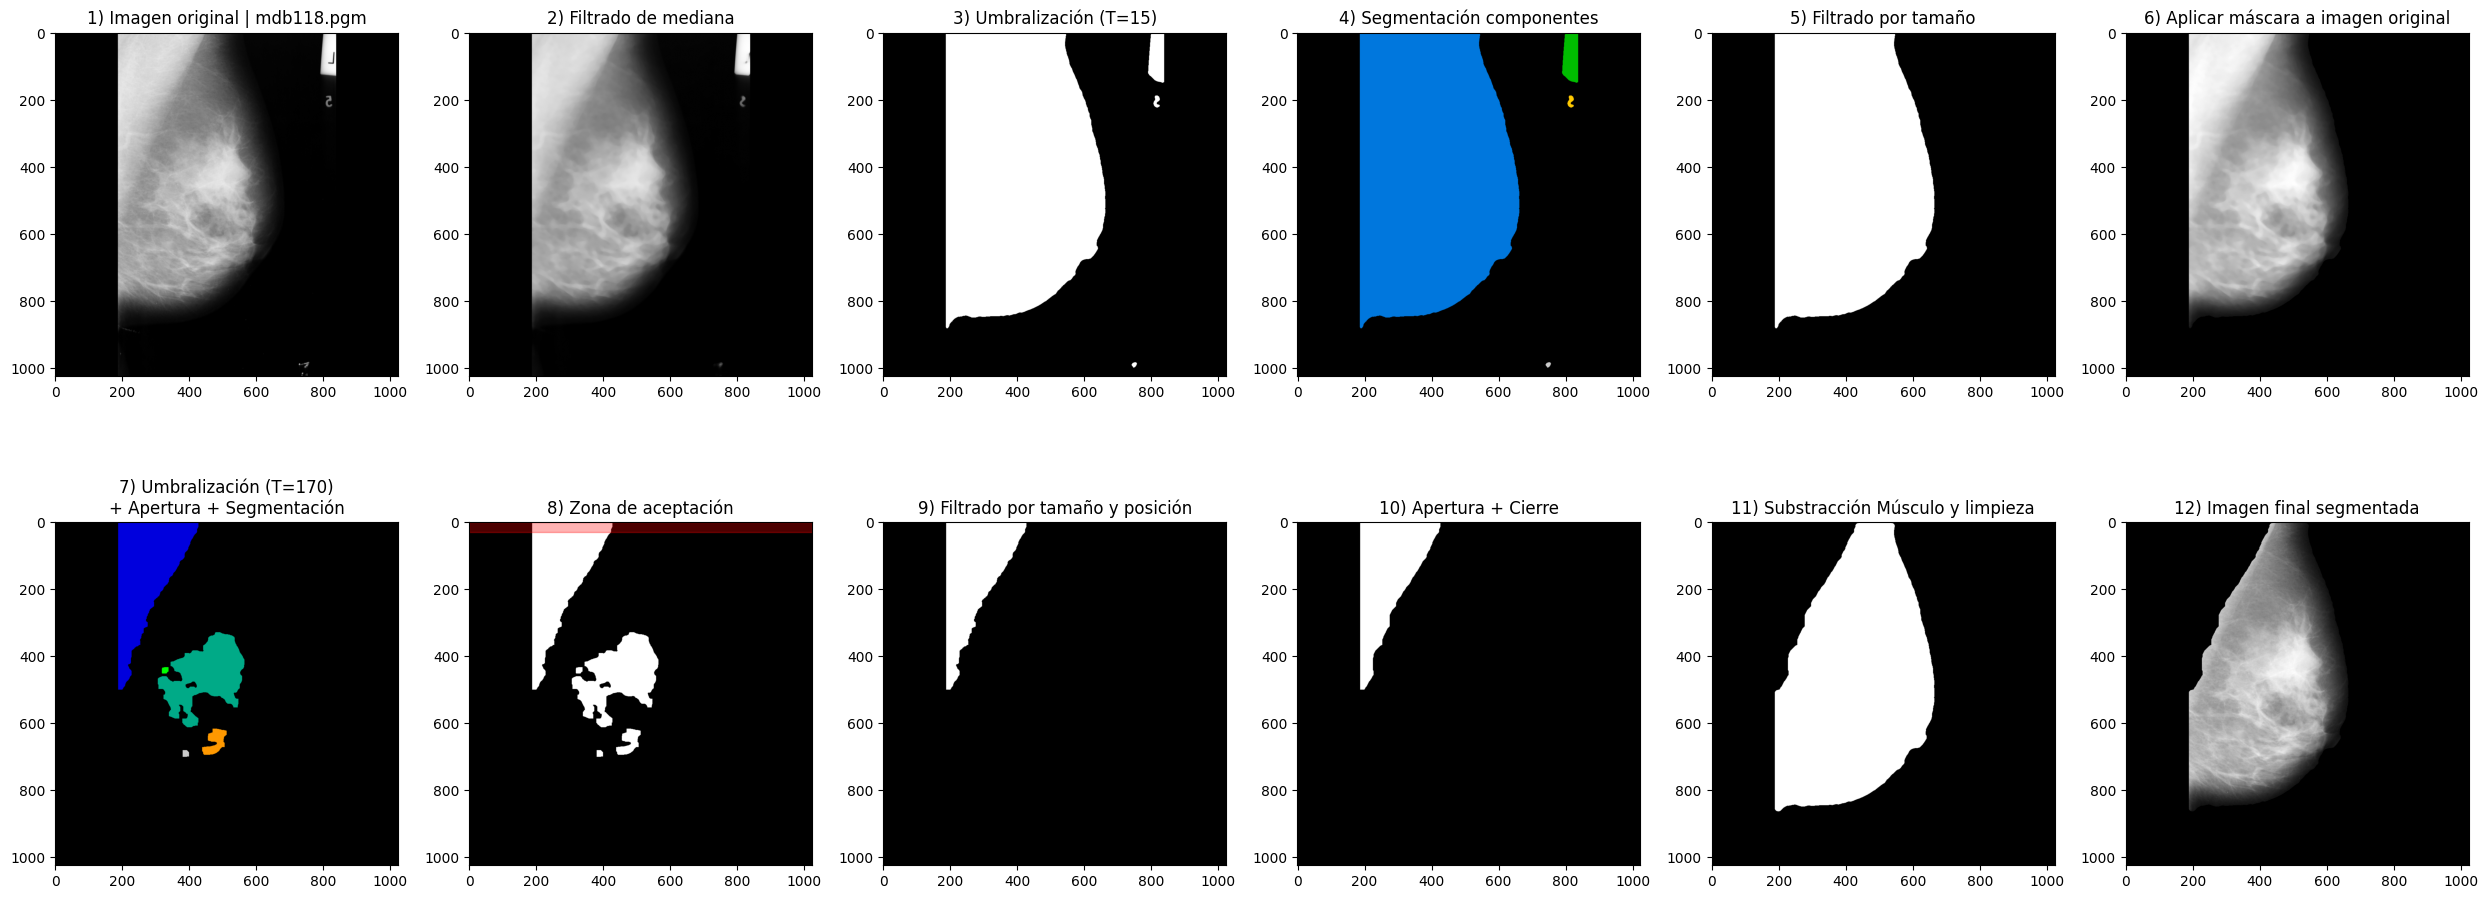

TP=259552 | FP=27866 | FN=971 | IoU=0.9000


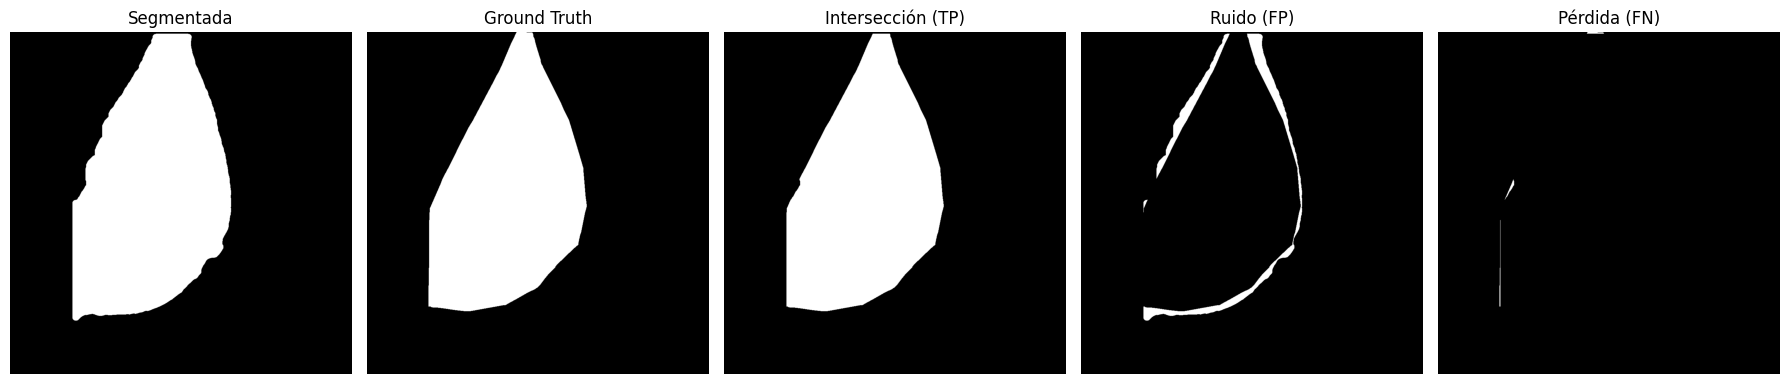

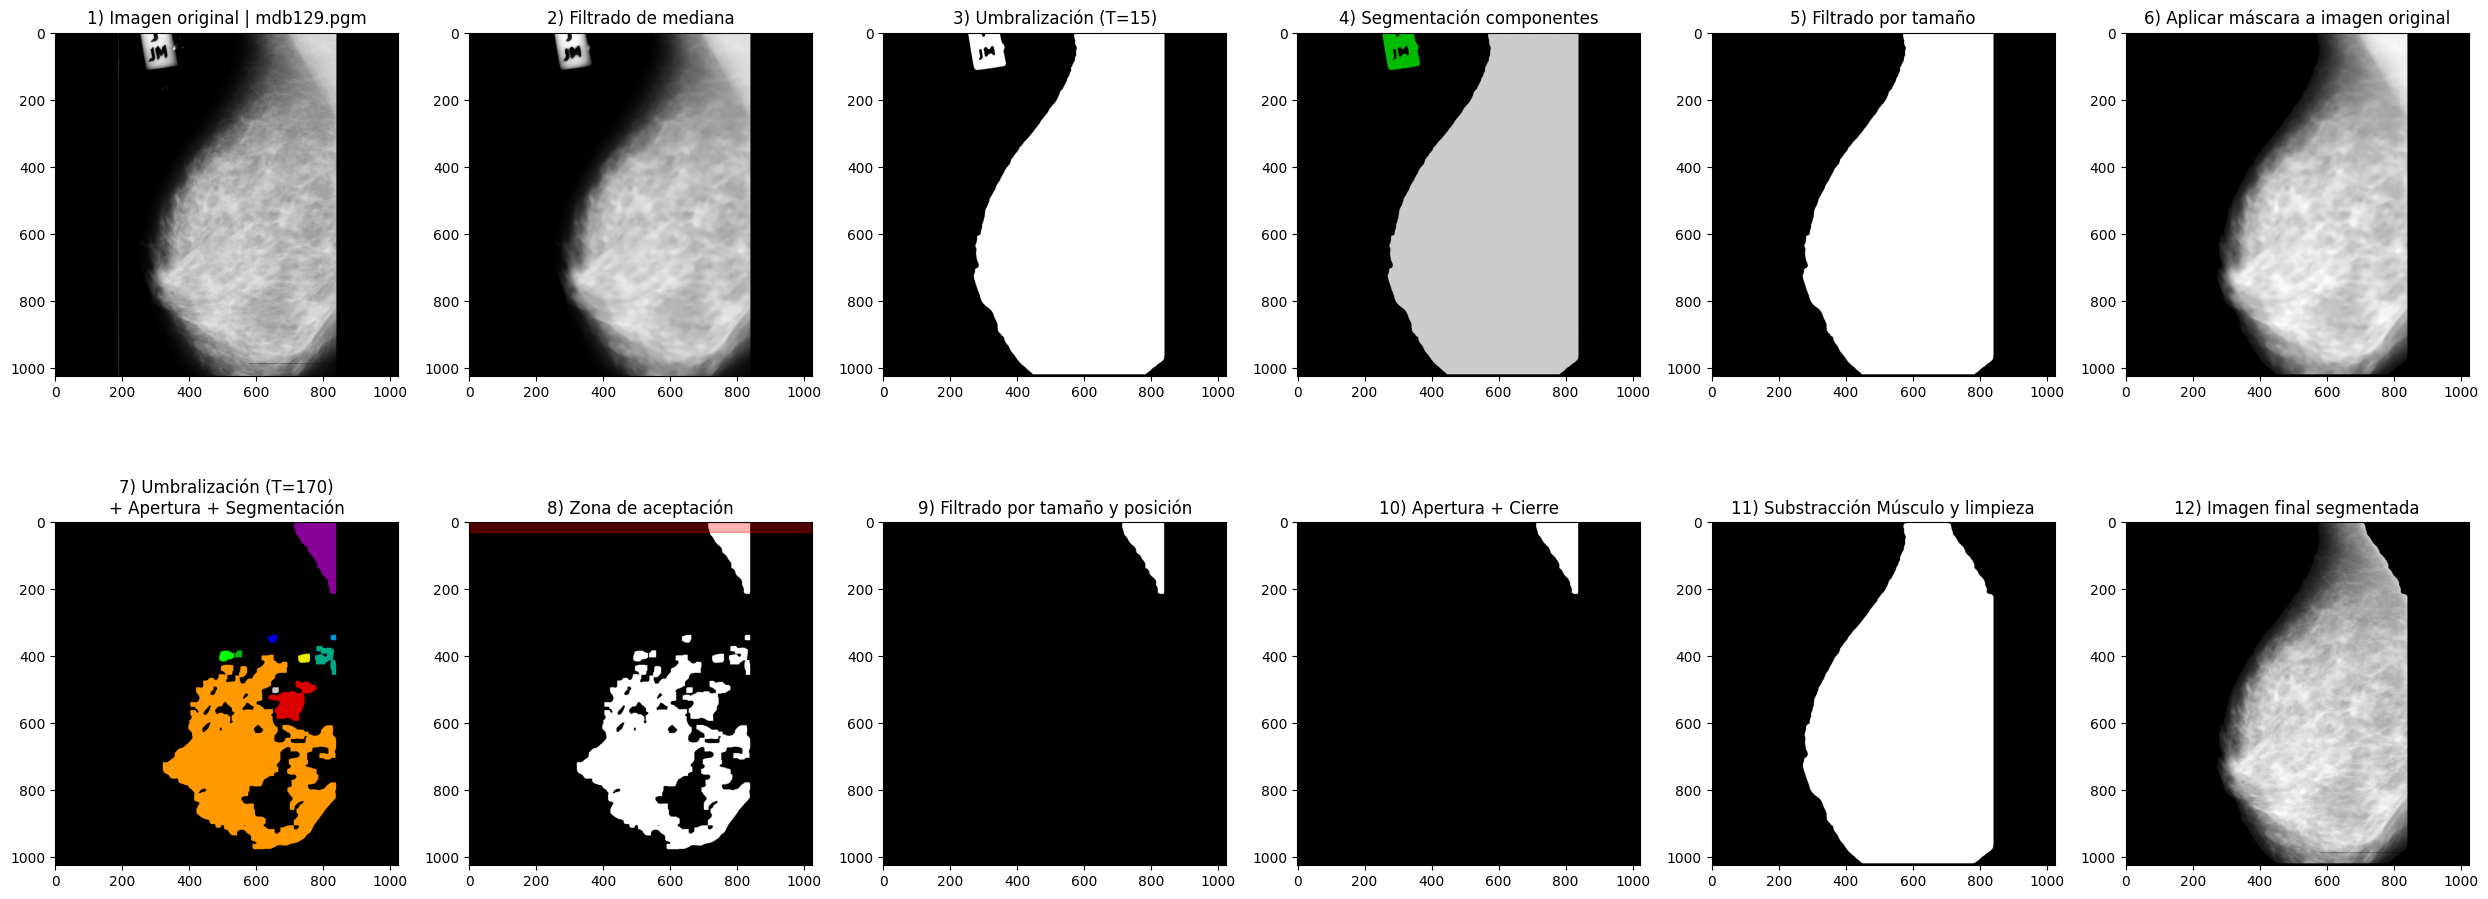

TP=410840 | FP=25076 | FN=1170 | IoU=0.9400


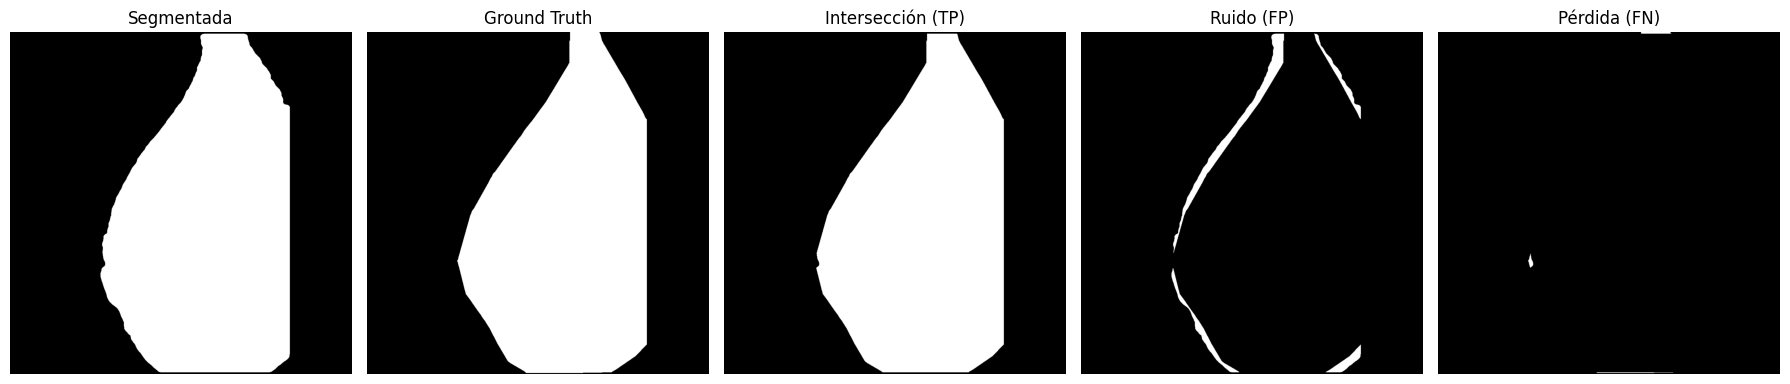

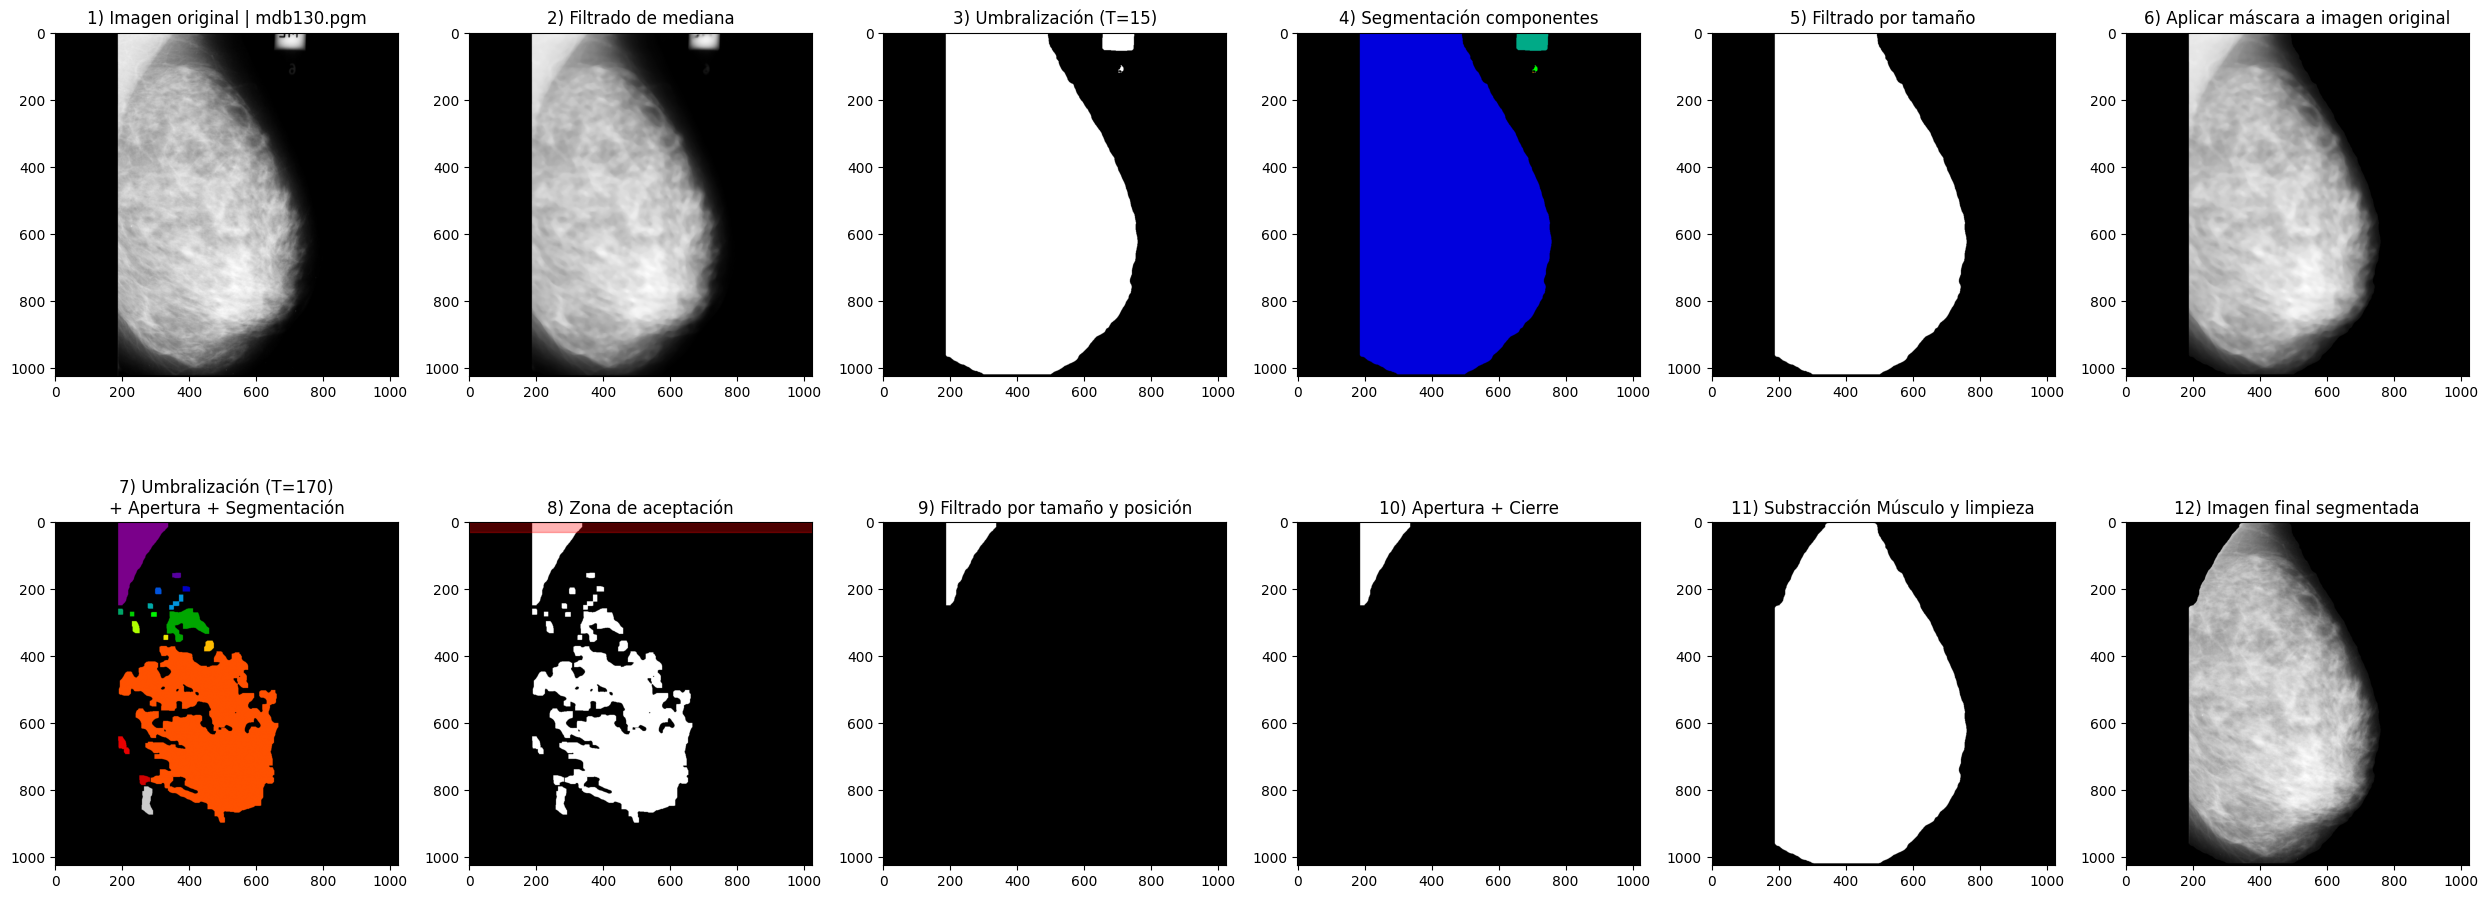

TP=428480 | FP=27155 | FN=1681 | IoU=0.9369


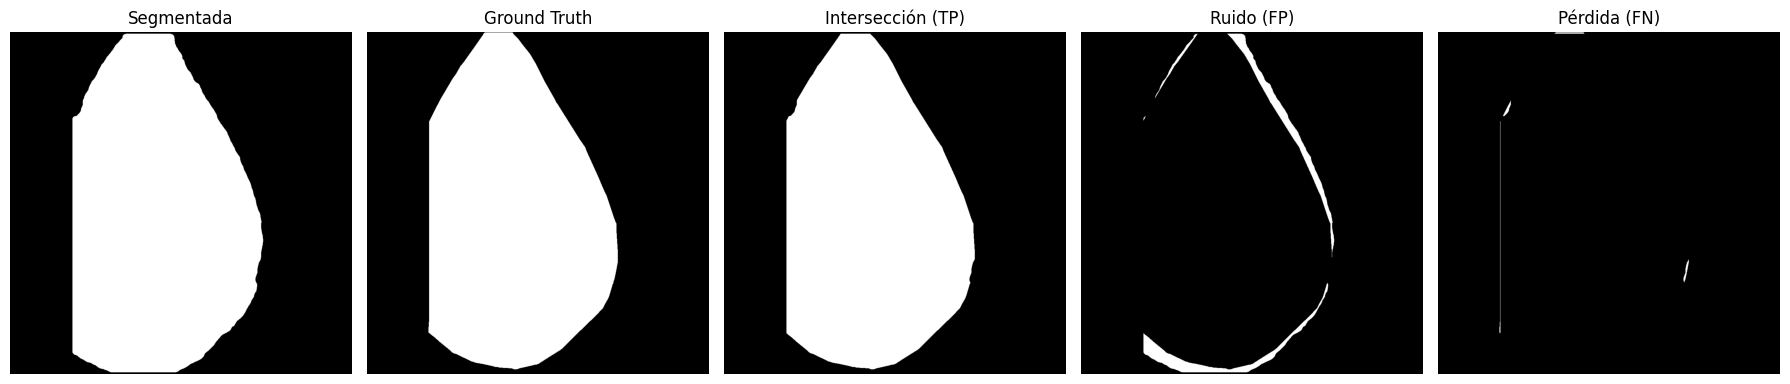

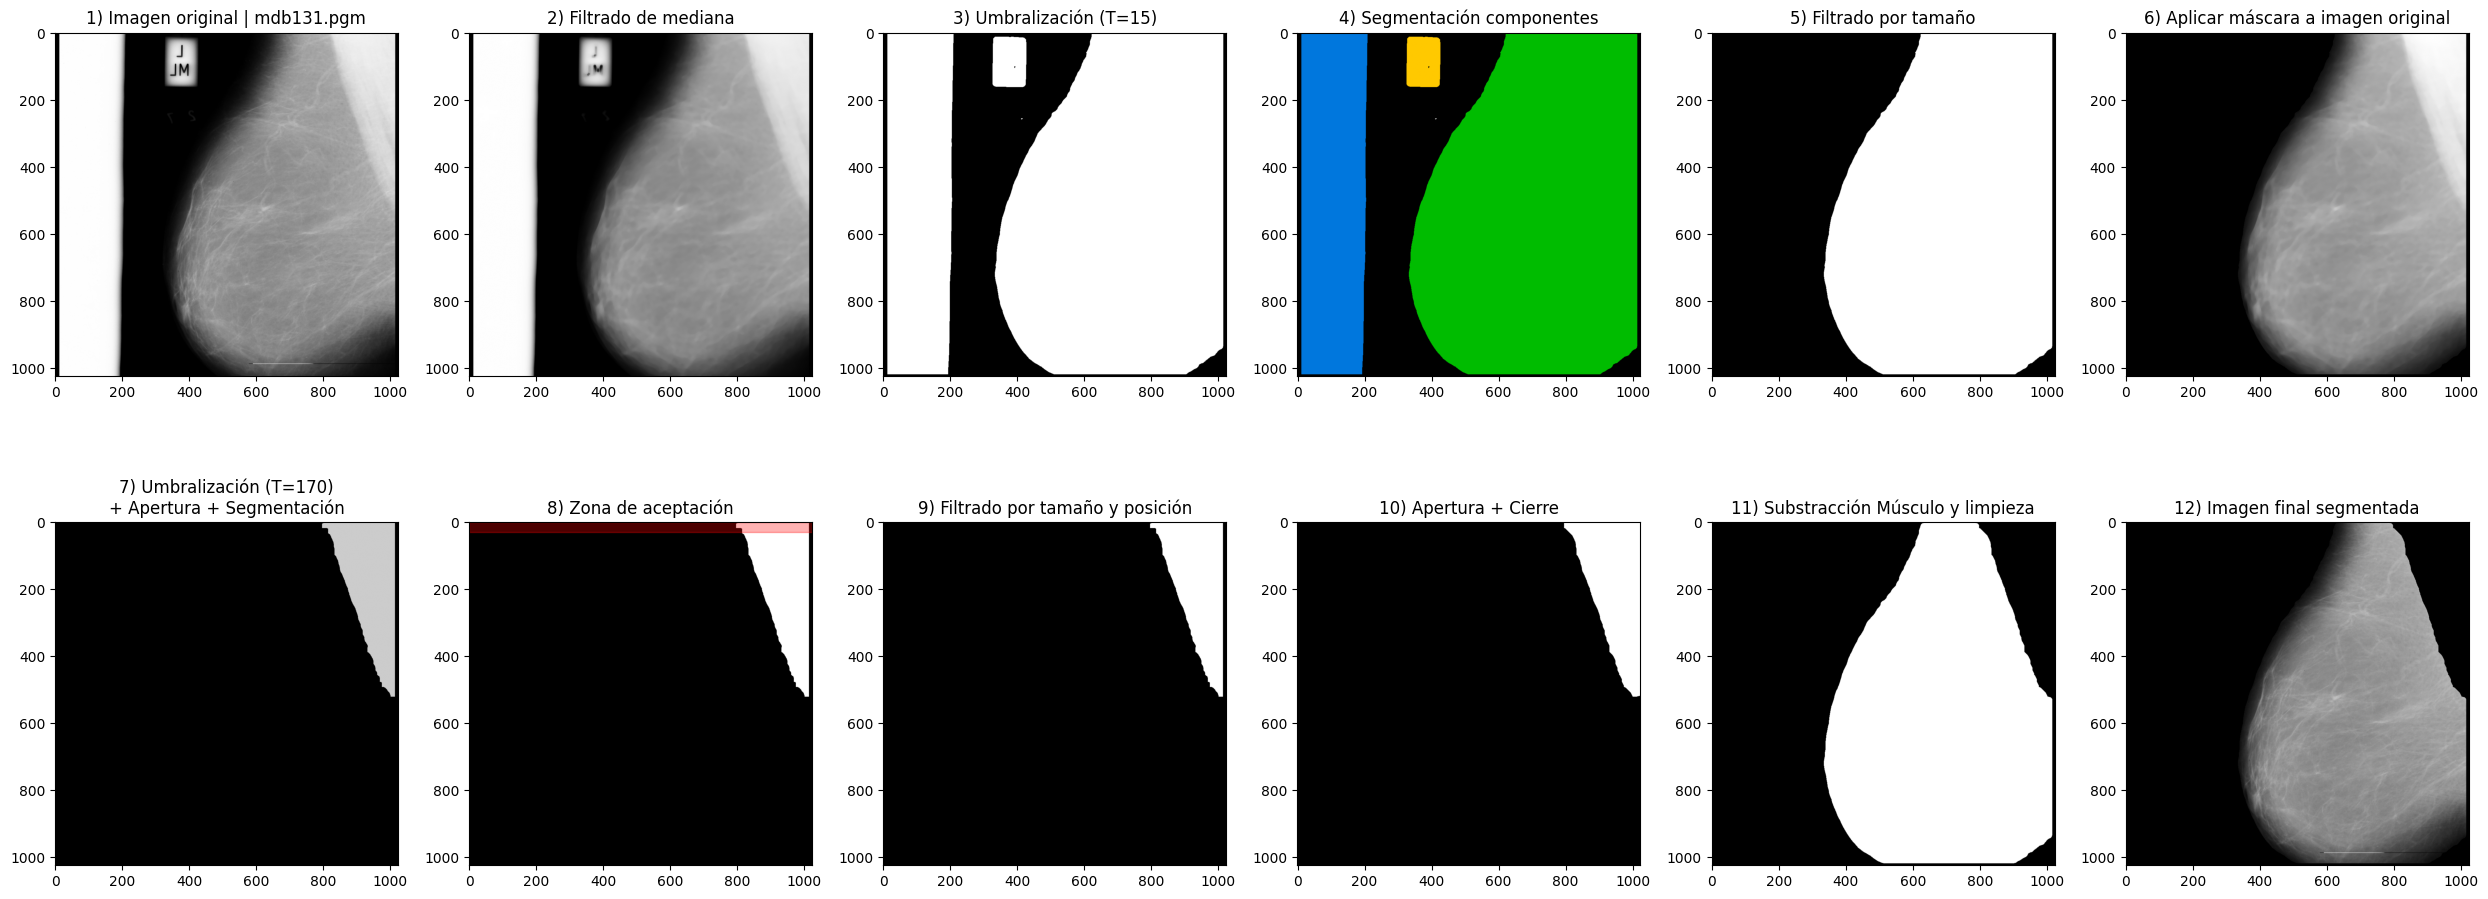

TP=498161 | FP=23890 | FN=6843 | IoU=0.9419


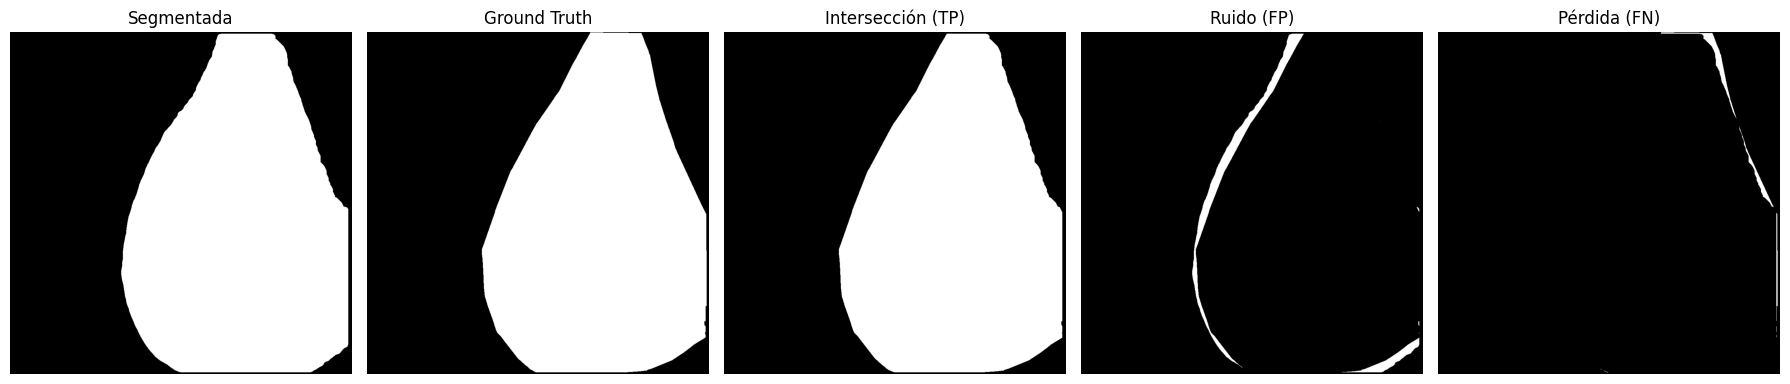

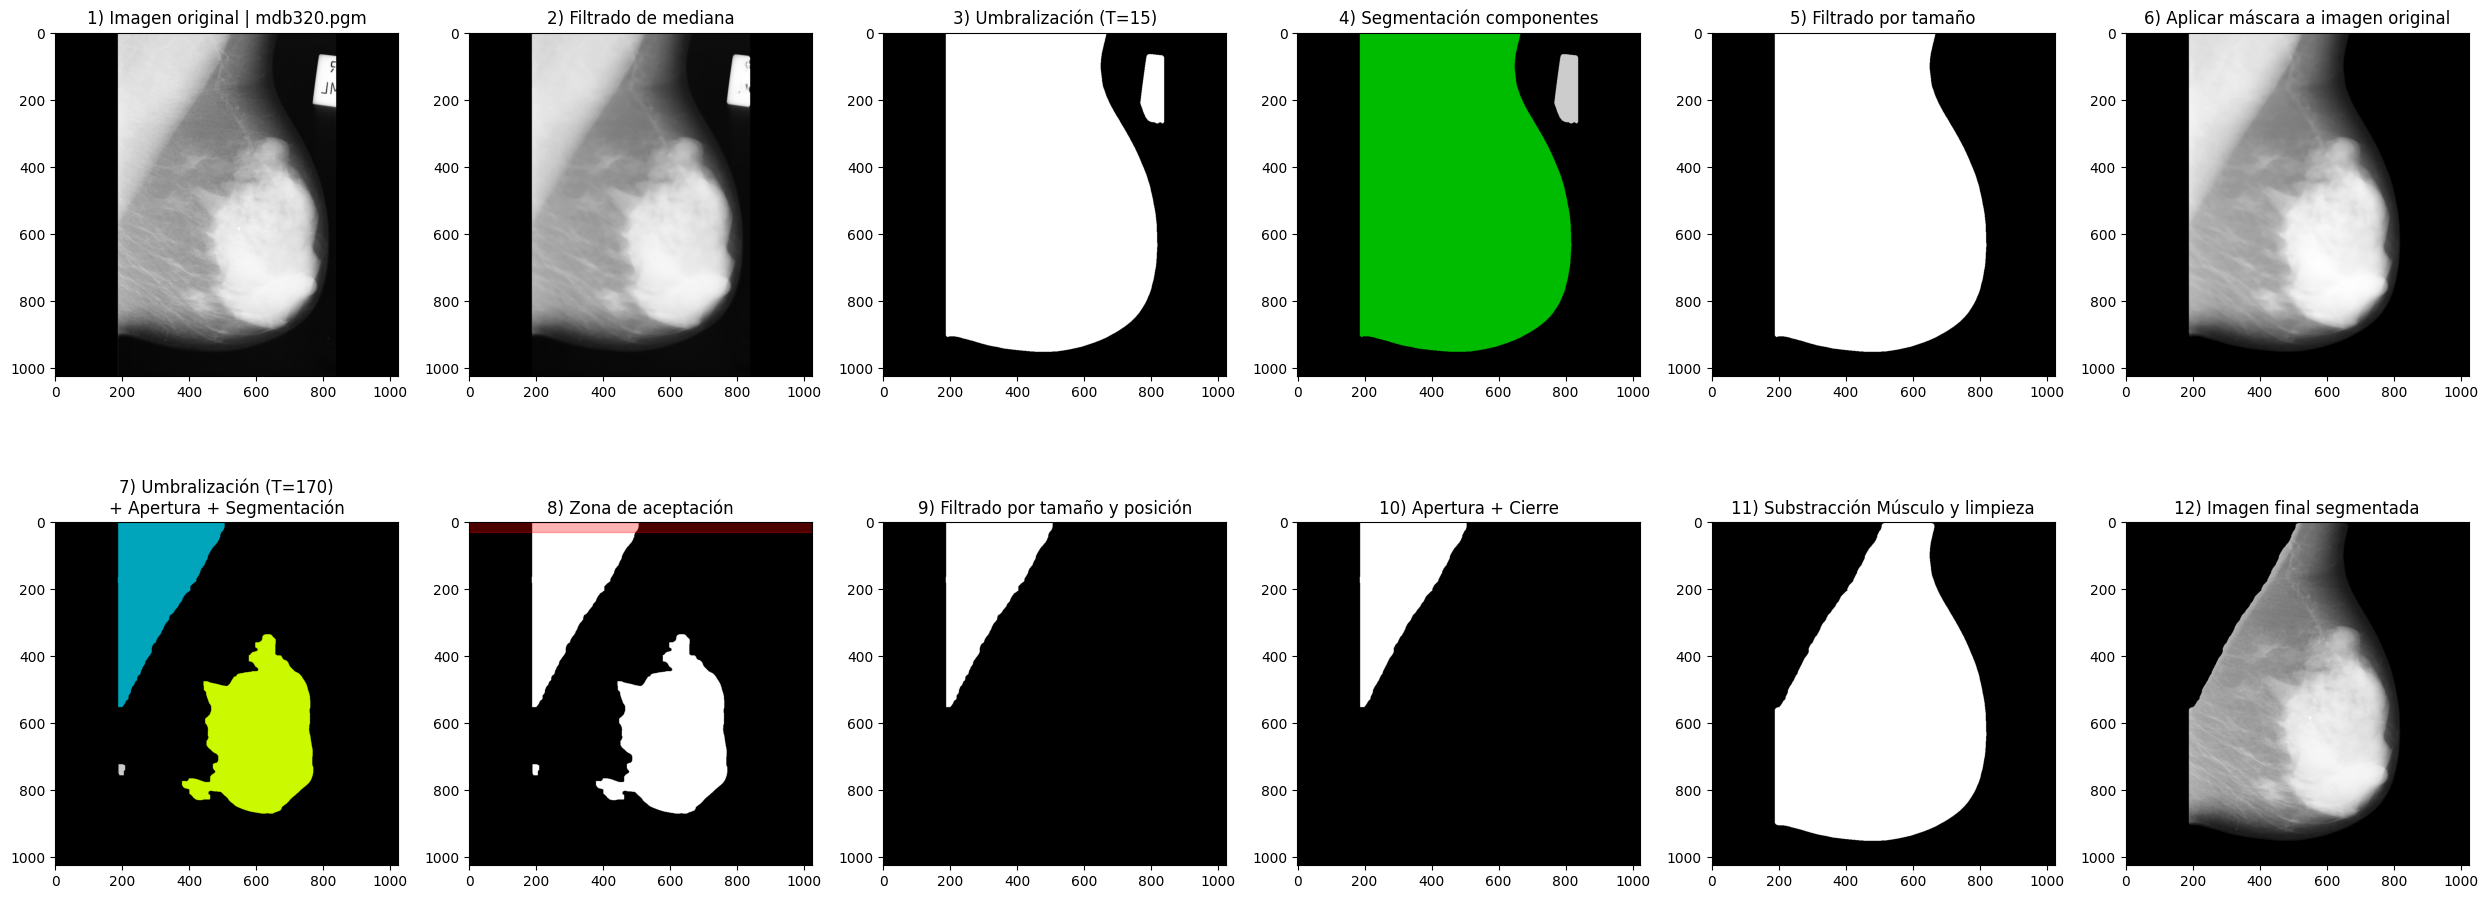

TP=415355 | FP=11139 | FN=2990 | IoU=0.9671


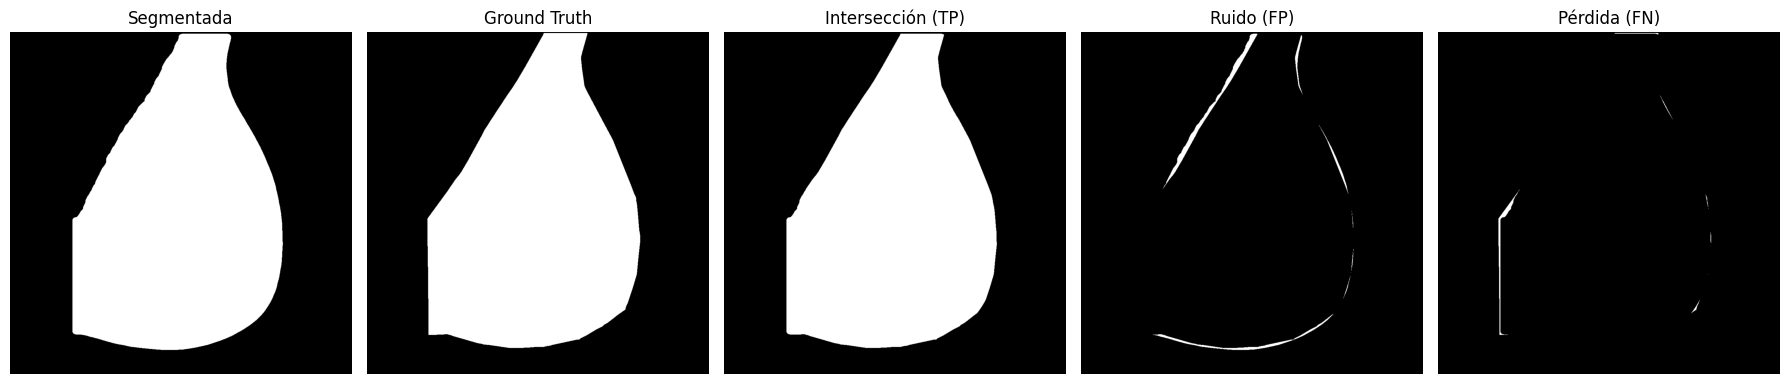

In [68]:
for nombre, datos in images_dict.items():

    images_dict[nombre]['auto_mask'], images_dict[nombre]['filtered'] = preprocesado_imagen(datos['original'], image_name=nombre, plot=True)

    images_dict[nombre]['resultados_seg'] = evaluar_segmentacion(datos['mask'], datos['auto_mask'], plot=True)

    print("\n\n\n")

## Clasificación

**Objetivo:** Clasificar el tipo de tejido usando únicamente la región segmentada, basada en sus características de color y textura.

### 1) Debemos de extraer las características de interés (en este caso intensidad y textura)

In [69]:
def extraer_caracteristicas_textura(masked_image, mask):
    """
    Extrae un conjunto reducido de características de textura desde la región segmentada de una mamografía.
    Las características extraídas combinan información de intensidad, entropía local y textura (GLCM).
    
    Parámetros:
    - masked_image: imagen en escala de grises con fondo negro (resultado de aplicar la máscara).
    - mask: máscara binaria (valores 0 y 1) correspondiente a la región segmentada del tejido mamario.

    Devuelve:
    - vector: lista con 6 características numéricas en el siguiente orden:
        [media intensidad, desviación típica intensidad,
         entropía media,
         contraste GLCM, homogeneidad GLCM, energía GLCM]
    """
    vector = []
    img = img_as_ubyte(masked_image)
    vals = img[mask > 0]

    # Estadísticos de intensidad
    vector.append(np.mean(vals))
    vector.append(np.std(vals))

    # Entropía local (media)
    ent = entropy(img, disk(5))
    ent_vals = ent[mask > 0]
    vector.append(np.mean(ent_vals))

    # GLCM (co-ocurrencia de niveles de gris)
    glcm = graycomatrix(img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    vector.append(graycoprops(glcm, 'contrast')[0, 0])
    vector.append(graycoprops(glcm, 'homogeneity')[0, 0])
    vector.append(graycoprops(glcm, 'energy')[0, 0])

    return vector

In [70]:
for nombre, datos in images_dict.items():
    mask = datos['auto_mask']
    imagen_segmentada = datos['filtered']

    # Extraer características y almacenarlas
    caracteristicas = extraer_caracteristicas_textura(imagen_segmentada, mask)
    images_dict[nombre]['caracteristicas'] = caracteristicas

### 2) Preparamos los datos de entrada a partir del diccionario

In [71]:
features = []
labels = []
names = []

for nombre, datos in images_dict.items():
    features.append(datos['caracteristicas'])
    labels.append(datos['label'])
    names.append(nombre)

features = np.array(features)
labels = np.array(labels)

3) Decidimos como dividir los conjuntos de entrenamiento y validación

Primero observamos la distribución en clases para elegir el método de división de los conjuntos.

In [72]:
unique_labels, counts = np.unique(labels, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"Clase {label}: {count} imágenes")

Clase 0: 8 imágenes
Clase 1: 8 imágenes
Clase 2: 7 imágenes


Las clases están bastante balanceadas, pero el número de muestras en bajo. Por lo que haremos una partición estratificada para asegurarnos de que cada fold contenga un número igual o similar de muestras de cada clase.

4. Entrenamos clasificadores

Decido probar con un Random Forest. Me he decantado por utilizar la versión de scikit-learn, ya que este permite fijar una semilla para reproducibilidad. Lo cual es fundamental para poder elaborar un informe.

In [73]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=456)

aciertos_RF = []
y_true_all = []
y_pred_all = []

fold = 1
for train_idx, test_idx in kfold.split(features, labels):    
    train_data_k = features[train_idx]
    train_labels_k = labels[train_idx]

    test_data_k = features[test_idx]
    test_labels_k = labels[test_idx]

    clf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=456)
    clf.fit(train_data_k, train_labels_k)
    pred = clf.predict(test_data_k)

    success = np.sum(pred == test_labels_k)
    porcentaje = 100 * success / test_labels_k.shape[0]
    aciertos_RF.append(success)

    print(f"\nFold {fold} | Aciertos: {success} / {test_labels_k.shape[0]} ({porcentaje:.3f}%)")
    
    # Reporte por clase
    print("\nClasificación por clase:")
    print(classification_report(test_labels_k, pred, digits=3))

    # Matriz de confusión
    print("Matriz de confusión:")
    print(confusion_matrix(test_labels_k, pred))

    y_true_all.extend(test_labels_k)
    y_pred_all.extend(pred)
    fold += 1

    print("\n", "-"*55)

# Métricas globales
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Promedio final en porcentaje
total_muestras = sum(len(test_idx) for _, test_idx in kfold.split(features, labels))
promedio_porcentaje = 100 * sum(aciertos_RF) / total_muestras
print(f"\n\tPROMEDIO DE ACIERTOS TOTALES: {promedio_porcentaje:.3f}%")

print("\nClasificación global (todas las predicciones):")
print(classification_report(y_true_all, y_pred_all, digits=3))

print("Matriz de confusión global:")
print(confusion_matrix(y_true_all, y_pred_all))


Fold 1 | Aciertos: 5 / 6 (83.333%)

Clasificación por clase:
              precision    recall  f1-score   support

           0      0.667     1.000     0.800         2
           1      1.000     0.500     0.667         2
           2      1.000     1.000     1.000         2

    accuracy                          0.833         6
   macro avg      0.889     0.833     0.822         6
weighted avg      0.889     0.833     0.822         6

Matriz de confusión:
[[2 0 0]
 [1 1 0]
 [0 0 2]]

 -------------------------------------------------------

Fold 2 | Aciertos: 5 / 6 (83.333%)

Clasificación por clase:
              precision    recall  f1-score   support

           0      1.000     0.500     0.667         2
           1      0.667     1.000     0.800         2
           2      1.000     1.000     1.000         2

    accuracy                          0.833         6
   macro avg      0.889     0.833     0.822         6
weighted avg      0.889     0.833     0.822         6

Matriz 

Los resultados han sido bastante buenos con Random Forest. Vamos a probar ahora con un SVM para contrastar.

Para utilizar un SVM es crucial normalizar el vector de características (sobretodo cuando las variables tienen escalas muy distintas, que es nuestro caso).

In [74]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=456)

aciertos_SVM = []
y_true_all_svm = []
y_pred_all_svm = []

fold = 1
for train_idx, test_idx in kfold.split(features, labels):    
    X_train = features[train_idx]
    y_train = labels[train_idx]
    X_test = features[test_idx]
    y_test = labels[test_idx]

    # Normalización dentro del fold
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = SVC(kernel='rbf', C=1.0, gamma='scale')
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    success = np.sum(y_pred == y_test)
    porcentaje = 100 * success / y_test.shape[0]
    aciertos_SVM.append(success)

    print(f"\nFold {fold} | Aciertos: {success} / {y_test.shape[0]} ({porcentaje:.2f}%)")
    print("\nClasificación por clase:")
    print(classification_report(y_test, y_pred, digits=3))
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))

    y_true_all_svm.extend(y_test)
    y_pred_all_svm.extend(y_pred)
    fold += 1

    print("\n", "-"*55)

# Métricas globales
y_true_all_svm = np.array(y_true_all_svm)
y_pred_all_svm = np.array(y_pred_all_svm)

total_muestras = len(y_true_all_svm)
promedio_porcentaje_svm = 100 * sum(aciertos_SVM) / total_muestras
print(f"\n\tPROMEDIO DE ACIERTOS TOTALES: {promedio_porcentaje_svm:.2f}%")

print("\nClasificación global (todas las predicciones):")
print(classification_report(y_true_all_svm, y_pred_all_svm, digits=3))

print("Matriz de confusión global:")
print(confusion_matrix(y_true_all_svm, y_pred_all_svm))



Fold 1 | Aciertos: 5 / 6 (83.33%)

Clasificación por clase:
              precision    recall  f1-score   support

           0      0.667     1.000     0.800         2
           1      1.000     0.500     0.667         2
           2      1.000     1.000     1.000         2

    accuracy                          0.833         6
   macro avg      0.889     0.833     0.822         6
weighted avg      0.889     0.833     0.822         6

Matriz de confusión:
[[2 0 0]
 [1 1 0]
 [0 0 2]]

 -------------------------------------------------------

Fold 2 | Aciertos: 5 / 6 (83.33%)

Clasificación por clase:
              precision    recall  f1-score   support

           0      1.000     0.500     0.667         2
           1      0.667     1.000     0.800         2
           2      1.000     1.000     1.000         2

    accuracy                          0.833         6
   macro avg      0.889     0.833     0.822         6
weighted avg      0.889     0.833     0.822         6

Matriz de